In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy.interpolate import splev, splrep
from scipy.signal import kaiserord, firwin, lfilter

/home/alumnos/lauramll/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from scipy.io import loadmat

In [3]:
import wfdb

<IPython.core.display.Javascript object>


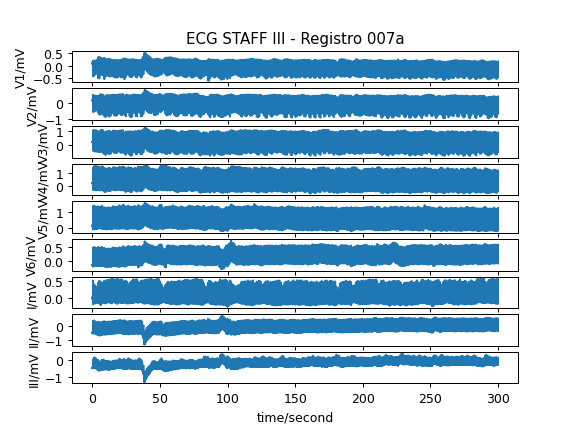

In [4]:
# Cargar el registro
record = wfdb.rdrecord("/home/alumnos/lauramll/Escritorio/TFG/staff_III/staffiii_database/data/007a")
# Graficar las señales de ECG
wfdb.plot_wfdb(record=record, title="ECG STAFF III - Registro 007a")


In [5]:
# Cargar anotaciones 
annotations = wfdb.rdann("/home/alumnos/lauramll/Escritorio/TFG/staff_III/staffiii_database/data/001c", "hea")

# Mostrar las anotaciones
print(annotations.sample)  # Muestra los instantes donde hay anotaciones
print(annotations.symbol)  # Muestra los tipos de anotaciones

[   48   865  1153  1441  1489  1537  1592  1642  1696  2240  2803  3110
  3168  3216  4034  4081  4906  5211  5524  5534  5838  6449  6805  6921
  7482  7781  8342  8630  8684  8732  9293  9325  9357  9389  9421  9453
  9795  9805 10109 10720 11076 11192 11753 12052 12613 12901 12955 13003
 13564 13596 13628 13660 13692 13724 14322 14332 14636 15247 15603 15719
 16280 16579 17140 17428 17482 17530 18091 18123 18155 18187 18219 18251
 19105 19115 19419 20030 20386 20502 21063 21362 21923 22211 22265 22313
 22874 22906 22938 22970 23002 23034 23120 23130 23434 24045 24401 24517
 25078 25377 25938 26226 26280 26328 26889 26921 26953 26985 27017 27049
 27391 27401 27705 28316 28672 28788 29349 29648 30209 30497 30551 30599
 31160 31192 31224 31256 31288 31320 31918 31928 32232 32843 33199 33315
 33876 34175 34736 35024 35078 35126 35687 35719 35751 35783 35815 35847
 36432 36480 37297 37343 37440 37728 38550 38859 38909 39470 39518 39806
 39856 39904 39952 40000 40048 40336 40921 40969 41

In [6]:
# Cargar anotaciones 
events = wfdb.rdann("/home/alumnos/lauramll/Escritorio/TFG/staff_III/staffiii_database/data/001c", "event")

# Mostrar las anotaciones
print(events.sample)  # Muestra los instantes donde hay anotaciones
print(events.symbol)  # Muestra los tipos de anotaciones

[ 60001 245000]
['"', '"']


In [7]:
df = pd.DataFrame(record.p_signal, columns=record.sig_name)
df.to_csv("ecg_record.csv", index=False)


In [8]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I', 'II', 'III'], dtype='object')

In [9]:
V1= df['V1']
V2= df['V2']
V3 = df['V3']
V4 = df['V4']
V5 = df['V5']
V6 = df['V6']
I=df['I']

In [10]:
len(V2)

300000

In [11]:
V2=np.array(V2)

<IPython.core.display.Javascript object>


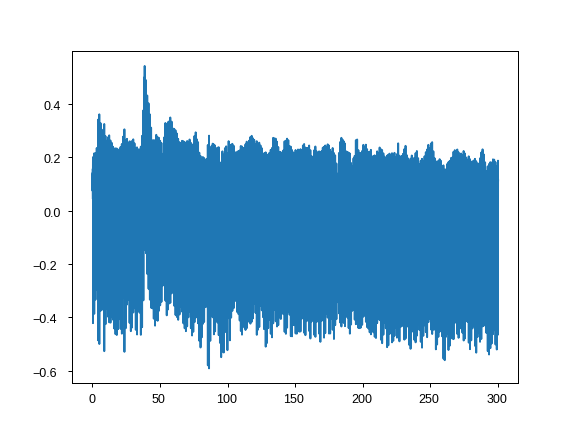

In [12]:
fs =1000
t = np.arange(0,len(V2)/fs,1/fs) 
plt.figure()
plt.plot(t,V1)

<IPython.core.display.Javascript object>


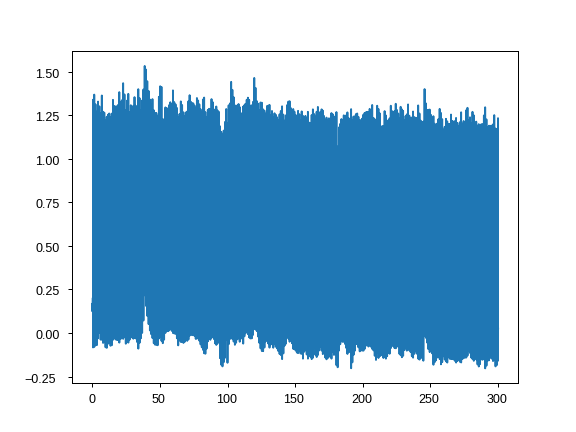

In [13]:
fs =1000

t = np.arange(0,len(V5)/fs,1/fs) 
plt.figure()
plt.plot(t,V5)

<IPython.core.display.Javascript object>


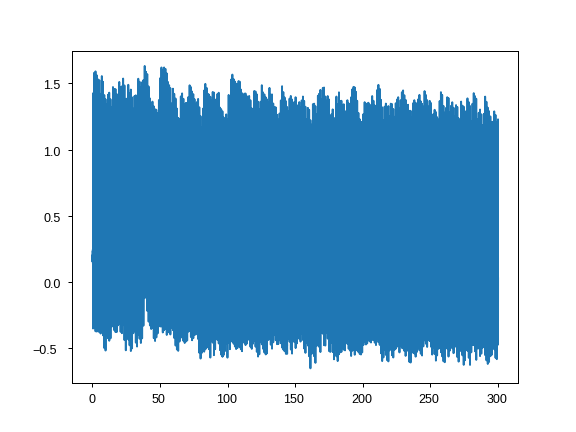

In [14]:
fs =1000

t = np.arange(0,len(V4)/fs,1/fs) 
plt.figure()
plt.plot(t,V4)

<IPython.core.display.Javascript object>


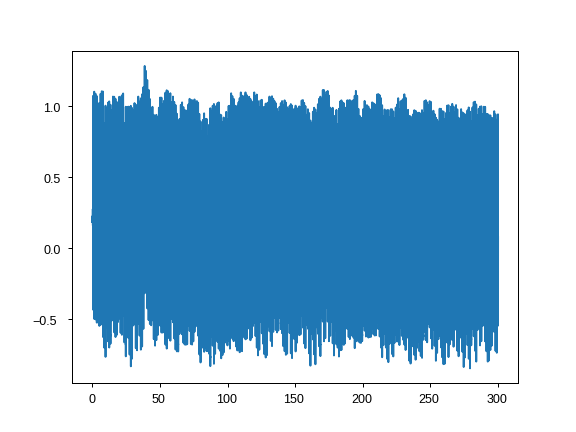

In [15]:
fs =1000

t = np.arange(0,len(V3)/fs,1/fs) 
plt.figure()
plt.plot(t,V3)

<IPython.core.display.Javascript object>


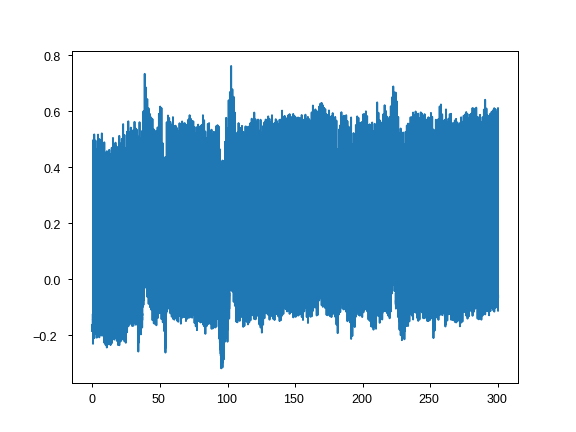

In [16]:
fs =1000

t = np.arange(0,len(V6)/fs,1/fs) 
plt.figure()
plt.plot(t,V6)

In [18]:
print(record.sig_name) 

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I', 'II', 'III']


In [19]:
record = wfdb.rdrecord('/home/alumnos/lauramll/Escritorio/TFG/staff_III/staffiii_database/data/007a')

# Acceder a la señal de ECG
ecg_signal = record.p_signal[:, 4]



<IPython.core.display.Javascript object>


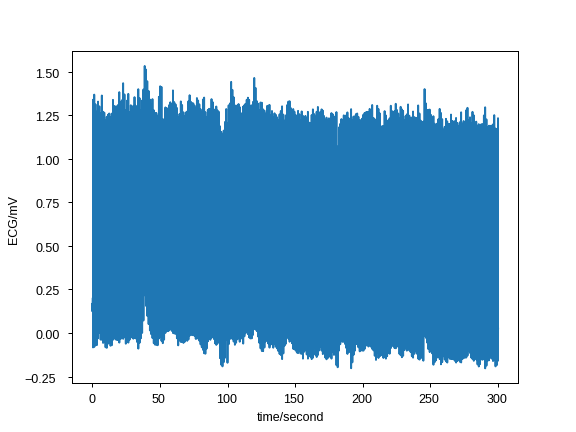

In [21]:
fig= wfdb.plot_items(
    ecg_signal,
    [],
    fs=1000,
    sig_name=["ECG"],
    sig_units=["mV"],
    time_units="seconds",
    return_fig=True,
    ann_style="o",
)

# PREPROCESAMIENTO

In [22]:
from scipy.signal import butter, filtfilt, lfilter

fs = int(record.fs)


def bandpass_filter(signal, lowcut, highcut, fs, order=4 , trim_sec=2.0):
    
    x = np.asarray(signal, dtype=float)
    
    if x.size == 0 or not np.isfinite(x).any():
        return np.array([], float)

    #centrar señal
    x = x - np.nanmean(x) 

    
    # recortar artefacto final
    if trim_sec and trim_sec > 0:
        n = int(round(trim_sec * fs))
        if n < len(x):
            x = x[:-n]
        else:
            return np.array([], dtype=float)
    
    # diseño del filtro
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if not (0 < low < high < 1):
        raise ValueError("cutoffs fuera de rango")
        
    b, a = butter(order, [low, high], btype='band')
    
    padlen = 3 * (max(len(a), len(b)) - 1)
    if len(x) <= padlen:
        return lfilter(b, a, x)
    
    
    return filtfilt(b, a, x)



<IPython.core.display.Javascript object>


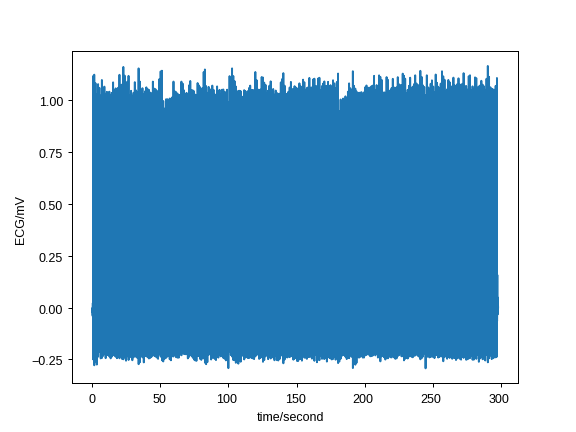

In [23]:
fs = record.fs

ecg_signal_filtered = bandpass_filter(ecg_signal, 0.5, 40, fs, order= 4, trim_sec=2) 


fig= wfdb.plot_items(
    ecg_signal_filtered,
    [],
    fs=1000,
    sig_name=["ECG"],
    sig_units=["mV"],
    time_units="seconds",
    return_fig=True,
    ann_style="o",
)



<IPython.core.display.Javascript object>


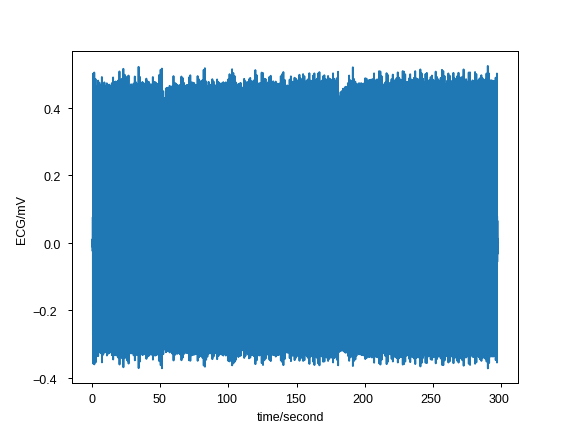

In [24]:
ecg_signal_r = bandpass_filter(ecg_signal, 5, 15, fs, order= 4, trim_sec=2) 


fig= wfdb.plot_items(
    ecg_signal_r,
    [],
    fs=1000,
    sig_name=["ECG"],
    sig_units=["mV"],
    time_units="seconds",
    return_fig=True,
    ann_style="o",
)



# Obtención picos R

In [25]:
import wfdb.processing


def rpeaks_ref_from_lead(ecg_signal, fs):
   
    
    ecg_signal = np.asarray(ecg_signal, float).squeeze()
    if ecg_signal.size == 0:
        return np.array([], dtype=int)

    if not np.isfinite(ecg_signal).all():
        finite = np.isfinite(ecg_signal)
        if not finite.any():
            return np.array([], int)
        med = np.nanmedian(ecg_signal[finite])
        ecg_signal = np.nan_to_num(ecg_signal, nan=med, posinf=med, neginf=med)
    
    
    try:
        rpeaks = wfdb.processing.gqrs_detect(ecg_signal, fs=fs)
    except Exception:
        return np.array([], dtype=int)
    

    if rpeaks is None or len(rpeaks) == 0:
        return np.array([], dtype=int)
    
    
    rpeaks_corrected = wfdb.processing.correct_peaks(
        ecg_signal, rpeaks,
        search_radius=int(0.12*fs),   # ~120 ms
        smooth_window_size=150,
        peak_dir="both"
    ).astype(int)

    rpeak_times  = rpeaks_corrected / fs
    rr_intervals = np.diff(rpeak_times)
    valid_rr_idx = np.where((rr_intervals > 0.3) & (rr_intervals < 2.0))[0]
    valid_rpeaks = rpeaks_corrected[valid_rr_idx + 1]
    rpeaks_ref = rpeaks_corrected[valid_rr_idx + 1].astype(int)
    
    if valid_rpeaks.size < 3:
        valid_rpeaks = r_peaks
    
    refr = int(0.25 * fs)  # 250 ms
    kept = [valid_rpeaks[0]]
    for r in valid_rpeaks[1:]:
        if r - kept[-1] >= refr:
            kept.append(r)
    r_final = np.asarray(kept, dtype=int)

    return r_final


<IPython.core.display.Javascript object>


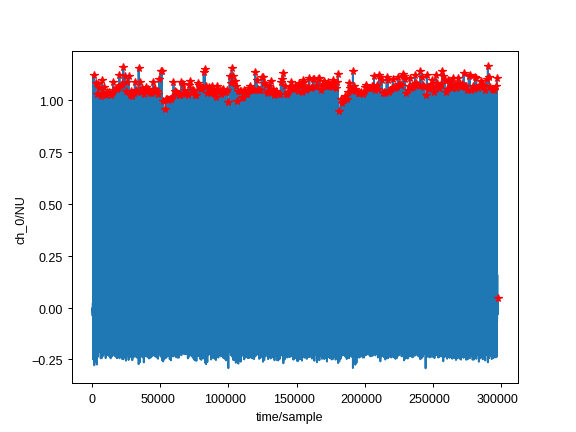

In [26]:

fs = 1000

rpeaks = rpeaks_ref_from_lead(ecg_signal_filtered, fs=fs)


wfdb.plot_items(ecg_signal_filtered, [rpeaks]) 



<IPython.core.display.Javascript object>


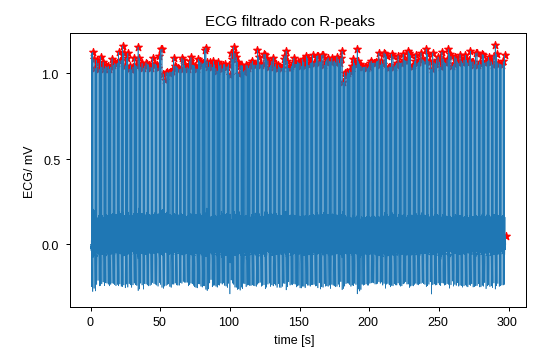

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fs = 1000  # Hz

rpeaks = rpeaks_ref_from_lead(ecg_signal_filtered, fs=fs)

# Eje temporal
t = np.arange(len(ecg_signal_filtered)) / fs

plt.figure(figsize=(6, 4))


plt.plot(t, ecg_signal_filtered, linewidth=0.5)
plt.scatter(
    t[rpeaks],
    ecg_signal_filtered[rpeaks],
    marker='*',
    color='red',     
    s=40              
)

plt.xlabel("time [s]")
plt.ylabel("ECG/ mV")
plt.title("ECG filtrado con R-peaks")
plt.tight_layout()

plt.savefig("ecg_filtrado_rpeaks.png", dpi=300)
plt.show()


<IPython.core.display.Javascript object>


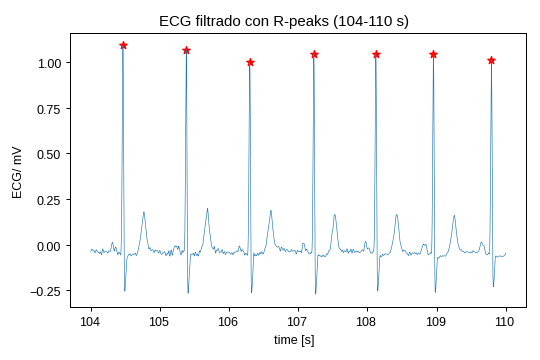

In [28]:
import numpy as np
import matplotlib.pyplot as plt

fs = 1000  # Hz

rpeaks = rpeaks_ref_from_lead(ecg_signal_filtered, fs=fs)

# Eje temporal en segundos
t = np.arange(len(ecg_signal_filtered)) / fs

t0 = 104  # segundo de inicio
t1 = 110  # segundo de fin

# Máscara de puntos de la señal en ese intervalo
mask = (t >= t0) & (t <= t1)

# Índices de R-peaks que caen dentro del intervalo
rpeaks_zoom = rpeaks[(t[rpeaks] >= t0) & (t[rpeaks] <= t1)]

plt.figure(figsize=(6, 4))


plt.plot(t[mask], ecg_signal_filtered[mask], linewidth=0.5)
plt.scatter(
    t[rpeaks_zoom],
    ecg_signal_filtered[rpeaks_zoom],
    marker='*',
    color='red',
    s=40
)

plt.xlabel("time [s]")
plt.ylabel("ECG/ mV")
plt.title(f"ECG filtrado con R-peaks ({t0}-{t1} s)")
plt.tight_layout()

plt.savefig(f"ecg_filtrado_rpeaks_{104}_{110}s.png", dpi=300)
plt.show()


----------------

# Eliminación Baseline


Elimina la deriva de línea de base (baseline wander) mediante splines cúbicos
anclados en la línea isoeléctrica (PQ), tomada unos milisegundos antes de cada
fiducial (p. ej., pico R). La spline estimada se resta al ECG para centrarlo.

Parámetros:

- orig_ecg : ndarray (N,) - Señal ECG en mV.
- fiducial_points : ndarray de int - Índices de los latidos (p. ej., R-peaks) en muestras.
- fs : float - Frecuencia de muestreo en Hz.
- tPQ_ms : float, opcional (puesto por defecto 80) - Desplazamiento hacia atrás desde cada fiducial para ubicar PQ (ms).
- win_med_ms : float, opcional (puesto por defecto 10) - Semiventana para calcular una mediana local en cada nudo (ms), que hace el ajuste más robusto frente a ruido.

Devuelve: 

- bw_estimate : ndarray (N,) - Estimación suave de la línea de base (baseline).



In [29]:
def bw_elimination(orig_ecg, fiducial_points, fs):

    tPQ = 80e-3  # Duración antes del punto fiducial considerando la línea isoeléctrica (80 ms)
    nPQ = int(tPQ * fs) #Número de muestras correspondientes a la línea isoeléctrica

    numb_fid_points = len(fiducial_points)

    if fiducial_points[0].any() - nPQ <= 0:
        
        #Array para los nudos para la interpolación por splines
        the_knots = np.array(np.zeros(numb_fid_points + 1)) 
        
        the_knots[0] = 1 
        
        #establece los nudos como puntos fiduciales menos la duración de la línea isoléctrica
        the_knots[1:numb_fid_points] = fiducial_points[1:numb_fid_points] - nPQ 
        
        #Establece el último nudo como la longitud de la señal
        the_knots[numb_fid_points] = len(orig_ecg) 
        
        # Convierte los nudos en índices 
        the_knots = the_knots - 1
        the_knots = the_knots.astype(int)

        # Crea un array 'c' para especificar la continuidad de los splines
        c = np.concatenate((the_knots[1], the_knots[1:numb_fid_points], the_knots[numb_fid_points-1]), axis=None)

        # Realiza la interpolación por splines cúbicos usando los nudos y las muestras del ECG 
        bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots, orig_ecg[c]), ext=0)

    else:
    
        the_knots = np.array(np.zeros(numb_fid_points + 2))
        the_knots[0] = 1
        the_knots[1:numb_fid_points] = fiducial_points - nPQ
        the_knots[numb_fid_points] = len(orig_ecg)
  
        the_knots = the_knots - 1
        the_knots = the_knots.astype(int)

        c = np.concatenate((the_knots[1], the_knots[1:numb_fid_points], the_knots[numb_fid_points-1]), axis=None)

        bw_estimate = splev(np.arange(len(orig_ecg)), splrep(the_knots, c), ext=0)

    return bw_estimate # Devuelve la estimación de la deriva de la línea de base

<IPython.core.display.Javascript object>


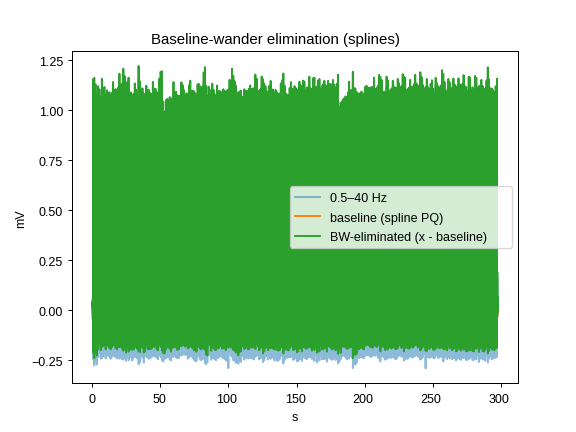

<IPython.core.display.Javascript object>


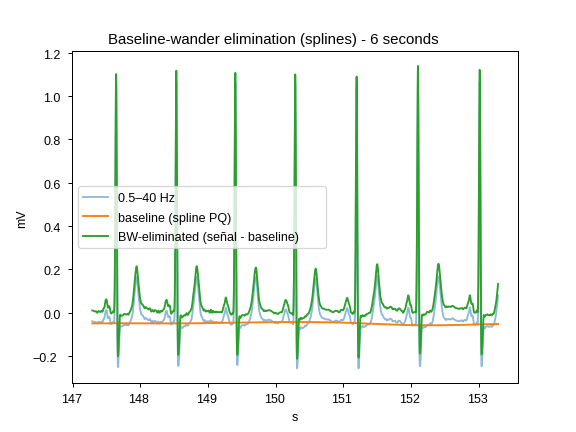

Baseline relativa global ≈ 6.2%
Mediana por tramos ≈ 1.4%


In [30]:
bw_est = bw_elimination(ecg_signal_filtered, rpeaks, fs)

x_bw = ecg_signal_filtered - bw_est 


center = rpeaks[len(rpeaks)//2]
W = 3*fs
sl = slice(max(0, center-W), min(len(ecg_signal_filtered), center+W)) 
t = np.arange(len(ecg_signal_filtered))/fs


#señal completa
plt.figure()
plt.plot(t, ecg_signal_filtered, alpha=0.5, label='0.5–40 Hz')
plt.plot(t, bw_est, label='baseline (spline PQ)')
plt.plot(t, x_bw, label='BW-eliminated (x - baseline)')
plt.xlabel('s'); plt.ylabel('mV'); plt.title('Baseline-wander elimination (splines) ')
plt.legend(); plt.show()


# Visual de control en ~6 s
plt.figure()
plt.plot(t[sl], ecg_signal_filtered[sl], alpha=0.5, label='0.5–40 Hz')
plt.plot(t[sl], bw_est[sl], label='baseline (spline PQ)')
plt.plot(t[sl], x_bw[sl], label='BW-eliminated (señal - baseline)')
plt.xlabel('s'); plt.ylabel('mV'); plt.title('Baseline-wander elimination (splines) - 6 seconds')
plt.legend()
plt.savefig("bw_elimination_6s.png", dpi=300, bbox_inches="tight")
plt.show()






bw_pp_all  = np.ptp(bw_est)                 # pico-a-pico baseline en toda la señal
sig_pp_all = np.ptp(ecg_signal_filtered)    # pico-a-pico de la señal filtrada 0.5–40 Hz
print(f"Baseline relativa global ≈ {100*bw_pp_all/sig_pp_all:.1f}%")


win = 10*fs
vals = [100*np.ptp(bw_est[i:i+win])/np.ptp(ecg_signal_filtered[i:i+win])
        for i in range(0, len(bw_est)-win, win)]
print(f"Mediana por tramos ≈ {np.median(vals):.1f}%")



# Extraer ventanas ST-T


Delinea el complejo ST–T por latido usando una ventana de longitud fija.
El inicio (onset) de ST–T se sitúa a una distancia desde R que depende del RR previo:
        q_i(ms) = 40 + 1.3 * sqrt( RR_i(ms) )

Parámetros
- ecg : ndarray (N,)
        Señal ECG en mV (ya preprocesada/baseline corregida si quieres).
- rpeaks : ndarray de int
        Índices de R en muestras (ordenados, sin artefactos).
- fs : float/int
        Frecuencia de muestreo (Hz).
- win_ms : int/float
        Longitud fija de la ventana ST–T (ms). Por defecto 300 ms.

Devuelve

- ST_T_complexes : ndarray (M, L)
        Matriz con M latidos válidos y L = round(win_ms*fs/1000) muestras por latido.
- ST_T_onset : ndarray (M,)
        Índices de inicio de cada ST–T (en muestras, respecto a la señal original).


In [31]:

def ST_T_delineation(ecg, rpeaks, fs):
    
    
    # Longitud fija en muestras (300ms)
    L = int(np.ceil(0.300 * fs))
    
    
    rpeaks = np.asarray(rpeaks, dtype=int)
    N = len(ecg)
    if rpeaks.size < 2:
        return np.empty((0, int(round(0.300*fs)))), np.array([], dtype=int)

    # RR_i para cada latido i (excepto el último)
    RR = np.diff(rpeaks) / fs                         # en segundos
    RR_ms = RR * 1000.0

    # Distancia desde R al onset de ST–T (ms) según la fórmula
    qi_ms = 40.0 + 1.3 * np.sqrt(RR_ms)

    # limitar a un rango razonable
    qi_ms = np.clip(qi_ms, 50.0, 120.0)

    # Cuantizar a muestras
    qi_samp = np.ceil((qi_ms/1000.0) * fs).astype(int)

    # Onsets: para cada latido i hasta el penúltimo
    ST_T_onset = rpeaks[:-1] + qi_samp


    # Construir matriz de segmentos 
    valid = (ST_T_onset >= 0) & (ST_T_onset + L <= N)
    onsets_valid = ST_T_onset[valid]
    M = onsets_valid.size

    ST_T_complexes = np.zeros((M, L), dtype=float)
    for k, onset in enumerate(onsets_valid):
        ST_T_complexes[k, :] = ecg[onset:onset+L]

    return ST_T_complexes, onsets_valid



ST–T matrix: (321, 300)    nº onsets: 321


<IPython.core.display.Javascript object>


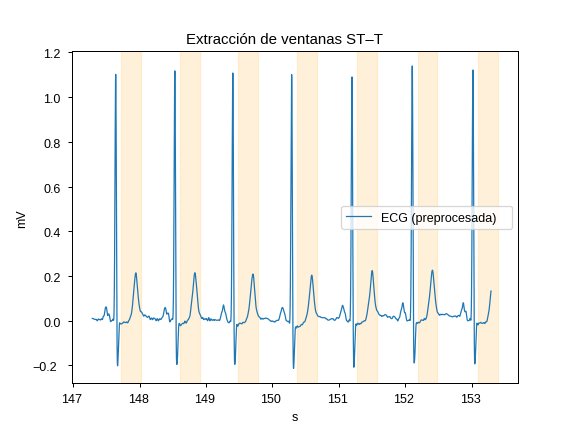

<IPython.core.display.Javascript object>


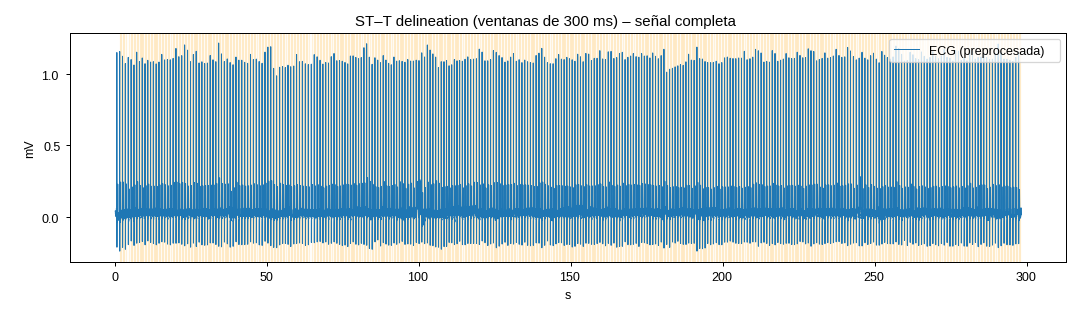

onset medio = 80.0 ms  rango = [77.0, 82.0] ms


In [32]:
 
fs   = int(record.fs)

STT, ST_on = ST_T_delineation(x_bw , rpeaks, fs)
print("ST–T matrix:", STT.shape, "   nº onsets:", len(ST_on))

c = len(rpeaks)//2
W = 3*fs
sl = slice(max(0, rpeaks[c]-W), min(len(x_bw), rpeaks[c]+W))
t = np.arange(len(x_bw))/fs
L = int(0.300*fs)  

#Visualización de 6 segundos
plt.figure()
plt.plot(t[sl], x_bw[sl], lw=1, label='ECG (preprocesada)')
mask = (ST_on>=sl.start) & (ST_on<sl.stop)
for s in ST_on[mask]:
    plt.axvspan(s/fs, (s + L)/fs, color='orange', alpha=0.15)
plt.xlabel('s'); plt.ylabel('mV'); plt.title('Extracción de ventanas ST–T')
plt.legend()
plt.savefig("st-t_delineation_6s.png", dpi=300, bbox_inches="tight")
plt.show()



#Visualización entera
                      
starts = ST_on[(ST_on >= 0) & (ST_on + L <= len(ecg_signal_filtered))]

plt.figure(figsize=(12,3.5))
plt.plot(t, x_bw, lw=0.8, label='ECG (preprocesada)')
for s in starts:
    plt.axvspan(s/fs, (s+L)/fs, color='orange', alpha=0.15)
plt.xlabel('s'); plt.ylabel('mV')
plt.title('ST–T delineation (ventanas de 300 ms) – señal completa')
plt.legend(loc='upper right')
plt.tight_layout(); plt.show()



offset_ms = (ST_on - rpeaks[:-1]) * 1000 / fs
print(f"onset medio = {offset_ms.mean():.1f} ms  rango = [{offset_ms.min():.1f}, {offset_ms.max():.1f}] ms")



<IPython.core.display.Javascript object>


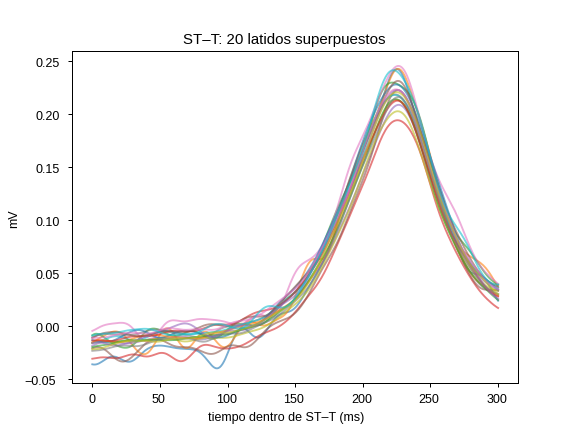

In [33]:
plt.figure()
for k in range(min(20, STT.shape[0])):
    plt.plot(np.linspace(0, 300, STT.shape[1]), STT[k], alpha=0.6)  # eje en ms
plt.xlabel('tiempo dentro de ST–T (ms)'); plt.ylabel('mV')
plt.title('ST–T: 20 latidos superpuestos'); plt.show()


# ALINEACIÓN DE ST T


Alinea cada ST–T por correlación con una plantilla global (mediana o media),
buscando el mejor desplazamiento entero dentro de ±max_shift_ms alrededor del
onset de cada latido.

Parámetros
----------
ecg : ndarray, shape (N,)
    Señal ECG (la misma de la que se extrajeron los ST–T), en mV.
ST_T_complexes : ndarray, shape (n_beats, L)
    Matriz con los ST–T; una fila por latido y L ≈ número de muestras en 300 ms.
ST_T_onset : ndarray, shape (n_beats,)
    Índices de inicio de cada ST–T en muestras.
fs : int o float
    Frecuencia de muestreo (Hz).
max_shift_ms : float, opcional
    Desplazamiento máximo permitido alrededor del onset, en milisegundos (por defecto 30).
template : {'median', 'mean'}, opcional
    Tipo de plantilla utilizada para la correlación (por defecto 'median').

Devuelve
--------
ST_T_aligned : ndarray, shape (n_beats, L)
    ST–T alineados a la plantilla.
ST_T_onset_aligned : ndarray, shape (n_beats,)
    Onsets corregidos (onset original + shift aplicado).
shifts : ndarray, shape (n_beats,)
    Desplazamientos aplicados en muestras (signo: positivo = hacia la derecha).

Notas
-----
- La correlación se normaliza y se evalúa en desplazamientos enteros
  w = round(max_shift_ms/1000 * fs).
- Candidatos que salgan fuera de los límites de la señal se descartan.
- Si para un latido no hay candidato válido, se conserva el segmento original.


In [34]:
    def np_round(a, decimals=0):
        return np.round(a * 10 ** decimals) / 10 ** decimals


    def ST_T_alignment(ST_T_complexes, ST_T_onset, ecg_signal, fs):

        nbeats, nsamples = ST_T_complexes.shape
        ST_T_complexes_align = np.zeros(ST_T_complexes.shape)

        proto = np.median(ST_T_complexes, axis=0)

        w = (0.03 * fs)  # samples
        w = np_round(w)
        w = int(w)

        N = len(ecg_signal)
        
        shifts = np.zeros(nbeats, dtype=int)  # almacenar desfases
        
        
        for k in range(nbeats):
            ini = int(ST_T_onset[k])
            fin = int(ini + nsamples - 1)

            start0 = ini - w
            end0   = fin + w
            a = max(0, start0)
            b = min(N, end0 + 1)                      
            ecg_segment = ecg_signal[a:b]
            need_left  = a - start0                   # cuántas muestras faltan a la izquierda
            need_right = (end0 + 1) - b               # faltantes a la derecha
            
            if need_left > 0 or need_right > 0:
                ecg_segment = np.pad(ecg_segment, (need_left, need_right), mode='edge')
            
            cross_corr = np.zeros(2 * w)

            for m in range(2 * w):
                temp = ecg_segment[m:-(2 * w) + m]
    
                if temp.shape[0] < proto.shape[0]:
                    temp = np.append(temp, temp[-1])
                

                if proto.std() < 1e-12 or temp.std() < 1e-12:
                    cross_corr[m] = 0.0
                else:
                    cc = np.corrcoef(proto, temp)
                    cross_corr[m] = cc[1, 0]
                

            posMax = np.argmax(cross_corr)
            ST_T_complexes_align[k, :] = ecg_segment[posMax:posMax + nsamples]
            
            shifts[k] = posMax - w 
        
        ST_T_onset_aligned = np.asarray(ST_T_onset, dtype=int) + shifts

        return ST_T_complexes_align, ST_T_onset_aligned, shifts

In [35]:
fs    = int(record.fs)

#alineación global
STT_al, ST_on_al, shifts = ST_T_alignment(STT, ST_on, x_bw, fs) # STT y ST_on son de ST_T_delineation

print("STT_al:", STT_al.shape,
      "  shifts (muestras):", shifts.min(), "a", shifts.max())
print("Shifts en ms: min", 1000*shifts.min()/fs, "  max", 1000*shifts.max()/fs)


STT_al: (321, 300)   shifts (muestras): -4 a 4
Shifts en ms: min -4.0   max 4.0


<IPython.core.display.Javascript object>


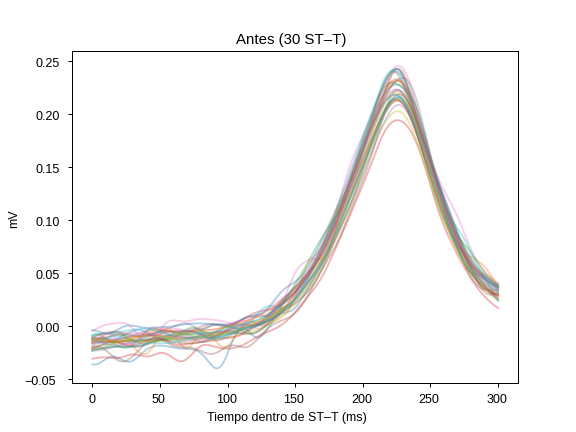

<IPython.core.display.Javascript object>


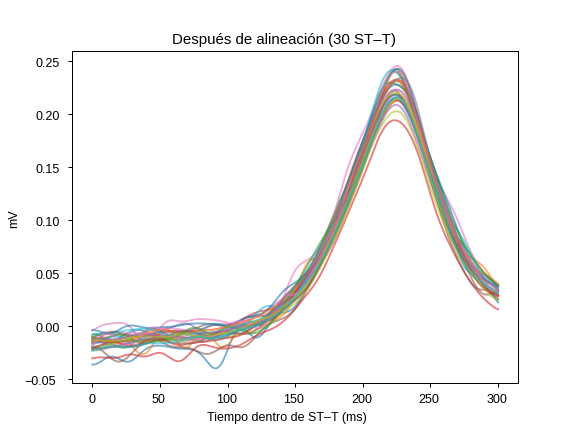

In [36]:
import matplotlib.pyplot as plt

t_ms = np.linspace(0, 300, STT.shape[1])

plt.figure()
for row in STT[:30]:
    plt.plot(t_ms, row, alpha=0.35)
plt.title("Antes (30 ST–T)"); plt.xlabel("Tiempo dentro de ST–T (ms)"); plt.ylabel("mV")
plt.savefig("alineacion_ST-T_antes.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for row in STT_al[:30]:
    plt.plot(t_ms, row, alpha=0.6)
plt.title("Después de alineación (30 ST–T)"); plt.xlabel("Tiempo dentro de ST–T (ms)"); plt.ylabel("mV")
plt.savefig("alineacion_ST-T.png", dpi=300, bbox_inches="tight")
plt.show()






# HEARTBEAT WINDOWING


Genera ventanas solapadas de ST–T: crea segmentos de `WindSize` latidos,
desplazados en pasos de `WindStep`, a partir de la matriz de ST–T.

Parámetros

- ST_T_complexes : ndarray de forma (n_latidos, L)
    Matriz con los segmentos ST–T; cada fila corresponde a un latido y
    L es el número de muestras por segmento (p. ej., 300 ms → L≈300).
- ST_T_onset : ndarray de forma (n_latidos,)
    Índices (en muestras) del inicio de cada ST–T en la señal original.
- WindSize : int
    Tamaño de la ventana en latidos (p. ej., 30).
- WindStep : int
    Paso del deslizamiento en latidos (p. ej., 5).

Devuelve

- ST_T_segments : ndarray de forma (num_segments, WindSize, L)
    Tensor con las ventanas: para cada segmento se apilan `WindSize`
    ST–T consecutivos.
- ST_T_onset_by_segments : ndarray de forma (num_segments, WindSize)
    Onsets correspondientes a los latidos incluidos en cada segmento.
- ST_T_dim : tuple
    Dimensión de la matriz de entrada `(n_latidos, L)`.



In [37]:
def heartbeat_windowing(ST_T_complexes, ST_T_onset, WindSize, WindStep):
    
    n_beats, L = ST_T_complexes.shape
    
    if n_beats < WindSize:
        return (np.zeros((0, WindSize, L)),
                np.zeros((0, WindSize), dtype=int),
                (n_beats, L))
    
    num_segments = 1 + (n_beats - WindSize) // WindStep
    ST_T_segments = np.zeros((num_segments, WindSize, L))
    ST_T_onset_by_segments = np.zeros((num_segments, WindSize), dtype=int)
    
    for k in range(num_segments):
        i1 = k*WindStep; i2 = i1 + WindSize
        ST_T_segments[k] = ST_T_complexes[i1:i2]
        ST_T_onset_by_segments[k] = ST_T_onset[i1:i2]
    
    return ST_T_segments, ST_T_onset_by_segments, (n_beats, L)


In [38]:
#comprobación

WindSize = 32   
WindStep = 8    

ST_segments, ST_on_by_seg, ST_dim = heartbeat_windowing(STT_al, ST_on_al, WindSize, WindStep)
print("ST_T_dim (n_latidos, L):", ST_dim)
print("ST_segments shape:", ST_segments.shape)          # (num_segments, 30, L)
print("ST_on_by_seg shape:", ST_on_by_seg.shape)        # (num_segments, 30)


ST_T_dim (n_latidos, L): (321, 300)
ST_segments shape: (37, 32, 300)
ST_on_by_seg shape: (37, 32)


<IPython.core.display.Javascript object>


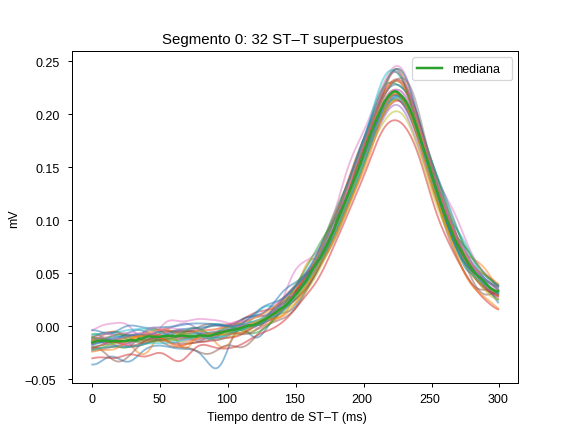

In [39]:
k = 0  
L = ST_segments.shape[2]
t_ms = np.linspace(0, 300, L, endpoint=False)

plt.figure()
for j in range(ST_segments.shape[1]):
    plt.plot(t_ms, ST_segments[k, j], alpha=0.5)
plt.plot(t_ms, np.median(ST_segments[k], axis=0), lw=2, label='mediana')
plt.xlabel('Tiempo dentro de ST–T (ms)'); plt.ylabel('mV')
plt.title(f'Segmento {k}: {ST_segments.shape[1]} ST–T superpuestos')
plt.legend()
plt.savefig("enventanado_ST-T.png", dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipykernel_267498/2055478827.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 5))


<IPython.core.display.Javascript object>


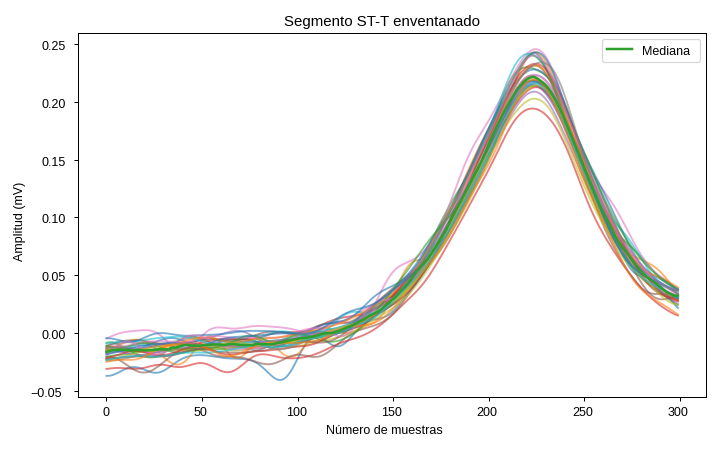

In [40]:
import numpy as np
import matplotlib.pyplot as plt

k = 0   # por ejemplo, el primer segmento

# Número de muestras del ST-T ventana 
L = ST_segments.shape[2]
n_muestras = np.arange(L)

plt.figure(figsize=(8, 5))

for j in range(ST_segments.shape[1]):
    plt.plot(n_muestras, ST_segments[k, j, :], alpha=0.6)

mediana = np.median(ST_segments[k], axis=0)
plt.plot(n_muestras, mediana, linewidth=2, label='Mediana')

plt.xlabel('Número de muestras')
plt.ylabel('Amplitud (mV)')
plt.title('Segmento ST-T enventanado')
plt.legend()
plt.tight_layout()
plt.show()


# BACKGROUND SUBTRACTION

Quita el fondo de los ST–T por ventana.

    
Parámetros
----------
- ST_segments : ndarray (num_segments, WindSize, L)
        Salida de `heartbeat_windowing`: cada segmento apila `WindSize` ST–T contiguos.
- mode : {"pairs", "median"}
        "pairs"  -> A−B y B−A(shift) (tu método odd/even).
        "median" -> resta la plantilla por mediana del segmento.

Devuelve
--------
- Y : ndarray con la misma forma que ST_segments
        Segmentos tras background subtraction.
   

In [41]:
def background_subtraction(ST_T_ComplexTensor, WindSize):


    ST_T_TensorBacGrElim = np.zeros_like(ST_T_ComplexTensor)

    X = np.asarray(ST_T_ComplexTensor)
    if X.ndim != 3:
        raise ValueError("Se espera un tensor 3D: (Nseg, WindSize, L)")
    Nseg, W, L = X.shape


    A = X[:, 0::2, :]  # latidos 0,2,4,... (A)
    B = X[:, 1::2, :]  # latidos 1,3,5,... (B)

    # array lleno de zeros
    Y = np.zeros_like(X)
  
    # Emparejamos hasta el mínimo para evitar desbordes si W es impar
    m = min(A.shape[1], B.shape[1])
    
    # Rellenamos A-B en las posiciones pares y B-A en las impares
    Y[:, 0:2*m:2, :] = A[:, :m, :] - B[:, :m, :]
    Y[:, 1:2*m:2, :] = B[:, :m, :] - A[:, :m, :]

    return Y


In [42]:
ST_signal = background_subtraction(ST_segments, WindSize)

print("shapes:", ST_segments.shape, ST_signal.shape)


shapes: (37, 32, 300) (37, 32, 300)


<IPython.core.display.Javascript object>


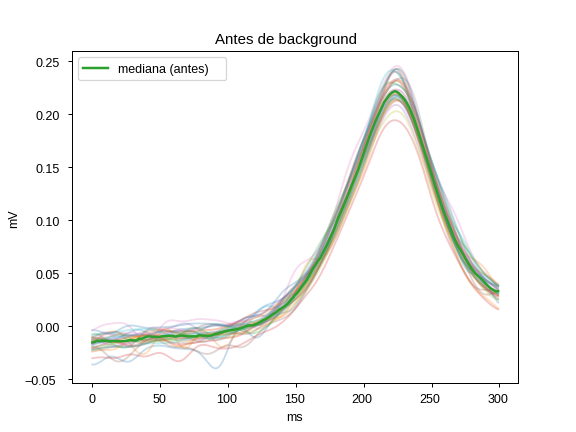

<IPython.core.display.Javascript object>


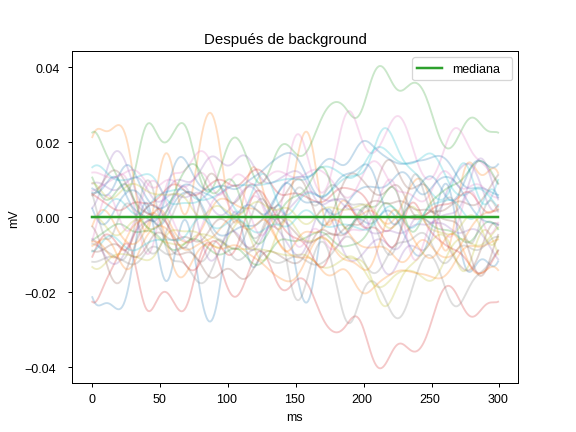

In [43]:
k = 0  # segmento a inspeccionar
L = ST_segments.shape[2]
t_ms = np.linspace(0, 300, L, endpoint=False)

plt.figure()
for j in range(ST_segments.shape[1]):
    plt.plot(t_ms, ST_segments[k, j], alpha=0.25)
plt.plot(t_ms, np.median(ST_segments[k], axis=0), lw=2, label='mediana (antes)')
plt.xlabel('ms'); plt.ylabel('mV'); plt.title('Antes de background')
plt.legend()
plt.show()

plt.figure()
for j in range(ST_signal.shape[1]):
    plt.plot(t_ms, ST_signal[k, j], alpha=0.25)
plt.plot(t_ms, np.median(ST_signal[k], axis=0), lw=2, label='mediana')
plt.xlabel('ms'); plt.ylabel('mV'); plt.title('Después de background')
plt.legend()
plt.savefig("Sustraccion_ST-T.png", dpi=300, bbox_inches="tight")
plt.show()


# FILTRADO DE SEGMENTOS ST-T

Filtra cada ST–T dentro de cada ventana para dejar solo 0.3–15 Hz (fase cero).

    
Parámetros
----------
ST_segments : ndarray, shape (num_segments, WindSize, L)
        Tensor de ST–T por ventanas (salida de `heartbeat_windowing`).
fs : float - Frecuencia de muestreo (Hz).
low, high : float
Corte inferior y superior en Hz (por defecto 0.3–15).
order : int -  Orden del Butterworth 

Devuelve
--------
ST_filt : ndarray, misma forma que ST_segments
        Tensor filtrado (filtrado a lo largo del eje temporal L).


In [44]:
from scipy.signal import butter, sosfiltfilt

def filtering_ST_T_segments(ST_segments, fs, low=0.3, high=15.0, order=3):
   
    segs = np.asarray(ST_segments, dtype=float)
    if segs.ndim != 3:
        raise ValueError("Se espera ST_segments con forma (num_segments, WindSize, L)")
    num, W, L = segs.shape

    nyq = 0.5 * fs
    lo = max(low, 1e-6)          # protege contra 0
    hi = min(high, nyq - 1e-6)   # protege contra Nyquist

    # Diseño en SOS y fase cero con filtfilt
    if lo <= 0 and hi < nyq:
        sos = butter(order, hi/nyq, btype='low',  output='sos')
    elif lo > 0 and hi >= nyq:
        sos = butter(order, lo/nyq, btype='high', output='sos')
    else:
        sos = butter(order, [lo/nyq, hi/nyq], btype='band', output='sos')

    # Filtrado a lo largo del tiempo dentro del ST–T 
    ST_filt = sosfiltfilt(sos, segs, axis=2)
    return ST_filt


ST_2: (37, 32, 300)   ST_filt: (37, 32, 300)


<IPython.core.display.Javascript object>


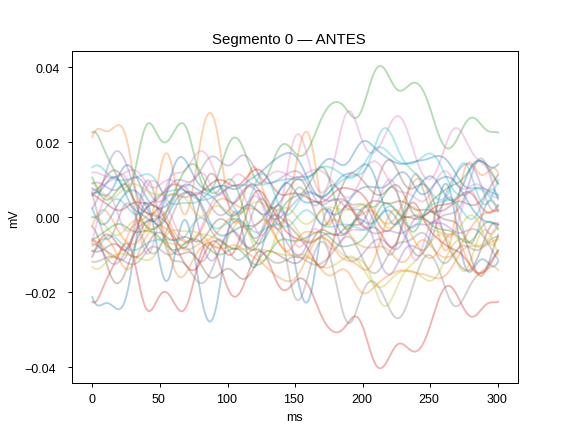

<IPython.core.display.Javascript object>


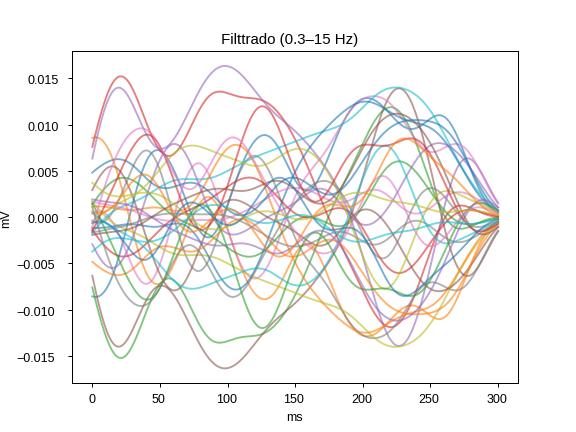

In [45]:
ST_filt = filtering_ST_T_segments(ST_signal, fs=int(record.fs), low=0.3, high=15.0, order=3)
print("ST_2:", ST_signal.shape, "  ST_filt:", ST_filt.shape)

k = 0  
L = ST_filt.shape[2]
t_ms = np.linspace(0, 300, L)

plt.figure()
for row in ST_signal[k]:
    plt.plot(t_ms, row, alpha=0.35)
plt.title(f"Segmento {k} — ANTES"); plt.xlabel("ms"); plt.ylabel("mV"); plt.show()

plt.figure()
for row in ST_filt[k]:
    plt.plot(t_ms, row, alpha=0.6)
plt.title(" Filttrado (0.3–15 Hz)"); plt.xlabel("ms"); plt.ylabel("mV")
plt.savefig("Filtrado.png", dpi=300, bbox_inches="tight")
plt.show()


<IPython.core.display.Javascript object>


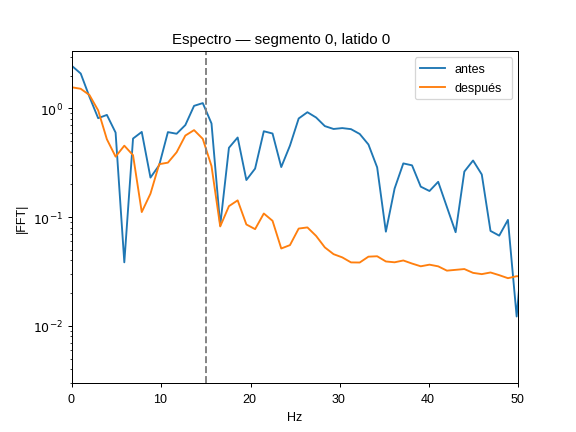

In [46]:
#COMPROBACIÓN

from numpy.fft import rfft, rfftfreq

lat = 0
nfft = 1024
f = rfftfreq(nfft, 1/fs)
X0 = np.abs(rfft(ST_signal[k,   lat], nfft))
X1 = np.abs(rfft(ST_filt[k, lat], nfft))

plt.figure()
plt.semilogy(f, X0, label="antes")
plt.semilogy(f, X1, label="después")
plt.xlim(0, 50); plt.xlabel("Hz"); plt.ylabel("|FFT|")
plt.title(f"Espectro — segmento {k}, latido {lat}")
plt.axvline(15, ls="--", color="gray"); plt.legend(); plt.show()


---------------------

------------


# MÉTODOS

## 1.- Spectral Method

El método espectral (SM) es una técnica ampliamente utilizada para la detección de alternancia de la onda T (AOT). Este método analiza las características espectrales de la señal ECG con el fin de identificar la presencia de alternancia. A continuación se presenta un resumen del procedimiento:

1. Calcular la densidad espectral de potencia (PSD) de la señal modificada.

2. Analizar los componentes espectrales en las bandas de frecuencia específicas asociadas a la alternancia.

3. Aplicar un criterio de umbral para determinar la presencia o ausencia de alternancia en función de las características espectrales observadas.

In [52]:
def SM_TWA(M_Wind):


    M = len(M_Wind['0'])
    N = len(M_Wind['0'][0])

    L = int(2 ** np.ceil(np.log2(M)))  


    PSD_BeatSeries = np.abs(np.fft.fft(M_Wind['0'], L, axis=0)) ** 2
    AverPSD = np.mean(PSD_BeatSeries, axis=1) / (M * N)

    noise_band = AverPSD[int(0.66 * ((L / 2)-1)):int(0.96 * ((L / 2)-1))]


    noise_mean = np.mean(noise_band)
    noise_std = np.std(noise_band)

    T = AverPSD[1 + int(((L / 2)-1))]

    K_score = (T - noise_mean) / (noise_std + 1e-12)

    if K_score > 0:
        Valt = np.sqrt(T - noise_mean) / np.sqrt(M)  
    else:
        Valt = 0



    return AverPSD, K_score, Valt


### Spectral Method - Calculate K-score for each signal

K_score es una variable que representa los valores TWAR (T-Wave Alternans Ratio) obtenidos mediante el Método Espectral. Es una medida utilizada para cuantificar la presencia de alternancia de la onda T en la señal ECG. El valor de K_score se calcula a partir de la estimación de la densidad espectral de potencia y de las características de ruido de la señal.

El valor específico de K_score indica la significancia de la alternancia de la onda T en el segmento analizado. Un K_score más alto sugiere una mayor presencia de alternancia, mientras que un valor más bajo indica una alternancia débil o despreciable. El umbral utilizado para determinar la presencia de alternancia puede variar dependiendo de la aplicación concreta o de los criterios definidos por el investigador.


---

El $V_{alt}$, medido en $\mu$V, representa la raíz cuadrada de la potencia de alternancia, que se define como la diferencia entre la potencia en la frecuencia de alternancia (0.5 ciclos/latido) y la potencia en las frecuencias de ruido (0.44 y 0.49 ciclos/latido). Además, corresponde a la raíz cuadrática media (RMS) de la diferencia de voltaje entre el latido medio global y los latidos de numeración impar o par.

In [57]:
nseg = ST_filt.shape[0]
K_scores = np.full(nseg, np.nan, dtype=float)
Valt_uv  = np.full(nseg, np.nan, dtype=float)   # Valt en µV

for i, signal in enumerate(ST_filt):

    AverPSD, k_score, Valt_est = SM_TWA({'0': signal})
    K_scores[i] = k_score

    Valt_uv[i] = float(Valt_est) * 1000.0

K_max = np.max(K_scores)
K_p95 = np.percentile(K_scores, 95)
Valt_max = np.max(Valt_uv)
Valt_med = np.median(Valt_uv)

print("K_max:", K_max)
print("K_p95:", K_p95)
print("Valt_max:", Valt_max)
print("Valt_med:", Valt_med)


len_K = len(K_scores)
len_Valt = len(Valt_uv)
print(f"Segmentos: {nseg} | len(K_scores)={len_K} | len(Valt_uv)={len_Valt}")


K_max: 14.392528694799863
K_p95: 7.9851238253052905
Valt_max: 0.23954955162100044
Valt_med: 0.055591247406596156
Segmentos: 37 | len(K_scores)=37 | len(Valt_uv)=37


In [58]:
print(K_scores)

[-1.55326966 -0.34017855 -0.08319998  1.12780315  0.02295313  1.5865241
  3.76891783  3.55072339 -0.05431062  3.03646207  4.82571065  0.5187185
 -0.3610779  -3.12630847 -0.60234212 -1.0532375  -0.03708701 -0.1519252
  1.45388219  0.66027614 -1.2456461   3.67247326  2.2366407   0.7763848
  0.81452273 -2.26172966 -1.27791718 -0.81066175  3.59127469  4.19962228
 -1.13098534 -0.07013798  8.6041397   7.83036986 14.39252869  3.00905766
  2.29054943]


In [204]:
DR3    = np.mean(K_scores > 3)                    # Detection Ratio
K_p95  = np.nanpercentile(K_scores, 95)           # percentil 95
K_med  = np.nanmedian(K_scores)

In [205]:
import numpy as np

K = np.array(K_scores, dtype=float)

print("Número de segmentos:", K.size)
print("K min:", np.nanmin(K))
print("K max:", np.nanmax(K))
print("K median:", np.nanmedian(K))
print("K q25 / q75:", np.nanpercentile(K, 25), "/", np.nanpercentile(K, 75))
print("K p95:", np.nanpercentile(K, 95))

print("Proporción K > 3 :", np.mean(K > 3)*100)
print("Proporción K > 6 :", np.mean(K > 6)*100)
print("Proporción K > 10:", np.mean(K > 10)*100)


Número de segmentos: 37
K min: -3.1263084712055282
K max: 14.392528694799863
K median: 0.6602761413654309
K q25 / q75: -0.3610779018080639 / 3.036462072031402
K p95: 7.9851238253052905
Proporción K > 3 : 29.72972972972973
Proporción K > 6 : 8.108108108108109
Proporción K > 10: 2.7027027027027026


## 2.- LLR method

Esta función aplica el método Laplacian Likelihood Ratio para detectar AOT.
Reportado en: Juan Pablo Martínez et al., "Characterization of repolarization alternans during ischemia: Time-Course and spatial analysis," IEEE Trans. Biomed. Eng., Vol. 53, Nº 4, abril de 2006.

Parámetros de entrada:

- M_Wind: matriz que contiene la señal correspondiente a una ventana.

- D: tasa de reducción de datos, recomendada con un valor de 8.

Parámetros de salida:

- Valt_est: estimación del voltaje de AOT (en µV).

- Valt_wave_est: estimación por máxima verosimilitud (ML) de la onda alternante (en µV).

- T: parámetro de significancia estadística.

In [66]:
import numpy as np
from scipy import signal
from scipy.signal import resample


def LLR_method(M_Wind, D):
    
    X_decimated = signal.resample(M_Wind.T, int(len(M_Wind.T)/D)).T
    M = M_Wind.shape[0]  
    P = X_decimated.shape[1]
    Alt_matrix = np.tile(((-np.ones(M))**(np.arange(M))),(P,1)).T
    CompDem_X = X_decimated* Alt_matrix
    Valt_est_wave = np.median(CompDem_X, axis=0)
    Valt_est = np.sqrt(np.mean(Valt_est_wave**2))
    T_series = np.zeros(Valt_est_wave.size)

    for p in range(len(T_series)):
        aux = CompDem_X[:, p]
        if Valt_est_wave[p] < 0:
            T_series[p] = 2 * np.sum(np.abs(aux[(aux < 0) & (aux > Valt_est_wave[p])]))
        else:
            T_series[p] = 2 * np.sum(abs(aux[(aux > 0) & (aux < Valt_est_wave[p])]))
     
    MLE_noise = np.sum(np.sum(np.abs(CompDem_X - Valt_est_wave)))
    MLE_noise = float(MLE_noise)
    if (not np.isfinite(MLE_noise)) or (MLE_noise <= 0.0):
        MLE_noise = 1e-12  
    
    T = np.sum(T_series) / MLE_noise

    
    return Valt_est, Valt_est_wave, T

In [67]:
D = 8  # tasa de reducción propuesta en el paper
num_seg = ST_filt.shape[0]

T_vals   = np.zeros(num_seg)   # estadístico T por segmento
Valt_uv  = np.zeros(num_seg)   # amplitud alternante estimada (µV)
waves_uv = []                  # onda alternante estimada por segmento (µV), long ≈ L/D

for k in range(num_seg):
    Valt_est, Valt_wave_est, T = LLR_method(ST_filt[k], D)  
    T_vals[k]  = T
    Valt_uv[k] = Valt_est * 1000.0       #  mV → µV
    waves_uv.append(Valt_wave_est * 1000.0)


In [68]:
print(T_vals)

[0.03067948 0.02368545 0.03429379 0.03835099 0.01803564 0.09441349
 0.13702419 0.07554861 0.02657964 0.03700979 0.10705524 0.08744745
 0.02649444 0.02563658 0.04994907 0.0422367  0.02393963 0.02123654
 0.0625423  0.06414294 0.02819758 0.03600059 0.02766737 0.03200342
 0.03535523 0.0549185  0.02115016 0.02157771 0.06318207 0.07640557
 0.02315495 0.02616968 0.08673047 0.11308531 0.13158261 0.12750467
 0.09091443]


In [69]:
print (Valt_uv)

[1.21077675 0.94463989 1.17369067 1.46887228 1.09332153 2.31542783
 2.49507934 1.77862606 1.14219066 2.01089528 3.72022437 3.71091222
 2.35867795 2.12804575 2.61346087 1.82601933 1.35293414 1.43052488
 2.33251354 3.09257216 1.62744988 1.43762516 1.29416684 1.15905861
 1.34235481 1.56019518 1.03825992 1.18608275 2.13653108 2.43238952
 1.46253731 1.80170065 2.90774978 2.87987645 2.11870752 2.0233772
 1.84143311]


In [70]:
print(f"T (LLR) — max={T_vals.max():.2f}, mediana={np.median(T_vals):.2f}")
print(f"Valt (LLR, µV) — max={Valt_uv.max():.1f}, mediana={np.median(Valt_uv):.1f}")
print(f"T95 = {float(np.nanpercentile(T_vals, 95))}")

T (LLR) — max=0.14, mediana=0.04
Valt (LLR, µV) — max=3.7, mediana=1.8
T95 = 0.12832025501208585


# APLICAR A TODO EL REGISTRO

### Elegimos una derivación más conveniente para la detección de picos R

In [71]:
def pick_rpeaks_with_fallback(rec, fs, preferred_idx=4, bp_lo=5, bp_hi=15, trim_sec=2.0, min_r=4):
    """
    Devuelve (ref_used_idx, r_ref) eligiendo la derivación con más R válidos.
    Prioriza preferred_idx (5ª derivación); si no llega a min_r, busca en todas las derivaciones.
    """
    n_leads = rec.n_sig

    def r_on_lead(idx):
        y_bp = bandpass_filter(rec.p_signal[:, idx], bp_lo, bp_hi, fs, trim_sec=trim_sec)
        r     = rpeaks_ref_from_lead(y_bp, fs)
        return r

    # Intento en la derivación preferida
    r_pref = r_on_lead(preferred_idx)
    if r_pref.size >= min_r:
        return preferred_idx, r_pref

    # Búsqueda en todas las derivaciones y elección de la mejor (más R)
    best_idx, best_r_count = None, -1
    best_r = None
    for li in range(n_leads):
        r_i = r_on_lead(li)
        if r_i.size > best_r_count:
            best_r_count = r_i.size
            best_idx = li
            best_r = r_i

    # Si aun así no hay suficientes R, se devuelve vacío para saltar el registro
    if best_r is None or best_r.size < min_r:
        return preferred_idx, np.array([], dtype=int)

    return best_idx, best_r


In [72]:
def qrs_leak_score(STT, fs):
    """% de fuga de QRS en las ventanas ST–T.
    ~100% = fuga alta (energía parecida al inicio y al resto)
    <<100% = ST–T limpia; >>100% = posible desalineación/artefacto.
    """
    if STT.size == 0:
        return np.nan
    L40 = int(0.040*fs)  # 40 ms
    L40 = max(L40, 1)
    e0 = float(np.mean(np.abs(STT[:, :L40])))
    e_mid = float(np.mean(np.abs(STT[:, L40:]))) + 1e-9
    return float(100.0 * e0 / e_mid)

### Aplicamos todo lo hecho anteriormente en cada uno de los registros

In [5]:
import pickle, os


# Caché 

PIPE_VERSION = "v50"   # versión actual
CACHE_DIR = "cache_staffiii_v50"
os.makedirs(CACHE_DIR, exist_ok=True)


#  parámetros 
base = "/home/alumnos/lauramll/Escritorio/TFG/staff_III/staffiii_database/data"       
record_names = sorted({f.split(".")[0] for f in os.listdir(base) if f.endswith(".hea")})
ref_lead_idx = 4                         # 5ª derivación (0-based)
trim_sec = 2.0                           # recorte final 
WindSize, WindStep = 32, 8               # enventanado

# contenedores de resultados
results = {}

# ---------- loop principal ----------
for name in record_names:
    
    
    # RUTA DE CACHÉ PARA ESTE REGISTRO 
    cache_path = os.path.join(CACHE_DIR, f"{name}.pkl")
    
    #  CACHÉ: si ya existe, comprobar versión y BW 
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            cached = pickle.load(f)

        if cached.get("pipe_version") == PIPE_VERSION and cached.get("bw_applied", False):
            results[name] = cached
            print(f"{name}: cargado de caché (PIPE={PIPE_VERSION}).")
            continue
        else:
            print(f"{name}: caché obsoleta. Recalculo con PIPE={PIPE_VERSION}…")

        
        
    try:
        rec = wfdb.rdrecord(os.path.join(base, name),
                            ignore_skew=True, warn_empty=False)
    
    except Exception as e:
        print(f"{name}: no se pudo leer ({e}), salto.")
        continue
        
    
    fs = int(rec.fs)
    n_leads = rec.n_sig
    
    
    
    # R-peaks con fallback de derivación
    ref_used_idx, r_ref = pick_rpeaks_with_fallback(
        rec, fs, preferred_idx=ref_lead_idx, bp_lo=0.5, bp_hi=40, trim_sec=2.0, min_r=4)

    if r_ref.size < 4:
        print(f"{name}: muy pocos R válidos ({r_ref.size}) en cualquier derivación, salto.")
        continue

    
    
    
    r_by_lead = {}
    per_lead = {}
    bw_ok = False 
        
        
    # Procesar cada derivación con sus rpeaks y el pipeline ST–T
    for li in range(n_leads):
        
        # señal “cruda” para ST–T (centrada + recortada)
        y1 = bandpass_filter(rec.p_signal[:, li], 0.5, 40, fs, trim_sec=2.0)
        
        #usa los rpeaks de la lead de referencia
        r_by_lead[li] = r_ref[r_ref < len(y1)] 
        
        #  Eliminación de línea de base a nivel de señal 
        try:
            bw = bw_elimination(y1, r_by_lead[li], fs)   # usa R de esa derivación
            y2 = y1 - bw   
            bw_ok = True
        except Exception as e:
            pass


        #  ST–T (funciones) 
        STT, ST_on = ST_T_delineation(y2, r_by_lead[li], fs)
        
        # Cálculo del QRS leakage score 
        try:
            score = qrs_leak_score(STT, fs)
        except Exception:
            score = np.nan
        
        
        if STT.size == 0:
            per_lead[li] = {"n_segments": 0}
            continue
            
            
        # funciones 

        STT_al, ST_on_al, shifts = ST_T_alignment(STT, ST_on, y2, fs)  
        ST_segments, ST_on_by_seg, _ = heartbeat_windowing(STT_al, ST_on_al, WindSize, WindStep)
        ST_bg = background_subtraction(ST_segments, WindSize)    
        ST_filt = filtering_ST_T_segments(ST_bg, fs, low=0.3, high=15.0, order=3)

        
       
        def _seg_good(seg):
            return (np.isfinite(seg).all()
                and seg.shape[1] >= 20
                and 1e-6 < np.std(seg) < 5e3)

        good_mask = np.array([_seg_good(ST_filt[k]) for k in range(ST_filt.shape[0])], dtype=bool)

        if not np.any(good_mask):
            per_lead[li] = {
                "n_segments": int(ST_filt.shape[0]),
                "twa_uv":      np.array([]),
                "K_scores":    np.array([]),
                "LLR_T":       np.array([]),
                "LLR_Valt":    np.array([]),
                "K_max":       np.nan,
                "TWA_med":     np.nan,
                "Valt_med":    np.nan,
                "n_seg_ok":    0,
                "n_seg_bad":   int(ST_filt.shape[0]),
            }
            continue

        # filtra segmentos válidos una sola vez
        ST_filt = ST_filt[good_mask]

        
        #  métricas 
        
        def _seg_good(seg):
            return (np.isfinite(seg).all()
                and seg.shape[1] >= 20
                and 1e-6 < np.std(seg) < 5e3)

        good_mask = np.array([_seg_good(ST_filt[k]) for k in range(ST_filt.shape[0])])
        
        n_seg_total = int(ST_filt.shape[0])

        if not np.any(good_mask):
            per_lead[li] = {
                "n_segments": n_seg_total,
                "K_scores":    np.array([]),
                "LLR_T":       np.array([]),
                "LLR_Valt":    np.array([]),
                "K_max":       np.nan,
                "K_p95":       np.nan,
                "K_med":       np.nan,
                "Valt_SM_med": np.nan, 
                "Valt_SM_max": np.nan, 
                "K_q25":       np.nan,
                "K_q75":       np.nan,
                "K_iqr":       np.nan,
                "K_hi":        np.nan,
                "Vm_med":    np.nan,
                "Vm_max":    np.nan,
                "LLR_T_med":   np.nan,
                "LLR_T_max":   np.nan,
                "QRS_leak_score": score,
                "n_seg_ok":    0,
                "n_seg_bad":   n_seg_total,
            }
            continue
        
        ST_filt = ST_filt[good_mask]
        n_seg_ok = int(ST_filt.shape[0])
        n_seg_bad = n_seg_total - n_seg_ok

        # Spectral Method (K-score por segmento)
        K_scores = np.full(n_seg_ok, np.nan, dtype=float)
        Valt_SM_uv = np.full(n_seg_ok, np.nan, dtype=float)  # V_alt de SM en µV
        
        for k in range(n_seg_ok):
            seg = ST_filt[k]
                            
            _, k_score, Valt_mV = SM_TWA({'0': seg})   

            if np.isfinite(k_score):
                K_scores[k] = float(k_score)
            
            # V_alt ( de mV a µV)
            Valt_SM_uv[k] = float(Valt_mV * 1000.0)

        
        if np.any(np.isfinite(K_scores)):
            K_med = float(np.nanmedian(K_scores))
            K_q25 = float(np.nanpercentile(K_scores, 25))
            K_q75 = float(np.nanpercentile(K_scores, 75))
            K_iqr = K_q75 - K_q25

            if np.isfinite(K_iqr) and K_iqr > 0:
                K_hi = float(K_med + 10.0 * K_iqr)

            else:
                K_hi = np.nan
            
        else:
            K_med = K_q25 = K_q75 = K_iqr = K_hi = np.nan        
            
        
        Valt_SM_med = float(np.nanmedian(Valt_SM_uv)) if Valt_SM_uv.size and not np.all(np.isnan(Valt_SM_uv)) else np.nan
        Valt_SM_max = float(np.nanmax(Valt_SM_uv)) if Valt_SM_uv.size and not np.all(np.isnan(Valt_SM_uv)) else np.nan
       
            
            
        # proporciones de segmentos positivos por K 
        if np.any(np.isfinite(K_scores)):
            valid_mask = np.isfinite(K_scores)
            n_valid = int(valid_mask.sum())

            if n_valid > 0:
                DR3  = float(np.mean(K_scores[valid_mask] > 3.0))    # % seg con K>3
                DR6  = float(np.mean(K_scores[valid_mask] > 6.0))    # % seg con K>6
                DR10 = float(np.mean(K_scores[valid_mask] > 10.0))   # % seg con K>10
            else:
                DR3 = DR6 = DR10 = np.nan
        else:
            DR3 = DR6 = DR10 = np.nan
                

        # LLR por segmento
        T_vals = np.full(ST_filt.shape[0], np.nan, dtype=float)  # estadístico T por segmento
        Vm   = np.full(ST_filt.shape[0], np.nan, dtype=float) # amplitud alternante estimada (µV)
        waves_uv = []  # onda alternante estimada por segmento (µV), long ≈ L/D
        
        for k in range(ST_filt.shape[0]):
            seg = ST_filt[k]
            good = (np.isfinite(seg).all() #filtrado de calidad
                and seg.shape[1] >= 20
                and 1e-6 < np.std(seg) < 5e3)
            
            if good:
                Vm[k], Vm_wave_est, T_vals[k] = LLR_method(seg, D=8)
                Vm[k] *= 1000.0  # mV -> µV
                waves_uv.append(Vm_wave_est * 1000.0)
                # por si LLR devuelve algo no finito:
                if not np.isfinite(T_vals[k]): T_vals[k] = np.nan
                if not np.isfinite(Vm[k]):   Vm[k]   = np.nan

                
        # agregados robustos 
        Vm_med = float(np.nanmedian(Vm)) if (Vm.size   and not np.all(np.isnan(Vm)))  else np.nan
        Vm_max = float(np.nanmax(Vm)) if (Vm.size   and not np.all(np.isnan(Vm)))  else np.nan
        T_med    = float(np.nanmedian(T_vals)) if T_vals.size and not np.all(np.isnan(T_vals)) else np.nan
        T_max    = float(np.nanmax(T_vals)) if T_vals.size and not np.all(np.isnan(T_vals)) else np.nan
        
        
        
        
        per_lead[li] = {
            "n_segments": int(ST_filt.shape[0]),
            "K_scores":    K_scores,
            "LLR_T":       T_vals,
            "LLR_Vm":    Vm,
            "K_max":       (float(np.nanmax(K_scores)) if K_scores.size and not np.all(np.isnan(K_scores)) else np.nan),
            "K_p95":       (float(np.nanpercentile(K_scores, 95)) if K_scores.size and not np.all(np.isnan(K_scores)) else np.nan),
            "K_med":       float(K_med) if np.isfinite(K_med) else np.nan,
            "Valt_SM_med": Valt_SM_med,   
            "Valt_SM_max": Valt_SM_max, 
            "K_q25":       float(K_q25) if np.isfinite(K_q25) else np.nan,
            "K_q75":       float(K_q75) if np.isfinite(K_q75) else np.nan,
            "K_iqr":       float(K_iqr) if np.isfinite(K_iqr) else np.nan,
            "K_hi":        float(K_hi)  if np.isfinite(K_hi)  else np.nan,
            "DR3":         float(DR3)   if np.isfinite(DR3)   else np.nan,
            "DR6":         float(DR6)   if np.isfinite(DR6)   else np.nan,
            "DR10":        float(DR10)  if np.isfinite(DR10)  else np.nan,
            "Vm_med":    Vm_med,
            "Vm_max":    Vm_max,
            "LLR_T_med":   T_med,
            "LLR_T_max":   T_max,
            "QRS_leak_score": score,
            "n_seg_ok":    n_seg_ok,
            "n_seg_bad":   n_seg_bad,
        }

    results[name] = {
        "fs": fs,
        "r_ref_count": int(len(r_ref)),
        "ref_lead_used": int(ref_used_idx),
        "r_by_lead": r_by_lead,
        "per_lead": per_lead,
        "pipe_version": PIPE_VERSION,
        "bw_applied": bw_ok
    }

    
    # Guardar caché del registro 
    with open(cache_path, "wb") as f:
        pickle.dump(results[name], f, protocol=4)

    ref_lead_res = per_lead.get(ref_used_idx, {"n_segments": 0})

    
    print(
        f"{name}: R={len(r_ref)} | seg(ref)={ref_lead_res['n_segments']} "
        f"| seg_ok(ref)={ref_lead_res.get('n_seg_ok', np.nan)} "
        f"| Kmax(ref)={ref_lead_res.get('K_max', np.nan):.2f} "
        f"| Kp95(ref)={ref_lead_res.get('K_p95', np.nan):.2f} "
        f"| K_med(ref)={ref_lead_res.get('K_med', np.nan):.2f} "
        f"| Valt_SM_med(ref)={ref_lead_res.get('Valt_SM_med', np.nan):.2f} µV "
        f"| Valt_SM_max(ref)={ref_lead_res.get('Valt_SM_max', np.nan):.2f} µV "
        f"| K_q25(ref)={ref_lead_res.get('K_q25', np.nan):.2f} "
        f"| K_q75(ref)={ref_lead_res.get('K_q75', np.nan):.2f} "
        f"| K_iqr(ref)={ref_lead_res.get('K_iqr', np.nan):.2f} "
        f"| K_hi(ref)={ref_lead_res.get('K_hi', np.nan):.2f} "
        f"| DR3(ref)={ref_lead_res.get('DR3', np.nan):.2f} "
        f"| DR6(ref)={ref_lead_res.get('DR6', np.nan):.2f} "
        f"| Vm_med(ref)={ref_lead_res.get('Vm_med', np.nan):.2f} µV "
        f"| Vm_max(ref)={ref_lead_res.get('Vm_max', np.nan):.2f} µV "
        f"| LLR_T_med(ref)={ref_lead_res.get('LLR_T_med', np.nan):.2f} "
        f"| LLR_T_max(ref)={ref_lead_res.get('LLR_T_max', np.nan):.2f} "
        f"| QRS_leak(ref)={ref_lead_res.get('QRS_leak_score', np.nan):.1f}% "
        f"(ref_used={ref_used_idx})"
    )
    


001a: cargado de caché (PIPE=v50).
001b: cargado de caché (PIPE=v50).
001c: cargado de caché (PIPE=v50).
001d: cargado de caché (PIPE=v50).
002a: cargado de caché (PIPE=v50).
002b: cargado de caché (PIPE=v50).
002c: cargado de caché (PIPE=v50).
002d: cargado de caché (PIPE=v50).
002e: cargado de caché (PIPE=v50).
002f: cargado de caché (PIPE=v50).
003a: cargado de caché (PIPE=v50).
003b: cargado de caché (PIPE=v50).
003c: cargado de caché (PIPE=v50).
003d: cargado de caché (PIPE=v50).
003e: cargado de caché (PIPE=v50).
004a: cargado de caché (PIPE=v50).
004b: cargado de caché (PIPE=v50).
004c: cargado de caché (PIPE=v50).
004d: cargado de caché (PIPE=v50).
005a: cargado de caché (PIPE=v50).
005b: cargado de caché (PIPE=v50).
005c: cargado de caché (PIPE=v50).
005d: cargado de caché (PIPE=v50).
006a: cargado de caché (PIPE=v50).
006b: cargado de caché (PIPE=v50).
006c: cargado de caché (PIPE=v50).
006d: cargado de caché (PIPE=v50).
006e: cargado de caché (PIPE=v50).
007a: cargado de cac

NameError: name 'pick_rpeaks_with_fallback' is not defined

In [74]:

import os, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd

CACHE_DIR = "cache_staffiii_v50"  

def _safe(v, default=np.nan):
    try:
        return v if (v is not None and not (isinstance(v, float) and math.isnan(v))) else default
    except Exception:
        return default

def list_cached_records(cache_dir):
    p = Path(cache_dir)
    return sorted([q.stem for q in p.glob("*.pkl")])

def load_cached_record(cache_dir, name):
    pkl = Path(cache_dir) / f"{name}.pkl"
    if not pkl.exists(): return None
    try:
        with open(pkl, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"[WARN] No se pudo leer {pkl.name}: {e}")
        return None

def make_summary_df(cache_dir):
    rows = []
    for name in list_cached_records(cache_dir):
        d = load_cached_record(cache_dir, name)
        if not d: 
            continue
        li = d.get("ref_lead_used")
        per_lead = d.get("per_lead") or {}
        ref = per_lead.get(li, {})
        rows.append({
            "record": name,
            "fs": _safe(d.get("fs")),
            "r_ref_count": _safe(d.get("r_ref_count")),
            "ref_lead_used": _safe(li),
            "n_segments": int(ref.get("n_segments") or 0),
            "K_max": _safe(ref.get("K_max")),
            "K_p95": _safe(ref.get("K_p95")),
            "Valt_SM_med": _safe(ref.get("Valt_SM_med")), 
            "Valt_SM_max": _safe(ref.get("Valt_SM_max")),
            "DR3": _safe(ref.get("DR3")),
            "Vm_med_uV": _safe(ref.get("Vm_med")),
            "LLR_T_med": _safe(ref.get("LLR_T_med")),
            "LLR_T_max": _safe(ref.get("LLR_T_max")),
            "QRS_leak_score_%": _safe(ref.get("QRS_leak_score")),
            "bw_applied": bool(d.get("bw_applied", False)),
            "pipe_version": d.get("pipe_version", None),
        })
    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["K_max", "K_p95"], ascending=[False, False], ignore_index=True)
    return df

def show_record_detail(cache_dir, name):
    d = load_cached_record(cache_dir, name)
    if not d:
        raise FileNotFoundError(f"No existe caché para {name}")
    per_lead = d.get("per_lead") or {}
    rows = []
    for li, dd in per_lead.items():
        rows.append({
            "lead": li,
            "n_segments": int(dd.get("n_segments") or 0),
            "K_max": _safe(dd.get("K_max")),
            "K_p95": _safe(dd.get("K_p95")),
            "Valt_SM_med": _safe(dd.get("Valt_SM_med")), 
            "Valt_SM_max": _safe(dd.get("Valt_SM_max")), 
            "Valt_med_uV": _safe(dd.get("Valt_med")),
            "LLR_T_med": _safe(dd.get("LLR_T_med")),
            "LLR_T_max": _safe(dd.get("LLR_T_max")),
            "QRS_leak_score_%": _safe(dd.get("QRS_leak_score")),
        })
    df = pd.DataFrame(rows).sort_values(["K_max", "K_p95"], ascending=[False, False], ignore_index=True)
    return df

# Ejemplo
df = make_summary_df(CACHE_DIR)
display(df.head(20))  # resumen por registro (usa la derivación de referencia guardada)

if not df.empty:
    name = df.iloc[0]["record"]
    det = show_record_detail(CACHE_DIR, name)
    print("Detalle por derivación para:", name)
    display(det)

    

record    fs  r_ref_count  ref_lead_used  n_segments         K_max  \
0    030a  1000          371              4          43  48378.242529   
1    033b  1000          264              4          29  10868.749580   
2    030b  1000          356              4          41   4146.641466   
3    088b  1000          395              4          46   2745.949055   
4    048c  1000          892              4         108   1366.818416   
5    073c  1000          895              4         108    919.363022   
6    108c  1000          800              4          96    845.941503   
7    035c  1000          691              4          83    754.067840   
8    025c  1000          970              4         118    695.162137   
9    106c  1000         1030              4         125    511.212378   
10   074c  1000          655              4          78    467.620567   
11   033c  1000          508              4          60    428.031788   
12   042d  1000          929              4         113    418.731334   
13   016c  1000         1470              4         180    386.880474   
14   042c  1000          873              4         106    365.765578   
15   044c  1000          394              4          46    331.377983   
16   022d  1000          358              4          41    326.224999   
17   039c  1000          990              4         120    306.176464   
18   072c  1000          718              4          86    276.209378   
19   018b  1000          880              4         106    188.841589   

           K_p95  Valt_SM_med  Valt_SM_max       DR3  Vm_med_uV  LLR_T_med  \
0   27578.800395     4.653698    11.720199  0.534884   6.078826   0.004801   
1    8366.934915     3.663328     6.155382  0.620690  87.440451   0.211785   
2     136.828070     0.225204    19.768549  0.439024   4.347373   0.038353   
3     279.857062     0.090152     6.975772  0.195652   3.277510   0.037019   
4     680.088954     0.570115     7.576888  0.574074   6.218573   0.074165   
5     342.689924     0.136170    23.467814  0.351852   4.568072   0.057219   
6     156.656581     0.108011     1.155993  0.427083   2.874824   0.061674   
7     143.096609     0.255771     9.209918  0.469880   7.238703   0.045622   
8     110.161655     0.030531     0.762330  0.279661   0.945579   0.022991   
9      78.892323     0.224250     7.111953  0.400000   3.838881   0.043976   
10     33.705252     0.075135     0.905177  0.307692   3.031204   0.043671   
11     64.816480     0.064440     4.021620  0.433333   1.282509   0.042625   
12    144.505273     0.005053     1.407604  0.300885   1.918914   0.046368   
13    107.209560     0.000000     1.896607  0.244444   2.457938   0.038248   
14    127.893753     0.181994     1.339709  0.481132   3.602987   0.083021   
15    218.841712     0.095787     7.872535  0.304348   4.145440   0.041363   
16    203.170708     0.313608     2.291832  0.560976   4.912251   0.125947   
17     16.084671     0.003545     0.859218  0.141667   1.392949   0.034795   
18     77.252848     0.075335     1.645940  0.406977   2.213759   0.048035   
19     10.307673     0.000000     2.509501  0.216981   1.431798   0.031125   

    LLR_T_max  QRS_leak_score_%  bw_applied pipe_version  
0    0.223197         74.585514        True          v50  
1   12.592103         34.356149        True          v50  
2   12.270433        118.892721        True          v50  
3    2.956501         71.662640        True          v50  
4    4.906957        199.216343        True          v50  
5    6.640435        133.686320        True          v50  
6    1.123568        161.737672        True          v50  
7    2.461635        190.123006        True          v50  
8    2.491788         64.826342        True          v50  
9    2.279256         86.852318        True          v50  
10   1.055475         27.335254        True          v50  
11   4.381371         52.505090        True          v50  
12   1.825569         53.098987        True          v50  
13  

Detalle por derivación para: 030a


lead  n_segments         K_max         K_p95  Valt_SM_med  Valt_SM_max  \
0     0          43  78655.597072  40317.638700     3.078585     8.640375   
1     5          43  66395.746051  42233.668563     3.562737     9.176784   
2     4          43  48378.242529  27578.800395     4.653698    11.720199   
3     6          43  37554.731512  32785.606957     2.551808     6.585589   
4     7          43  22264.822826  10648.472460     2.573858     6.974669   
5     3          43  15228.847466   6838.694374     2.856968     8.249132   
6     1          43  10367.653832   4189.000345     1.869299     5.476311   
7     2          43   1941.029933    306.266467     0.481948     1.589636   
8     8          43    921.431201    388.933524     0.776025     2.585457   

   Valt_med_uV  LLR_T_med  LLR_T_max  QRS_leak_score_%  
0          NaN   0.021950   0.293869         78.685207  
1          NaN   0.010997   0.246586         73.063958  
2          NaN   0.004801   0.223197         74.585514  
3          NaN   0.009307   0.248046         68.585239  
4          NaN   0.009811   0.204755         56.333935  
5          NaN   0.011401   0.125297         81.237640  
6          NaN   0.045971   0.376414         60.767144  
7          NaN   0.071819   0.208372         46.219886  
8          NaN   0.029729   0.126101         79.342634

In [75]:
from pathlib import Path, PurePath
import pickle, numpy as np

CACHE_SELECCIONADO = "cache_staffiii_v50"

for pkl in sorted(Path(CACHE_SELECCIONADO).glob("*.pkl")):
    d = pickle.load(open(pkl, "rb"))
    name = pkl.stem
    li = d["ref_lead_used"]
    ref = d["per_lead"].get(li, {})
    print(f"{name} | fs={d['fs']} | R={d['r_ref_count']} | lead_ref={li} | "
          f"Kmax={ref.get('K_max', np.nan):.2f} | Kp95={ref.get('K_p95', np.nan):.2f} | "
          f"Valt_SM_med(ref)={ref.get('Valt_SM_med', np.nan):.2f} µV |"
          f"Valt_SM_max(ref)={ref.get('Valt_SM_max', np.nan):.2f} µV |"
          f"| DR3(ref)={ref.get('DR3', np.nan):.2f} "
          f"| DR6(ref)={ref.get('DR6', np.nan):.2f} "
          f"| Vm_med(ref)={ref.get('Vm_med', np.nan):.2f} µV "
          f"| LLR_T_med(ref)={ref.get('LLR_T_med', np.nan):.2f} "
          f"| LLR_T_max(ref)={ref.get('LLR_T_max', np.nan):.2f} "
          f"QRS_leak={ref.get('QRS_leak_score', np.nan):.1f}% | "
          f"BW={bool(d.get('bw_applied', False))}")


        

001a | fs=1000 | R=351 | lead_ref=4 | Kmax=11.96 | Kp95=5.92 | Valt_SM_med(ref)=0.05 µV |Valt_SM_max(ref)=0.34 µV || DR3(ref)=0.15 | DR6(ref)=0.05 | Vm_med(ref)=3.98 µV | LLR_T_med(ref)=0.04 | LLR_T_max(ref)=0.16 QRS_leak=102.2% | BW=True
001b | fs=1000 | R=384 | lead_ref=4 | Kmax=4.67 | Kp95=3.57 | Valt_SM_med(ref)=0.03 µV |Valt_SM_max(ref)=1.22 µV || DR3(ref)=0.14 | DR6(ref)=0.00 | Vm_med(ref)=2.53 µV | LLR_T_med(ref)=0.03 | LLR_T_max(ref)=0.11 QRS_leak=96.9% | BW=True
001c | fs=1000 | R=1032 | lead_ref=7 | Kmax=24.62 | Kp95=13.28 | Valt_SM_med(ref)=0.12 µV |Valt_SM_max(ref)=1.34 µV || DR3(ref)=0.23 | DR6(ref)=0.09 | Vm_med(ref)=5.84 µV | LLR_T_med(ref)=0.04 | LLR_T_max(ref)=0.29 QRS_leak=60.9% | BW=True
001d | fs=1000 | R=360 | lead_ref=4 | Kmax=14.30 | Kp95=13.44 | Valt_SM_med(ref)=0.00 µV |Valt_SM_max(ref)=0.53 µV || DR3(ref)=0.15 | DR6(ref)=0.12 | Vm_med(ref)=3.13 µV | LLR_T_med(ref)=0.04 | LLR_T_max(ref)=0.14 QRS_leak=88.4% | BW=True
002a | fs=1000 | R=356 | lead_ref=4 | Kmax=19

# DETECCIÓN DE ALTERNANCIA

In [76]:
import os, re, pickle, math, numpy as np, pandas as pd
from pathlib import Path


def _rows_from_mapping(mapping: dict):
    rows = []
    for name, d in mapping.items():
        li = d.get("ref_lead_used")
        per_lead = d.get("per_lead") or {}
        ref = per_lead.get(li, {})
        rows.append({
            "record": name,
            "fs": _safe(d.get("fs")),
            "r_ref_count": _safe(d.get("r_ref_count")),
            "ref_lead_used": _safe(li),
            "Kmax": _safe(ref.get("K_max")),
            "K_p95": _safe(ref.get("K_p95")),
            "K_med": _safe(ref.get("K_med")),
            "Valt_SM_med": _safe(ref.get("Valt_SM_med")), 
            "Valt_SM_max": _safe(ref.get("Valt_SM_max")),
            "DR3": _safe(ref.get("DR3")),
            "K_q25":       _safe(ref.get("K_q25")),   
            "K_q75":       _safe(ref.get("K_q75")),  
            "K_iqr":       _safe(ref.get("K_iqr")),   
            "K_hi":        _safe(ref.get("K_hi")),    
            "Vm_med_uV": _safe(ref.get("Vm_med")),
            "LLR_T_med": _safe(ref.get("LLR_T_med")),
            "LLR_T_max": _safe(ref.get("LLR_T_max")),
            "QRS_leak_score_%": _safe(ref.get("QRS_leak_score")),
            "bw_applied": bool(d.get("bw_applied", False)),
            "pipe_version": d.get("pipe_version"),
        })
    return rows

def _find_latest_cache_dir(base="."):
    # Busca carpetas tipo cache_staffiii_* y elige la más reciente por mtime
    candidates = []
    for p in Path(base).iterdir():
        if p.is_dir() and re.match(r"cache_staffiii_", p.name):
            candidates.append((p.stat().st_mtime, p))
    if not candidates:
        return None
    candidates.sort(reverse=True)
    return candidates[0][1]  # Path

def _rows_from_cache_dir(cache_dir: Path):
    rows = []
    for pkl in sorted(cache_dir.glob("*.pkl")):
        try:
            with open(pkl, "rb") as f:
                d = pickle.load(f)
        except Exception as e:
            print(f"[WARN] No se pudo leer {pkl.name}: {e}")
            continue
        name = pkl.stem
        rows.extend(_rows_from_mapping({name: d}))
    return rows

def make_df_ok_lab_auto(results_mapping=None, cache_dir_name=None, base="."):
    """
    results_mapping: dict con los resultados en memoria (si lo usas, ignora la caché).
    cache_dir_name : nombre o ruta de la carpeta de caché a usar
                     (por ejemplo 'cache_staffiii_v28').
    base           : carpeta base donde buscar la caché si cache_dir_name es relativo.
    """

    # 1) Si hay resultados en memoria, se usan y se ignora la caché
    if isinstance(results_mapping, dict) and len(results_mapping) > 0:
        rows = _rows_from_mapping(results_mapping)
        return pd.DataFrame(rows)

    # 2) Si NO hay 'results', mira la caché indicada por el usuario 
    if cache_dir_name is not None:
        cache_dir = Path(cache_dir_name)
        # Si es relativa, la resolvemos respecto a base
        if not cache_dir.is_absolute():
            cache_dir = Path(base) / cache_dir
        if not cache_dir.exists():
            raise FileNotFoundError(f"La carpeta de caché especificada no existe: {cache_dir}")
    else:
        # 3) usa la caché más reciente 
        cache_dir = _find_latest_cache_dir(base=base)
        if cache_dir is None:
            raise FileNotFoundError(
                "No encontré un 'results' en memoria ni carpetas de caché tipo 'cache_staffiii_*'."
            )

    rows = _rows_from_cache_dir(cache_dir)
    if not rows:
        raise RuntimeError(f"La carpeta {cache_dir} no contiene .pkl válidos.")
    return pd.DataFrame(rows)



In [77]:
CACHE_SELECCIONADO = "cache_staffiii_v50"

df_ok_lab = make_df_ok_lab_auto(results_mapping=None, cache_dir_name=CACHE_SELECCIONADO, base="." )

df_ok_lab = df_ok_lab.sort_values(["Kmax","K_p95"], ascending=[False, False], ignore_index=True)
df_ok_lab["paciente"] = df_ok_lab["record"].str.extract(r"(\d{3})").iloc[:,0]

display(df_ok_lab.head(20))
print(f"Registros cargados: {len(df_ok_lab)}")


record    fs  r_ref_count  ref_lead_used          Kmax         K_p95  \
0    030a  1000          371              4  48378.242529  27578.800395   
1    033b  1000          264              4  10868.749580   8366.934915   
2    030b  1000          356              4   4146.641466    136.828070   
3    088b  1000          395              4   2745.949055    279.857062   
4    048c  1000          892              4   1366.818416    680.088954   
5    073c  1000          895              4    919.363022    342.689924   
6    108c  1000          800              4    845.941503    156.656581   
7    035c  1000          691              4    754.067840    143.096609   
8    025c  1000          970              4    695.162137    110.161655   
9    106c  1000         1030              4    511.212378     78.892323   
10   074c  1000          655              4    467.620567     33.705252   
11   033c  1000          508              4    428.031788     64.816480   
12   042d  1000          929              4    418.731334    144.505273   
13   016c  1000         1470              4    386.880474    107.209560   
14   042c  1000          873              4    365.765578    127.893753   
15   044c  1000          394              4    331.377983    218.841712   
16   022d  1000          358              4    326.224999    203.170708   
17   039c  1000          990              4    306.176464     16.084671   
18   072c  1000          718              4    276.209378     77.252848   
19   018b  1000          880              4    188.841589     10.307673   

        K_med  Valt_SM_med  Valt_SM_max       DR3  ...       K_q75  \
0    4.195164     4.653698    11.720199  0.534884  ...   15.051491   
1   71.250607     3.663328     6.155382  0.620690  ...  221.556949   
2    2.927221     0.225204    19.768549  0.439024  ...    8.425987   
3    0.740167     0.090152     6.975772  0.195652  ...    2.367593   
4    4.192214     0.570115     7.576888  0.574074  ...   34.192789   
5    1.261902     0.136170    23.467814  0.351852  ...    8.488866   
6    1.245603     0.108011     1.155993  0.427083  ...   22.381125   
7    2.327415     0.255771     9.209918  0.469880  ...   13.359706   
8    0.439368     0.030531     0.762330  0.279661  ...    3.973358   
9    1.824142     0.224250     7.111953  0.400000  ...    8.488394   
10   0.355188     0.075135     0.905177  0.307692  ...    3.876517   
11   1.422978     0.064440     4.021620  0.433333  ...    5.939691   
12   0.002665     0.005053     1.407604  0.300885  ...    4.578970   
13  -0.459105     0.000000     1.896607  0.244444  ...    2.393800   
14   2.538467     0.181994     1.339709  0.481132  ...   27.444771   
15   0.643674     0.095787     7.872535  0.304348  ...   21.381479   
16  12.553525     0.313608     2.291832  0.560976  ...   87.143865   
17  -0.013461     0.003545     0.859218  0.141667  ...    1.511551   
18   1.162782     0.075335     1.645940  0.406977  ...    7.691801   
19  -0.062207     0.000000     2.509501  0.216981  ...    2.639036   

         K_iqr         K_hi  Vm_med_uV  LLR_T_med  LLR_T_max  \
0    14.837682   152.571983   6.078826   0.004801   0.223197   
1   221.878358  2290.034191  87.440451   0.211785  12.592103   
2     8.313732    86.064540   4.347373   0.038353  12.270433   
3     3.355415    34.294313   3.277510   0.037019   2.956501   
4    33.664778   340.839997   6.218573   0.074165   4.906957   
5     9.130666    92.568563   4.568072   0.057219   6.640435   
6    23.175682   233.002424   2.874824   0.061674   1.123568   
7    13.758194   139.909359   7.238703   0.045622   2.461635   
8     4.687389    47.313256   0.945579   0.022991   2.491788   
9     9.240179    94.225927   3.838881   0.043976   2.279256   
10    4.441072    44.765905   3.031204   0.043671   1.055475   
11    6.699162    68.414601   1.282509   0.042625   4.381371   
12    5.525324    55.255901   1.918914   0.046368   1.825569   
13    3.331410    32.854997   2.457938   0.038248   2.789708

Registros cargados: 516


In [78]:
df_ok_lab["CALIDAD_OK"] = (
    (df_ok_lab["QRS_leak_score_%"] <= 40) &
    np.isfinite(df_ok_lab["K_p95"]) &
    np.isfinite(df_ok_lab["LLR_T_max"])
)


df_clean = df_ok_lab[df_ok_lab["CALIDAD_OK"]].copy()

In [81]:
# UMBRALES 
UMBRAL_KMAX       = 3.0    # Spectral Method por Kmax
UMBRAL_KP95       = 3.0    # Spectral Method por K_p95
UMBRAL_VALT = 1.9  #Spectral Method por Valt
UMBRAL_LLR_T_MED  = 0.15   # estadístico GLRT (mediana)
UMBRAL_LLR_T_MAX  = 0.15   # estadístico GLRT (máximo)
UMBRAL_VM_MED   = 5.0    # µV (amplitud estimada por LLR)
UMBRAL_QRS_LEAK   = 100.0   # % máximo aceptable de fuga QRS 

# SM 
df_ok_lab["AOT_SM_Kmax"] = ((df_ok_lab["Kmax"]   >= UMBRAL_KMAX) & (df_ok_lab["QRS_leak_score_%"] <= UMBRAL_QRS_LEAK))
df_ok_lab["AOT_SM_Kp95"] = ((df_ok_lab["K_p95"]  >= UMBRAL_KP95) & (df_ok_lab["QRS_leak_score_%"] <= UMBRAL_QRS_LEAK))
df_ok_lab["AOT_VALT"]    = ((df_ok_lab["Valt_SM_max"] >= UMBRAL_VALT) & (df_ok_lab["QRS_leak_score_%"] <= UMBRAL_QRS_LEAK))
df_ok_lab["AOT_SM_any"]  = df_ok_lab[["AOT_SM_Kmax","AOT_SM_Kp95", "AOT_VALT"]].any(axis=1)



# LLR 
df_ok_lab["AOT_LLR_T_med"] = ((df_ok_lab["LLR_T_med"] >= UMBRAL_LLR_T_MED) & (df_ok_lab["QRS_leak_score_%"] <= UMBRAL_QRS_LEAK))
df_ok_lab["AOT_LLR_T_max"] = ((df_ok_lab["LLR_T_max"] >= UMBRAL_LLR_T_MAX) & (df_ok_lab["QRS_leak_score_%"] <= UMBRAL_QRS_LEAK))
df_ok_lab["AOT_LLR_T_any"] = df_ok_lab[["AOT_LLR_T_med","AOT_LLR_T_max"]].any(axis=1)
df_ok_lab["AOT_Vmed_LLR"]  = (df_ok_lab["Vm_med_uV"] >= UMBRAL_VM_MED) & (df_ok_lab["QRS_leak_score_%"] <= UMBRAL_QRS_LEAK)


# SM robusto
df_ok_lab["AOT_SM"] = (
    df_ok_lab["AOT_SM_Kmax"] &
    df_ok_lab["AOT_SM_Kp95"] &
    df_ok_lab["AOT_VALT"]  ) 

# LLR robusto
df_ok_lab["AOT_LLR"] = (
    df_ok_lab["AOT_LLR_T_max"] &
    df_ok_lab["AOT_Vmed_LLR"] )

# Alternancia global 
df_ok_lab["AOT_global"] = df_ok_lab["AOT_SM"] | df_ok_lab["AOT_LLR"]


# ALTERNANCIA POR CUALQUIER CRITERIO 
cols_criterios = ["AOT_SM_Kmax", "AOT_SM_Kp95", "AOT_VALT",
    "AOT_LLR_T_med", "AOT_LLR_T_max",
    "AOT_Vmed_LLR", "AOT_SM", "AOT_LLR", "AOT_global"]
    


def _resumen_booleanos(df, cols):
    tot = len(df)
    for c in cols:
        n = int(df[c].sum())
        print(f"{c}: {n}/{tot} ({100*n/tot:.1f}%)")


print("=== Resumen por criterio (registro) ===")
_resumen_booleanos(df_ok_lab, cols_criterios )

# POR PACIENTE 
if "paciente" not in df_ok_lab.columns:
    df_ok_lab["paciente"] = df_ok_lab["record"].str.extract(r"^(\d{3})")

alt_por_paciente = (
    df_ok_lab
    .groupby("paciente")[cols_criterios ]
    .any()
    .reset_index()
)

print("\n=== Pacientes con alternancia por criterio ===")
_resumen_booleanos(alt_por_paciente, cols_criterios )


df_ok_lab.to_csv("df_ok_lab_con_AOT_todos_criterios.csv", index=False)
alt_por_paciente.to_csv("AOT_por_paciente_todos_criterios.csv", index=False)
print("\nArchivos guardados: df_ok_lab_con_AOT_todos_criterios.csv, AOT_por_paciente_todos_criterios.csv")


=== Resumen por criterio (registro) ===
AOT_SM_Kmax: 405/516 (78.5%)
AOT_SM_Kp95: 344/516 (66.7%)
AOT_VALT: 51/516 (9.9%)
AOT_LLR_T_med: 1/516 (0.2%)
AOT_LLR_T_max: 173/516 (33.5%)
AOT_Vmed_LLR: 39/516 (7.6%)
AOT_SM: 47/516 (9.1%)
AOT_LLR: 23/516 (4.5%)
AOT_global: 60/516 (11.6%)

=== Pacientes con alternancia por criterio ===
AOT_SM_Kmax: 98/104 (94.2%)
AOT_SM_Kp95: 97/104 (93.3%)
AOT_VALT: 34/104 (32.7%)
AOT_LLR_T_med: 1/104 (1.0%)
AOT_LLR_T_max: 84/104 (80.8%)
AOT_Vmed_LLR: 25/104 (24.0%)
AOT_SM: 31/104 (29.8%)
AOT_LLR: 16/104 (15.4%)
AOT_global: 36/104 (34.6%)

Archivos guardados: df_ok_lab_con_AOT_todos_criterios.csv, AOT_por_paciente_todos_criterios.csv


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")


if "paciente" not in df_ok_lab.columns:
    df_ok_lab["paciente"] = df_ok_lab["record"].str.extract(r"^(\d{3})")


def aggregate_by_patient(df, flag_cols, extra_metrics=None):
    g = df.groupby("paciente")
    any_flags = g[flag_cols].any().reset_index()
    if extra_metrics:
        meds = g[extra_metrics].median().reset_index()
        any_flags = any_flags.merge(meds, on="paciente", how="left")
    return any_flags

def summarize_flags(df, flag_cols, title="Resumen"):
    tot = len(df)
    data = []
    for c in flag_cols:
        n = int(df[c].sum())
        data.append({"criterio": c, "positivos": n, "total": tot, "pct": 100*n/tot})
    out = pd.DataFrame(data)
    out = out.sort_values("pct", ascending=False, ignore_index=True)
    print(f"{title} — total={tot}")
    display(out)
    return out

def barplot_percent(summary_df, title, ax=None):
    if ax is None: fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(data=summary_df, x="criterio", y="pct", ax=ax)
    ax.set_ylabel("% positivos")
    ax.set_xlabel("")
    ax.set_title(title)
    ax.set_ylim(0, 100)
    for p, v in zip(ax.patches, summary_df["pct"]):
        ax.annotate(f"{v:.1f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha="center", va="bottom", fontsize=11)
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
    return ax

def overlap_2x2_heatmap(df, flagA, flagB, title, ax=None):
    # Tabla de contingencia 2x2 con recuentos
    tbl = (pd.crosstab(df[flagA], df[flagB], dropna=False)
             .reindex(index=[False, True], columns=[False, True], fill_value=0))

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    else:
        fig = ax.figure

    # Heatmap con recuentos enteros
    sns.heatmap(tbl,
                annot=True,
                fmt="d",        
                cmap="Blues",
                cbar=False,
                ax=ax)

    ax.set_xlabel(f"{flagB} ")
    ax.set_ylabel(f"{flagA} ")
    ax.set_title(title)
    ax.set_xticklabels(["No", "Sí"])
    ax.set_yticklabels(["No", "Sí"])

    return fig, ax






# SM METHOD 

SM — POR REGISTRO
SM por registro — total=516


criterio  positivos  total        pct
0  AOT_SM_Kmax        405    516  78.488372
1  AOT_SM_Kp95        344    516  66.666667
2     AOT_VALT         51    516   9.883721
3       AOT_SM         47    516   9.108527

<IPython.core.display.Javascript object>


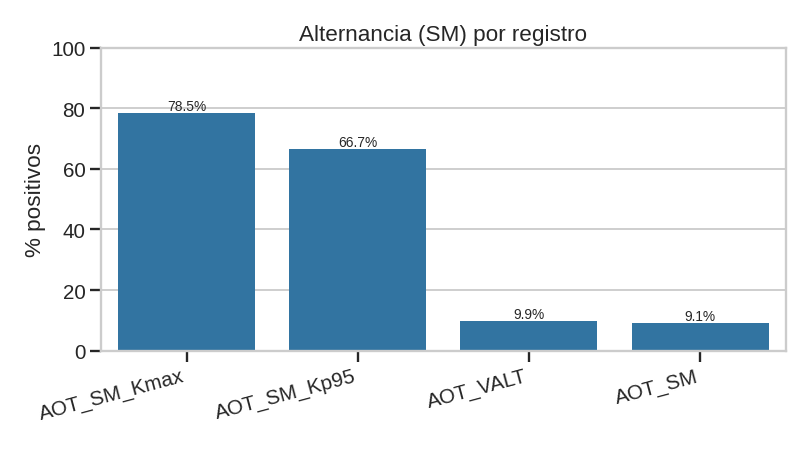

<IPython.core.display.Javascript object>


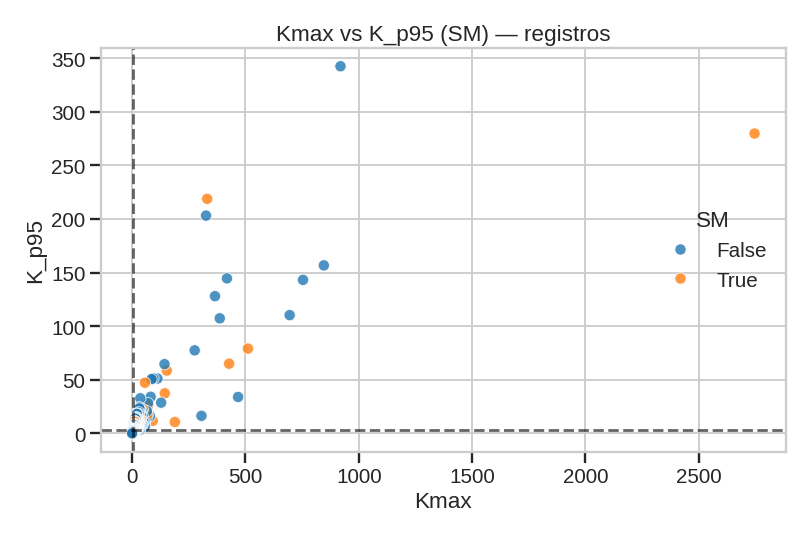


SM — POR PACIENTE
SM por paciente — total=104


criterio  positivos  total        pct
0  AOT_SM_Kmax         98    104  94.230769
1  AOT_SM_Kp95         97    104  93.269231
2     AOT_VALT         34    104  32.692308
3       AOT_SM         31    104  29.807692

<IPython.core.display.Javascript object>


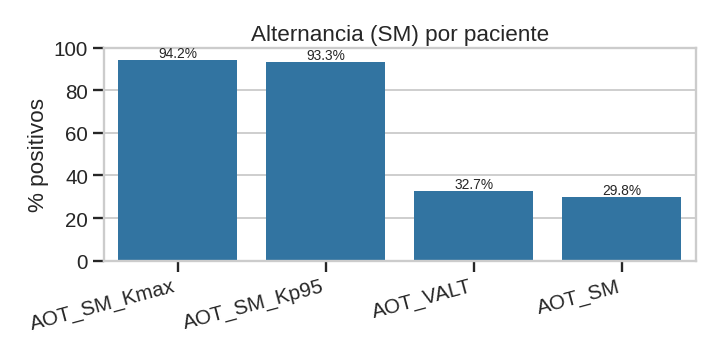

<IPython.core.display.Javascript object>


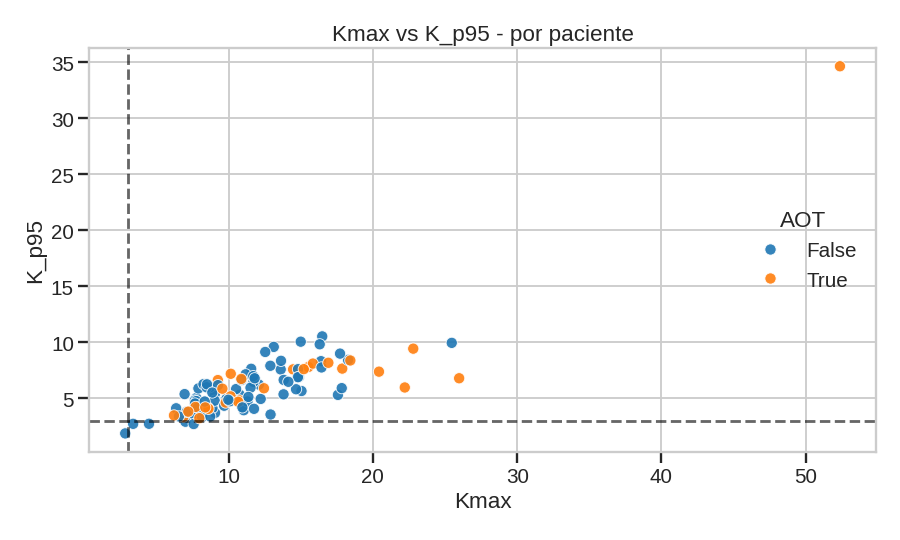

In [90]:
# Definir un subconjunto sin los outliers
df_scatter = df_ok_lab[
    (df_ok_lab["Kmax"]  < 3000) &   # límite en X
    (df_ok_lab["K_p95"] < 400)      # límite en Y
]



# criterios SM
sm_cols = ["AOT_SM_Kmax", "AOT_SM_Kp95", "AOT_VALT", "AOT_SM"]


# por registro
print("SM — POR REGISTRO")
sum_sm_reg = summarize_flags(df_ok_lab, sm_cols, title="SM por registro")



fig, ax = plt.subplots(figsize=(9,5))
barplot_percent(sum_sm_reg, "Alternancia (SM) por registro", ax=ax)
plt.tight_layout(); plt.show()

# scatter Kmax vs K_p95 con umbrales
fig, ax = plt.subplots(figsize=(9,6))
sns.scatterplot(data=df_scatter, x="Kmax", y="K_p95",
                hue="AOT_SM", alpha=0.8)
ax.axvline(UMBRAL_KMAX, ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_KP95, ls="--", c="k", alpha=0.6)
ax.set_title("Kmax vs K_p95 (SM) — registros")
plt.legend(title="SM"); plt.tight_layout()
plt.savefig("kmax_vs_kp95_scatter.png", dpi=300)
plt.show()


# --- por paciente ---
print("\nSM — POR PACIENTE")
sm_pac = aggregate_by_patient(df_ok_lab, sm_cols,
                              extra_metrics=["Kmax","K_p95"])
sum_sm_pac = summarize_flags(sm_pac, sm_cols, title="SM por paciente")


df_scatter_pac = sm_pac[
    (sm_pac["Kmax"]  < 2000) &   # límite en X
    (sm_pac["K_p95"] < 1000)      # límite en Y
]

fig, ax = plt.subplots(figsize=(8,4))
barplot_percent(sum_sm_pac, "Alternancia (SM) por paciente", ax=ax)
plt.tight_layout(); plt.show()

# dispersión de medianas por paciente
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=df_scatter_pac, x="Kmax", y="K_p95",
                hue="AOT_SM", alpha=0.9)
ax.axvline(UMBRAL_KMAX, ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_KP95, ls="--", c="k", alpha=0.6)
ax.set_title("Kmax vs K_p95 - por paciente")
plt.legend(title="AOT"); plt.tight_layout(); plt.show()


<IPython.core.display.Javascript object>


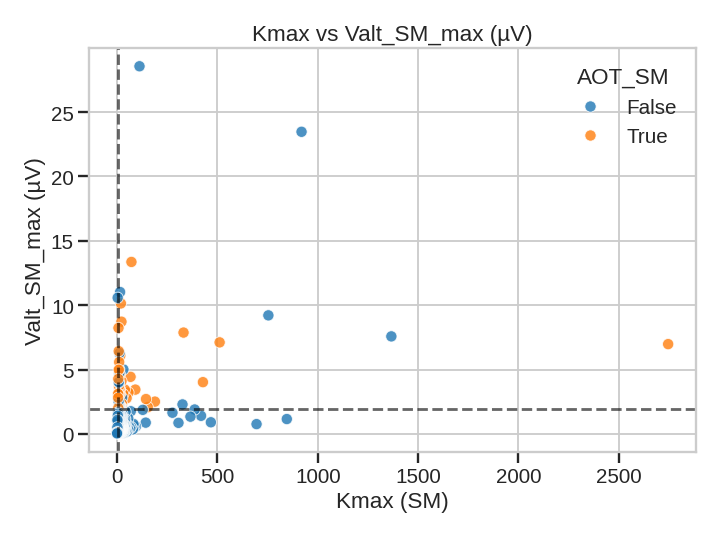

<IPython.core.display.Javascript object>


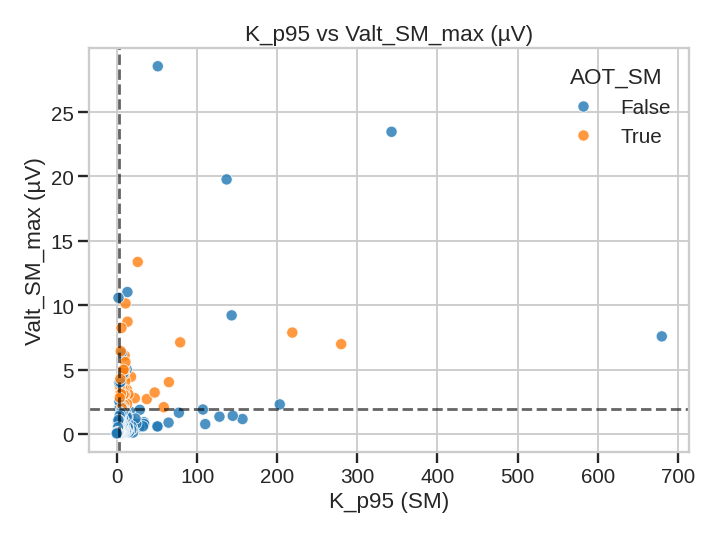

In [91]:
# Definir un subconjunto sin los outliers
scatter1 = df_ok_lab[
    (df_ok_lab["Kmax"]  < 4000) &   
    (df_ok_lab["Valt_SM_max"] < 600)      
]

# Definir un subconjunto sin los outliers
scatter2 = df_ok_lab[
    (df_ok_lab["K_p95"]  < 4000) &   # límite en X
    (df_ok_lab["Valt_SM_max"] < 600)      # límite en Y
]

# Valt_SM_max vs Kmax
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    data=scatter1,
    x="Kmax",
    y="Valt_SM_max",
    hue="AOT_SM",  
    alpha=0.8
)

ax.axvline(UMBRAL_KMAX, ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_VALT,  ls="--", c="k", alpha=0.6)

ax.set_xlabel("Kmax (SM)")
ax.set_ylabel("Valt_SM_max (µV)")
ax.set_title("Kmax vs Valt_SM_max (µV)")

plt.tight_layout()
plt.savefig("kmax_vs_valt_scatter.png", dpi=300)
plt.show()


# Valt_SM_max vs K_p95
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    data=scatter2,
    x="K_p95",
    y="Valt_SM_max",
    hue="AOT_SM",
    alpha=0.8
)

ax.axvline(UMBRAL_KP95, ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_VALT,  ls="--", c="k", alpha=0.6)

ax.set_xlabel("K_p95 (SM)")
ax.set_ylabel("Valt_SM_max (µV)")
ax.set_title("K_p95 vs Valt_SM_max (µV)")

plt.tight_layout()
plt.savefig("kp95_vs_valt_scatter.png", dpi=300)
plt.show()


<IPython.core.display.Javascript object>


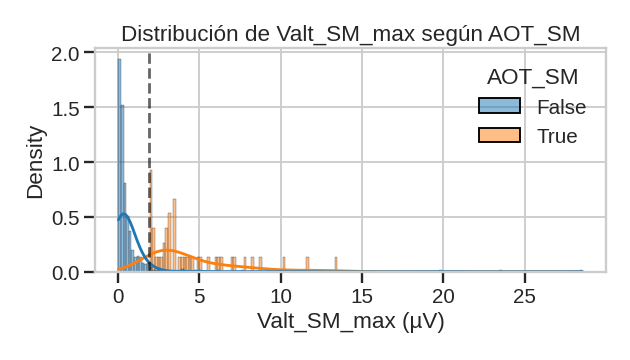

In [92]:
fig, ax = plt.subplots(figsize=(7,4))

sns.histplot(
    data=df_ok_lab,
    x="Valt_SM_max",
    hue="AOT_SM",
    kde=True,
    stat="density",
    common_norm=False,
    alpha=0.5,
    ax=ax
)

ax.axvline(UMBRAL_VALT, ls="--", c="k", alpha=0.6)
ax.set_xlabel("Valt_SM_max (µV)")
ax.set_title("Distribución de Valt_SM_max según AOT_SM")

plt.tight_layout()
plt.show()


# LLR METHOD

LLR — POR REGISTRO
LLR por registro — total=516


criterio  positivos  total        pct
0  AOT_LLR_T_max        173    516  33.527132
1   AOT_Vmed_LLR         39    516   7.558140
2        AOT_LLR         23    516   4.457364
3  AOT_LLR_T_med          1    516   0.193798

<IPython.core.display.Javascript object>


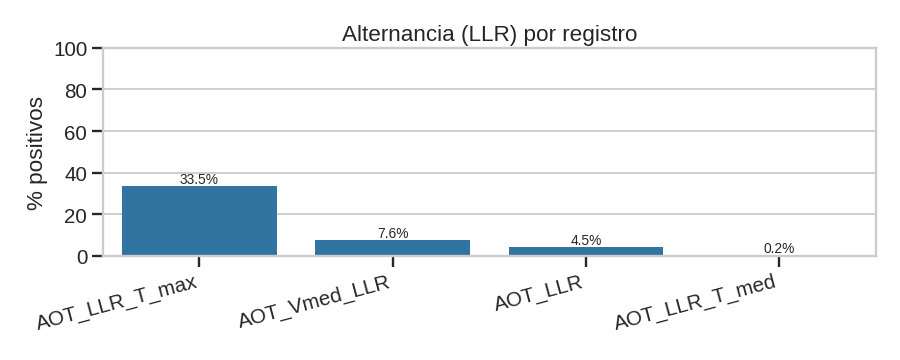

<IPython.core.display.Javascript object>


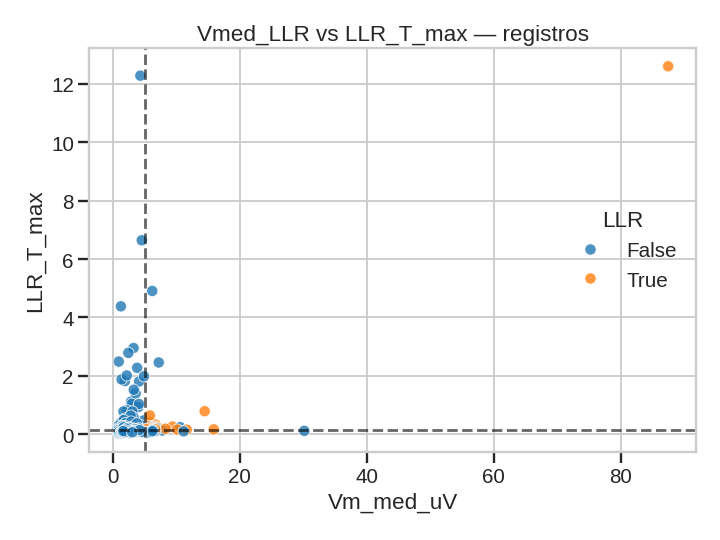

<IPython.core.display.Javascript object>


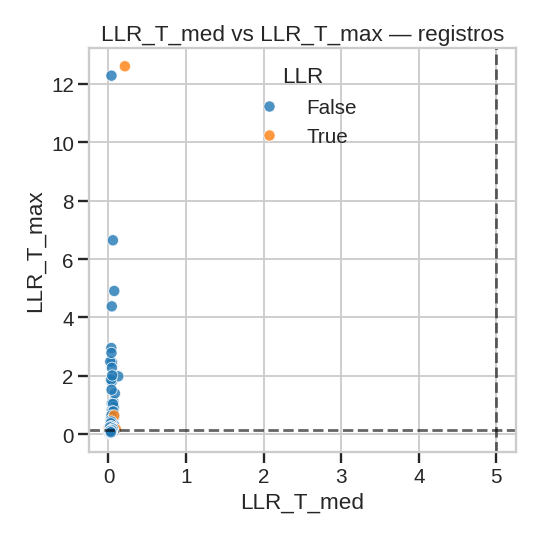

<IPython.core.display.Javascript object>


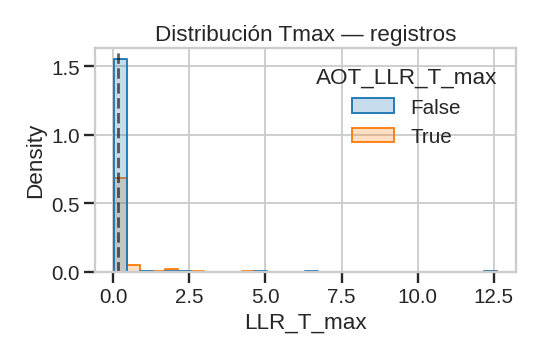

<IPython.core.display.Javascript object>


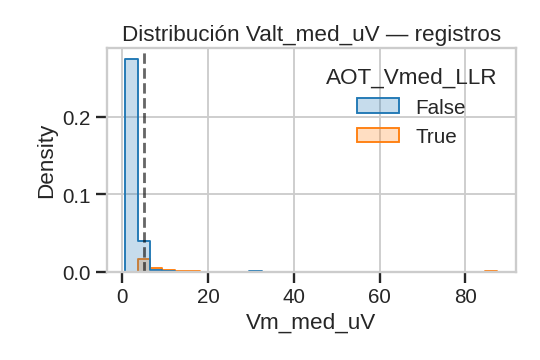


LLR — POR PACIENTE
LLR por paciente — total=104


criterio  positivos  total        pct
0  AOT_LLR_T_max         84    104  80.769231
1   AOT_Vmed_LLR         25    104  24.038462
2        AOT_LLR         16    104  15.384615
3  AOT_LLR_T_med          1    104   0.961538

<IPython.core.display.Javascript object>


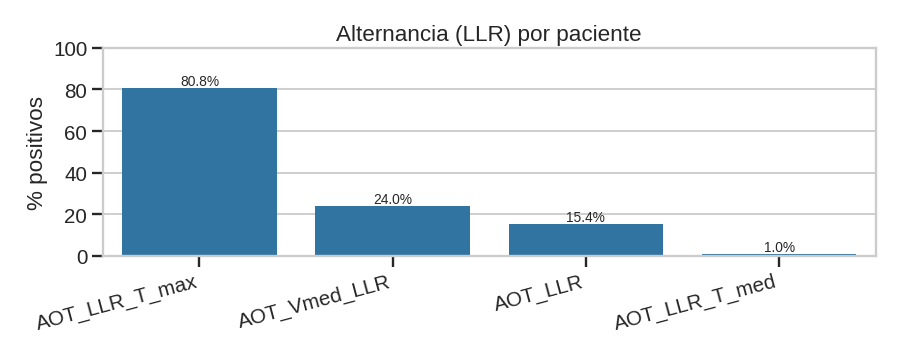

<IPython.core.display.Javascript object>


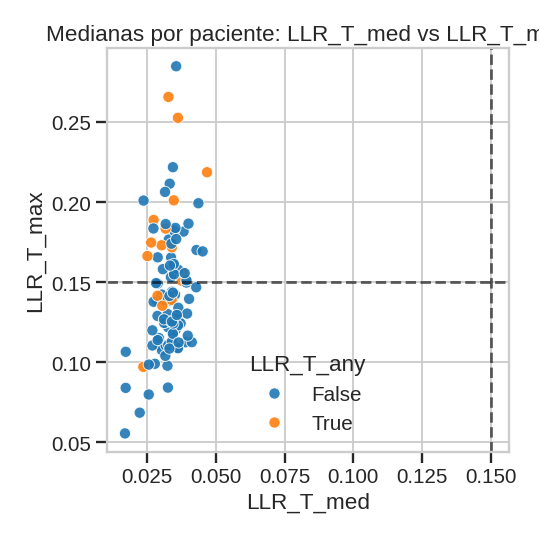

<IPython.core.display.Javascript object>


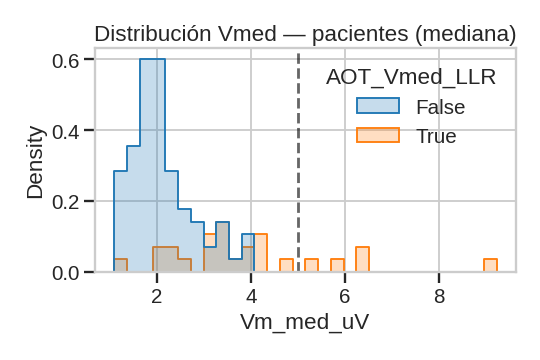

<IPython.core.display.Javascript object>


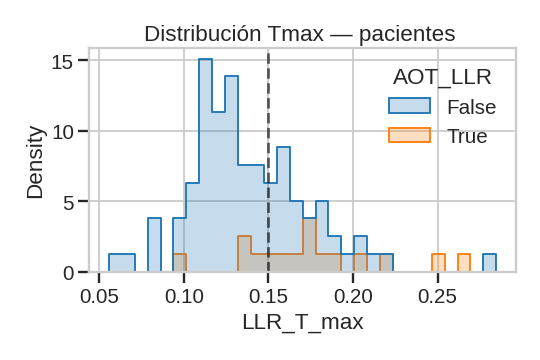

In [93]:
# criterios LLR (estadístico y amplitud)
llr_cols = ["AOT_LLR_T_med", "AOT_LLR_T_max", "AOT_LLR", "AOT_Vmed_LLR"]

# --- por registro ---
print("LLR — POR REGISTRO")
sum_llr_reg = summarize_flags(df_ok_lab, llr_cols, title="LLR por registro")

fig, ax = plt.subplots(figsize=(10,4))
barplot_percent(sum_llr_reg, "Alternancia (LLR) por registro", ax=ax)
plt.tight_layout(); plt.show()

# dispersión T_med vs T_max
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=df_ok_lab, x="Vm_med_uV", y="LLR_T_max",
                hue="AOT_LLR", alpha=0.8)
ax.axvline(UMBRAL_VM_MED , ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
ax.set_title("Vmed_LLR vs LLR_T_max — registros")
plt.legend(title="LLR"); plt.tight_layout()

plt.savefig("vmed_vs_tmax_scatter.png", dpi=300)
plt.show()




# dispersión T_med vs T_max
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=df_ok_lab, x="LLR_T_med", y="LLR_T_max",
                hue="AOT_LLR", alpha=0.8)
ax.axvline(UMBRAL_VM_MED , ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
ax.set_title("LLR_T_med vs LLR_T_max — registros")
plt.legend(title="LLR"); plt.tight_layout(); plt.show()


# T distribución
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df_ok_lab, x="LLR_T_max", hue="AOT_LLR_T_max", element="step", bins=30, stat="density")
ax.axvline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
ax.set_title("Distribución Tmax — registros")
plt.tight_layout(); plt.show()


# Valt (amplitud) distribución
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df_ok_lab, x="Vm_med_uV", hue="AOT_Vmed_LLR", element="step", bins=30, stat="density")
ax.axvline(UMBRAL_VM_MED , ls="--", c="k", alpha=0.6)
ax.set_title("Distribución Valt_med_uV — registros")
plt.tight_layout(); plt.show()




# --- por paciente ---
print("\nLLR — POR PACIENTE")
llr_pac = aggregate_by_patient(df_ok_lab, llr_cols,
                               extra_metrics=["LLR_T_med","LLR_T_max","Vm_med_uV"])
sum_llr_pac = summarize_flags(llr_pac, llr_cols, title="LLR por paciente")

fig, ax = plt.subplots(figsize=(10,4))
barplot_percent(sum_llr_pac, "Alternancia (LLR) por paciente", ax=ax)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(data=llr_pac, x="LLR_T_med", y="LLR_T_max",
                hue="AOT_LLR", alpha=0.9)
ax.axvline(UMBRAL_LLR_T_MED, ls="--", c="k", alpha=0.6)
ax.axhline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
ax.set_title("Medianas por paciente: LLR_T_med vs LLR_T_max")
plt.legend(title="LLR_T_any"); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=llr_pac, x="Vm_med_uV", hue="AOT_Vmed_LLR", element="step", bins=30, stat="density")
ax.axvline(UMBRAL_VM_MED , ls="--", c="k", alpha=0.6)
ax.set_title("Distribución Vmed — pacientes (mediana)")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data=llr_pac, x="LLR_T_max", hue="AOT_LLR", element="step", bins=30, stat="density")
ax.axvline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
ax.set_title("Distribución Tmax — pacientes ")
plt.tight_layout(); plt.show()


<IPython.core.display.Javascript object>


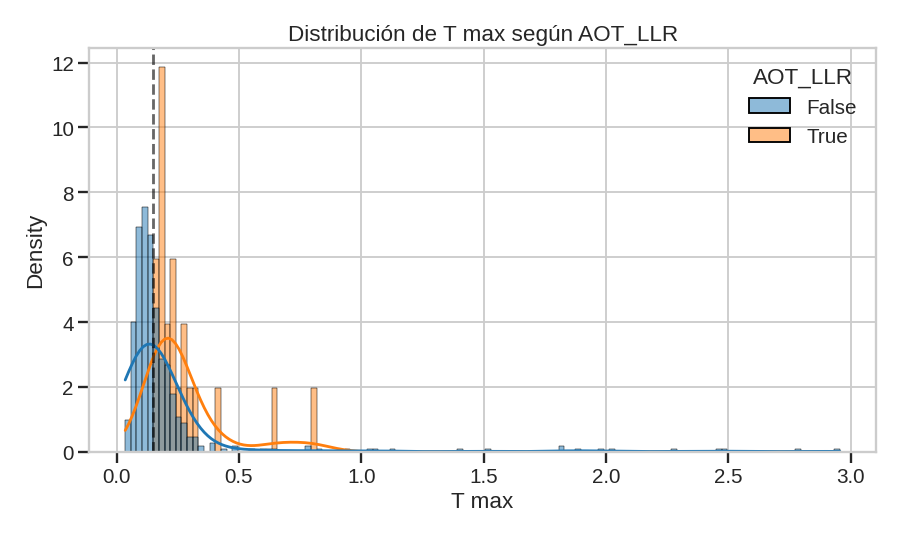

In [94]:
# Definir un subconjunto sin los outliers
scatter_llr = df_ok_lab[
    (df_ok_lab["LLR_T_max"]  < 3)  
]

fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(
    data=scatter_llr,
    x="LLR_T_max",
    hue="AOT_LLR",
    kde=True,
    stat="density",
    common_norm=False,
    alpha=0.5,
    ax=ax
)

ax.axvline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
ax.set_xlabel("T max")
ax.set_title("Distribución de T max según AOT_LLR")

plt.tight_layout()
plt.savefig("distribucion_tmax.png", dpi=300)
plt.show()


# Comparación SM y LLR

=== SM — POR REGISTRO ===
SM por registro — total=516


criterio  positivos  total        pct
0  AOT_SM_Kmax        405    516  78.488372
1  AOT_SM_Kp95        344    516  66.666667
2     AOT_VALT         51    516   9.883721
3       AOT_SM         47    516   9.108527


=== LLR — POR REGISTRO ===
LLR por registro — total=516


criterio  positivos  total        pct
0  AOT_LLR_T_max        173    516  33.527132
1   AOT_Vmed_LLR         39    516   7.558140
2        AOT_LLR         23    516   4.457364


=== GLOBAL — POR REGISTRO ===
Global por registro — total=516


criterio  positivos  total        pct
0  AOT_global         60    516  11.627907


=== SM — POR PACIENTE ===
SM por paciente — total=104


criterio  positivos  total        pct
0  AOT_SM_Kmax         98    104  94.230769
1  AOT_SM_Kp95         97    104  93.269231
2     AOT_VALT         34    104  32.692308
3       AOT_SM         31    104  29.807692


=== LLR — POR PACIENTE ===
LLR por paciente — total=104


criterio  positivos  total        pct
0  AOT_LLR_T_max         84    104  80.769231
1   AOT_Vmed_LLR         25    104  24.038462
2        AOT_LLR         16    104  15.384615


=== GLOBAL — POR REGISTRO ===
Global por registro — total=104


criterio  positivos  total        pct
0  AOT_global         36    104  34.615385

<IPython.core.display.Javascript object>


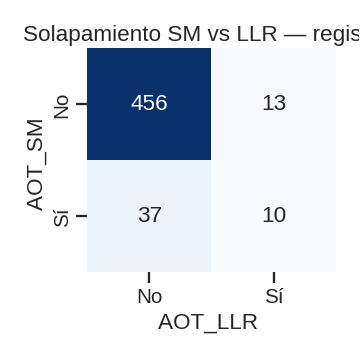

<IPython.core.display.Javascript object>


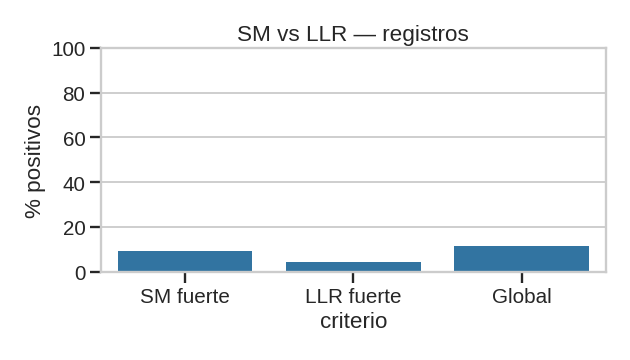

<IPython.core.display.Javascript object>


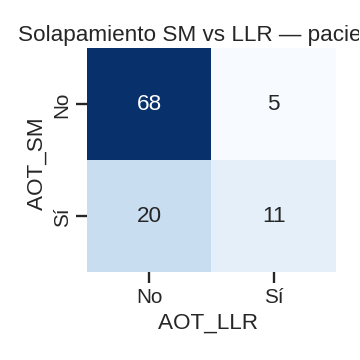

<IPython.core.display.Javascript object>


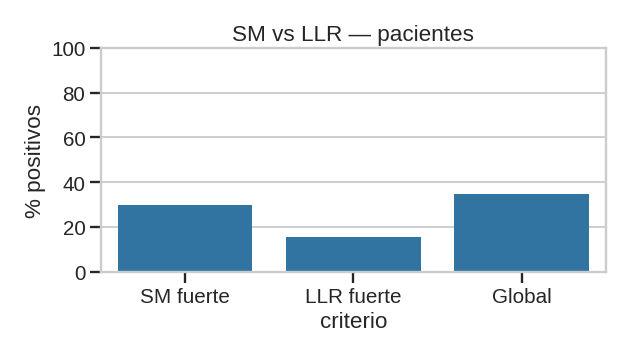

In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


if "paciente" not in df_ok_lab.columns:
    df_ok_lab["paciente"] = df_ok_lab["record"].str.extract(r"^(\d{3})")

if "Vm_med_uV" not in df_ok_lab.columns:
    if "Vm_med" in df_ok_lab.columns:
        df_ok_lab["Vm_med_uV"] = df_ok_lab["Vm_med"]
    else:
        df_ok_lab["Vm_med_uV"] = np.nan

if "Valt_SM_max" not in df_ok_lab.columns:
    df_ok_lab["Valt_SM_max"] = np.nan




# RESÚMENES RÁPIDOS SM / LLR 

sm_cols   = ["AOT_SM_Kmax", "AOT_SM_Kp95", "AOT_VALT", "AOT_SM"]
llr_cols  = ["AOT_LLR_T_max", "AOT_Vmed_LLR", "AOT_LLR"]
global_cols = ["AOT_global"]

print("=== SM — POR REGISTRO ===")
sum_sm_reg = summarize_flags(df_ok_lab, sm_cols, title="SM por registro")

print("\n=== LLR — POR REGISTRO ===")
sum_llr_reg = summarize_flags(df_ok_lab, llr_cols, title="LLR por registro")

print("\n=== GLOBAL — POR REGISTRO ===")
sum_global_reg = summarize_flags(df_ok_lab, global_cols, title="Global por registro")


# --- por paciente ---
sm_pac = aggregate_by_patient(df_ok_lab, sm_cols, extra_metrics=["Kmax","K_p95","Valt_SM_max"])
llr_pac = aggregate_by_patient(df_ok_lab, llr_cols, extra_metrics=["LLR_T_max","Vm_med_uV"])
global_pac = aggregate_by_patient(df_ok_lab, global_cols)

print("\n=== SM — POR PACIENTE ===")
sum_sm_pac = summarize_flags(sm_pac, sm_cols, title="SM por paciente")

print("\n=== LLR — POR PACIENTE ===")
sum_llr_pac = summarize_flags(llr_pac, llr_cols, title="LLR por paciente")

print("\n=== GLOBAL — POR REGISTRO ===")
sum_global_pac = summarize_flags(global_pac, global_cols, title="Global por registro")



# COMPARACIÓN SM vs LLR 

# Solapamiento SM vs LLR por registro
overlap_2x2_heatmap(df_ok_lab, "AOT_SM", "AOT_LLR",
                    "Solapamiento SM vs LLR — registros")
plt.tight_layout(); plt.show()

# Barras lado a lado SM vs LLR (% positivos por registro) 
cmp_reg = pd.DataFrame({
    "criterio": ["SM fuerte","LLR fuerte","Global"],
    "pct_true": [
        100*df_ok_lab["AOT_SM"].mean(),
        100*df_ok_lab["AOT_LLR"].mean(),
        100*df_ok_lab["AOT_global"].mean()
    ]
})
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=cmp_reg, x="criterio", y="pct_true", ax=ax)
ax.set_ylim(0,100); ax.set_ylabel("% positivos"); ax.set_title("SM vs LLR — registros")
plt.tight_layout(); plt.show()

# Por paciente 
pac_cmp = aggregate_by_patient(df_ok_lab, ["AOT_SM","AOT_LLR","AOT_global"])

overlap_2x2_heatmap(pac_cmp, "AOT_SM", "AOT_LLR",
                    "Solapamiento SM vs LLR — pacientes")
plt.tight_layout(); plt.show()

cmp_pac = pd.DataFrame({
    "criterio": ["SM fuerte","LLR fuerte","Global"],
    "pct_true": [
        100*pac_cmp["AOT_SM"].mean(),
        100*pac_cmp["AOT_LLR"].mean(),
        100*pac_cmp["AOT_global"].mean()
    ]
})
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(data=cmp_pac, x="criterio", y="pct_true", ax=ax)
ax.set_ylim(0,100); ax.set_ylabel("% positivos"); ax.set_title("SM vs LLR — pacientes")
plt.tight_layout(); plt.show()


<IPython.core.display.Javascript object>


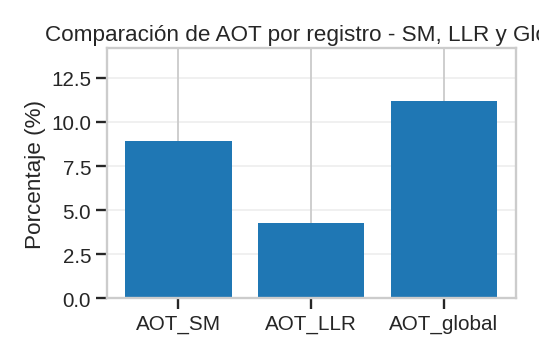

In [96]:
import matplotlib.pyplot as plt

# --- valores por REGISTRO ---
metodos = ["AOT_SM", "AOT_LLR", "AOT_global"]
porcentajes = [8.9, 4.3, 11.2]

plt.figure(figsize=(6,4))
plt.bar(metodos, porcentajes)
plt.ylabel("Porcentaje (%)")
plt.title("Comparación de AOT por registro - SM, LLR y Global")
plt.ylim(0, max(porcentajes)+3)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("aot_comparacion_registros.png", dpi=300)
plt.show()


<IPython.core.display.Javascript object>


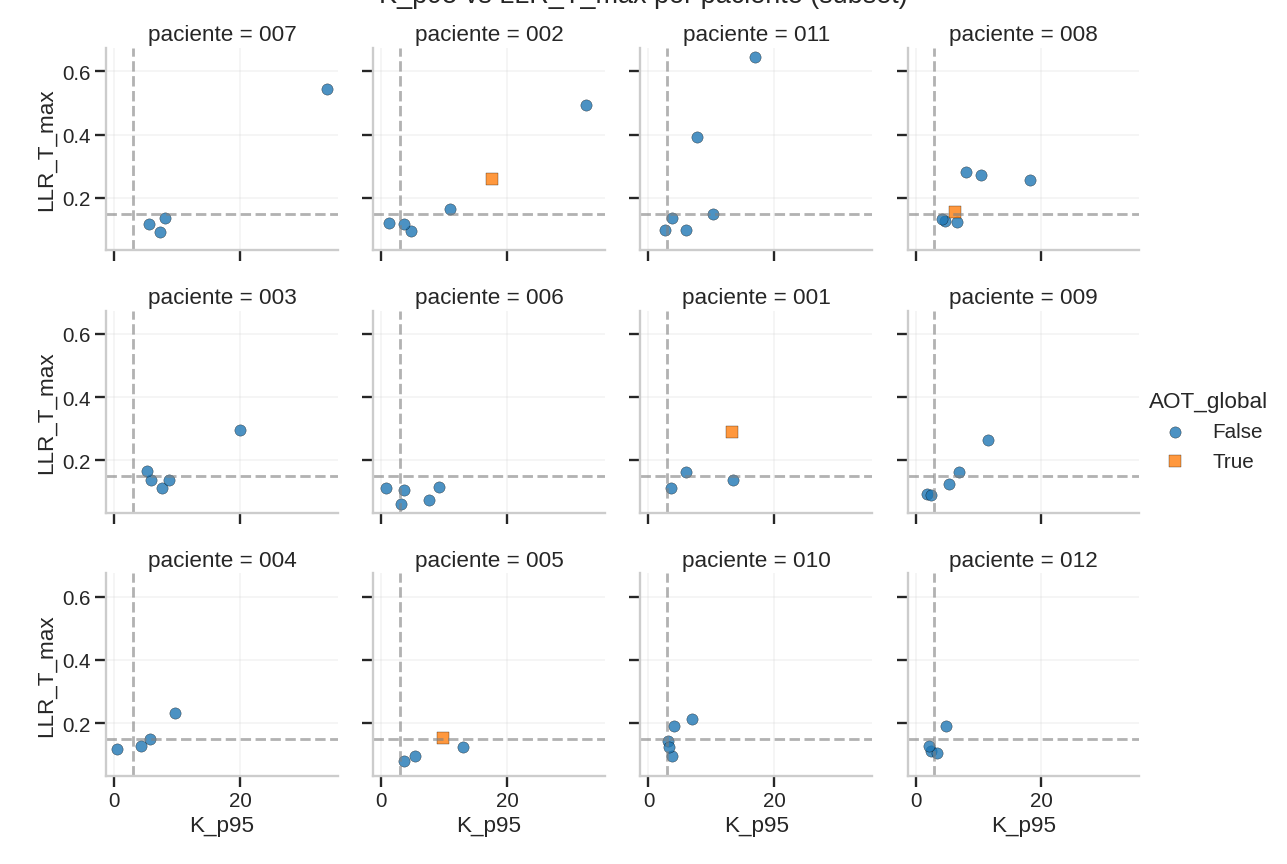

In [97]:
import seaborn as sns

#  primeros N pacientes
N_PACIENTES = 12
pacientes_top = (
    df_ok_lab["paciente"]
    .dropna()
    .sort_values()
    .unique()[:N_PACIENTES]
)

df_sub = df_ok_lab[df_ok_lab["paciente"].isin(pacientes_top)].copy()

g = sns.FacetGrid(
    df_sub,
    col="paciente",
    col_wrap=4,
    height=3.2,
    hue="AOT_global",
    hue_kws={"marker": ["o", "s"]},
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.scatterplot,
    x="K_p95",
    y="LLR_T_max",
    edgecolor="k",
    linewidth=0.3,
    alpha=0.8
)

g.add_legend(title="AOT_global")

for ax in g.axes.flat:
    ax.axvline(UMBRAL_KP95, color="gray", linestyle="--", alpha=0.6)
    ax.axhline(UMBRAL_LLR_T_MAX, color="gray", linestyle="--", alpha=0.6)
    ax.grid(alpha=0.2)

g.set_axis_labels("K_p95", "LLR_T_max")
g.fig.suptitle("K_p95 vs LLR_T_max por paciente (subset)", y=1.02)
plt.show()


<IPython.core.display.Javascript object>


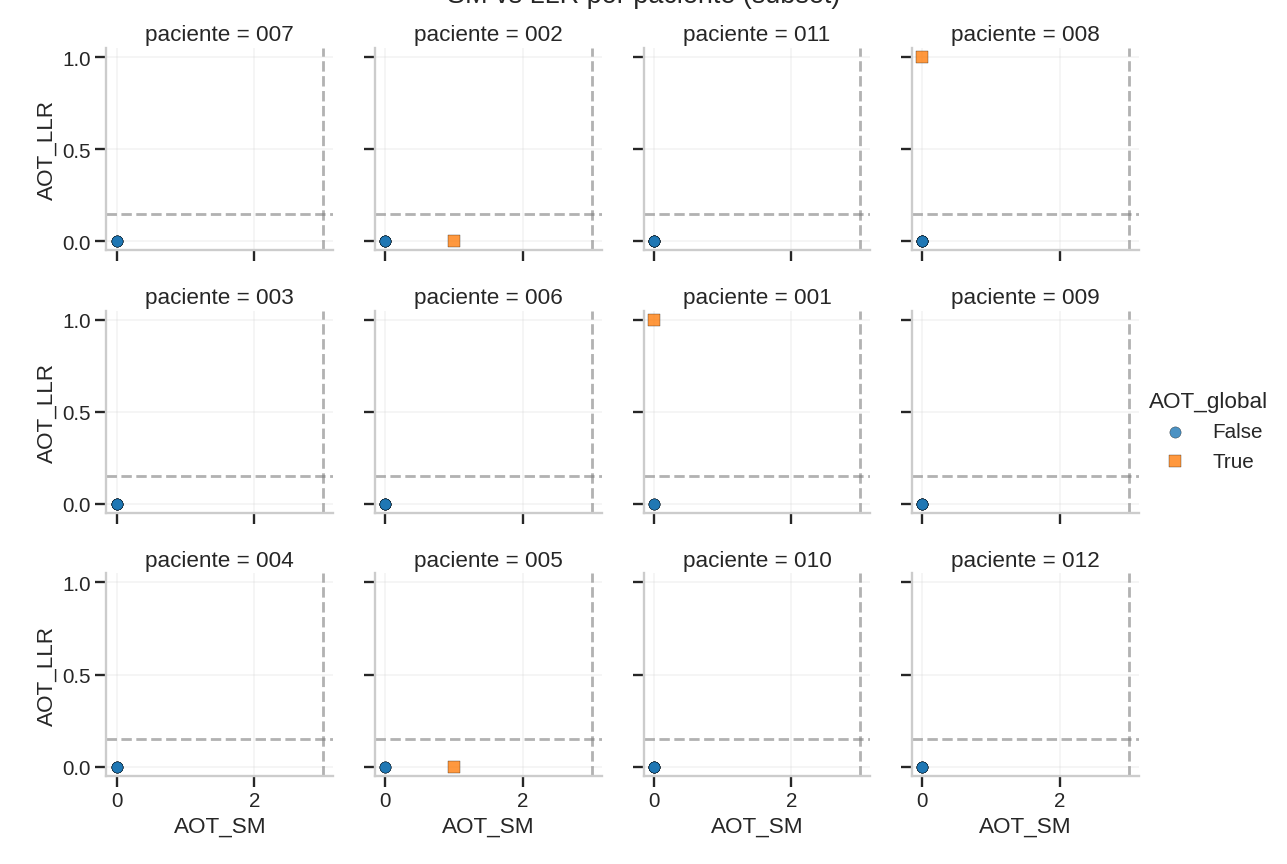

In [98]:
import seaborn as sns

#  primeros N pacientes
N_PACIENTES = 12
pacientes_top = (
    df_ok_lab["paciente"]
    .dropna()
    .sort_values()
    .unique()[:N_PACIENTES]
)

df_sub = df_ok_lab[df_ok_lab["paciente"].isin(pacientes_top)].copy()

g = sns.FacetGrid(
    df_sub,
    col="paciente",
    col_wrap=4,
    height=3.2,
    hue="AOT_global",
    hue_kws={"marker": ["o", "s"]},
    sharex=True,
    sharey=True
)

g.map_dataframe(
    sns.scatterplot,
    x="AOT_SM",
    y="AOT_LLR",
    edgecolor="k",
    linewidth=0.3,
    alpha=0.8
)

g.add_legend(title="AOT_global")

for ax in g.axes.flat:
    ax.axvline(UMBRAL_KP95, color="gray", linestyle="--", alpha=0.6)
    ax.axhline(UMBRAL_LLR_T_MAX, color="gray", linestyle="--", alpha=0.6)
    ax.grid(alpha=0.2)

g.set_axis_labels("AOT_SM", "AOT_LLR")
g.fig.suptitle("SM vs LLR por paciente (subset)", y=1.02)
plt.show()


<IPython.core.display.Javascript object>


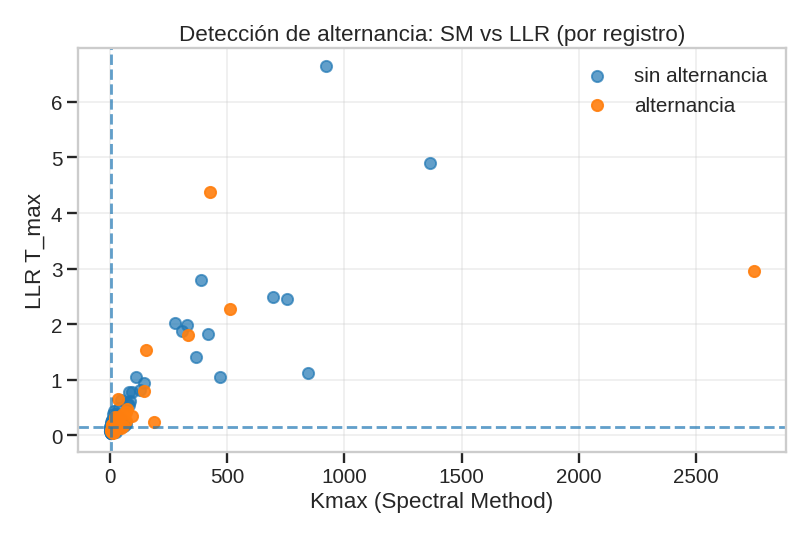

✅ Guardado: 'scatter_SM_vs_LLR.png'


<IPython.core.display.Javascript object>


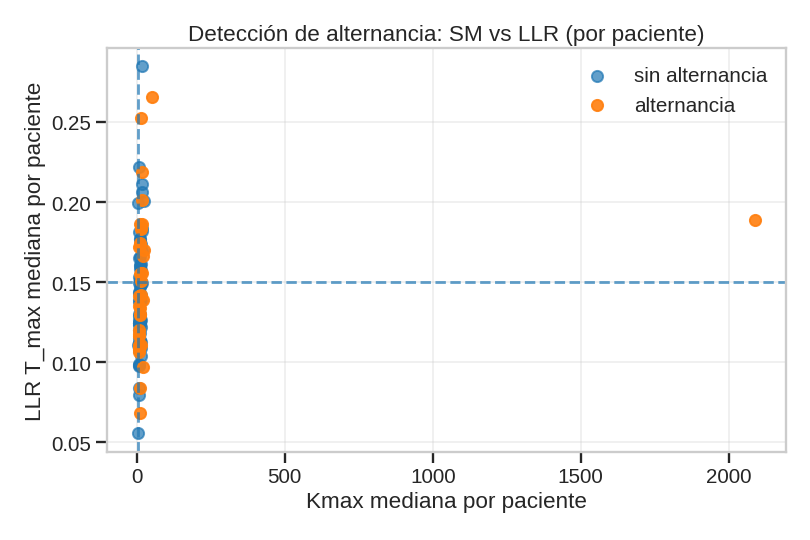

✅ Guardado: 'puntitos_SM_vs_LLR_por_paciente.png'


<IPython.core.display.Javascript object>


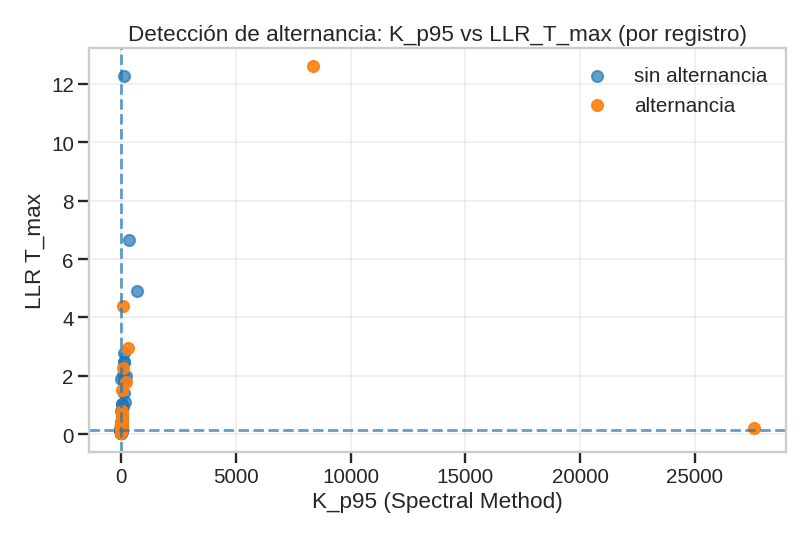

✅ Guardado: 'puntitos_Kp95_vs_LLR_por_registro.png'


In [99]:
df_reg = df_ok_lab.copy()


scatter_reg = df_reg[
    (df_ok_lab["Kmax"]  < 3000) &   
    (df_ok_lab["LLR_T_max"] < 20)      
]

#  Scatter SM vs LLR por REGISTRO (Kmax vs LLR_T_max) 
plt.figure(figsize=(9,6))
mask_no = ~df_ok_lab["AOT_global"]
mask_si =  df_ok_lab["AOT_global"]

plt.scatter(scatter_reg.loc[mask_no,"Kmax"], scatter_reg.loc[mask_no,"LLR_T_max"],
            label="sin alternancia", alpha=0.7)
plt.scatter(scatter_reg.loc[mask_si,"Kmax"], scatter_reg.loc[mask_si,"LLR_T_max"],
            label="alternancia", alpha=0.9)

# Líneas de umbral
plt.axvline(UMBRAL_KMAX, linestyle="--", alpha=0.7)
plt.axhline(UMBRAL_LLR_T_MAX, linestyle="--", alpha=0.7)

plt.xlabel("Kmax (Spectral Method)")
plt.ylabel("LLR T_max")
plt.title("Detección de alternancia: SM vs LLR (por registro)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("scatter_SM_vs_LLR.png", dpi=200)
plt.show()

print("✅ Guardado: 'scatter_SM_vs_LLR.png'")

# Agregado por PACIENTE 
per_pac = df_ok_lab.groupby("paciente").agg({
    "Kmax": "median",
    "K_p95": "median",
    "LLR_T_max": "median",
    "AOT_SM": "any",
    "AOT_LLR": "any",
    "AOT_global": "any"
}).reset_index()



# Scatter SM vs LLR por PACIENTE
plt.figure(figsize=(9,6))
mask_no_p = ~per_pac["AOT_global"]
mask_si_p =  per_pac["AOT_global"]

plt.scatter(per_pac.loc[mask_no_p,"Kmax"], per_pac.loc[mask_no_p,"LLR_T_max"],
            label="sin alternancia", alpha=0.7)
plt.scatter(per_pac.loc[mask_si_p,"Kmax"], per_pac.loc[mask_si_p,"LLR_T_max"],
            label="alternancia", alpha=0.9)




# Líneas de umbral 
plt.axvline(UMBRAL_KMAX, linestyle="--", alpha=0.7)
plt.axhline(UMBRAL_LLR_T_MAX, linestyle="--", alpha=0.7)

plt.xlabel("Kmax mediana por paciente")
plt.ylabel("LLR T_max mediana por paciente")
plt.title("Detección de alternancia: SM vs LLR (por paciente)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("puntitos_SM_vs_LLR_por_paciente.png", dpi=200)
plt.show()

print("✅ Guardado: 'puntitos_SM_vs_LLR_por_paciente.png'")

#  versión usando K_p95 en el eje X en lugar de Kmax
plt.figure(figsize=(9,6))
plt.scatter(df_reg.loc[mask_no,"K_p95"], df_reg.loc[mask_no,"LLR_T_max"],
            label="sin alternancia", alpha=0.7)
plt.scatter(df_reg.loc[mask_si,"K_p95"], df_reg.loc[mask_si,"LLR_T_max"],
            label="alternancia", alpha=0.9)

plt.axvline(UMBRAL_KP95, linestyle="--", alpha=0.7)
plt.axhline(UMBRAL_LLR_T_MAX, linestyle="--", alpha=0.7)

plt.xlabel("K_p95 (Spectral Method)")
plt.ylabel("LLR T_max")
plt.title("Detección de alternancia: K_p95 vs LLR_T_max (por registro)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("puntitos_Kp95_vs_LLR_por_registro.png", dpi=200)
plt.show()

print("✅ Guardado: 'puntitos_Kp95_vs_LLR_por_registro.png'")


# ALTERNANCIA POR FASES 

In [100]:
import pandas as pd, re

ANNOT_XLSX = "/home/alumnos/lauramll/Escritorio/TFG/staff_III/STAFF-III-Database-Annotations.xlsx"  # cambia ruta si procede


COLS = ["Patient","Age","Sex",
        "BR","BC1","BC2",
        "BI1","BI1:Occluded artery","BI1:D0;D1;D2"," BI1:Injection time(s)",
        "BI2","BI2:Occluded artery","BI2:D0;D1;D2","BI2:Injection time(s)",
        "BI3","BI3:Occluded artery","BI3:D0;D1;D2","BI3:Injection time(s)",
        "BI4","BI4:Occluded artery","BI4:D0;D1;D2",
        "BI5","BI5:Occluded artery","BI5:D0;D1;D2",
        "PC1","PC2","PR1","PR2","Prior MI"]

raw = pd.read_excel(ANNOT_XLSX, header=0)
raw = raw[[c for c in COLS if c in raw.columns]].copy()


def _first_code(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    if not s: return None
    m = re.findall(r"\d+\s*[a-z]", s)  # “23a”, “23 a”, etc.
    return m[0].replace(" ","") if m else None

def _patient_num(v):
    try: return int(str(v).strip().replace("#",""))
    except: return None

# definición de grupos e índices
PHASE_MAP = {
    "BR":  ["BR"],
    "BC":  ["BC1","BC2"],
    "BI":  ["BI1","BI2","BI3","BI4","BI5"],
    "PC":  ["PC1","PC2"],
    "PR":  ["PR1","PR2"],
}

rows = []
for _, r in raw.iterrows():
    pnum = _patient_num(r.get("Patient"))
    if pnum is None: continue
    for phase, cols in PHASE_MAP.items():
        for i, col in enumerate(cols, start=1):
            if col not in r: continue
            code = _first_code(r[col])
            if not code: continue
            m = re.match(r"(\d+)([a-z])", code)
            if not m: continue
            letter = m.group(2)
            record = f"{pnum:03d}{letter}"
            rows.append({
                "patient": f"{pnum:03d}",
                "record": record,
                "phase_group": phase,      # BR/BC/BI/PC/PR
                "phase_idx": i,            # 1..N dentro del grupo
                "phase_letter": letter,    # a,b,c,d...
            })

ann_long = pd.DataFrame(rows).drop_duplicates(subset=["record"]).reset_index(drop=True)
print("Registros mapeados desde Excel:", len(ann_long))
display(ann_long.head(15))


Registros mapeados desde Excel: 520


patient record phase_group  phase_idx phase_letter
0      001   001a          BR          1            a
1      001   001b          BC          1            b
2      001   001c          BI          1            c
3      001   001d          PR          1            d
4      002   002a          BR          1            a
5      002   002b          BC          1            b
6      002   002c          BC          2            c
7      002   002d          BI          1            d
8      002   002e          BI          2            e
9      002   002f          PR          1            f
10     003   003a          BR          1            a
11     003   003b          BC          1            b
12     003   003c          BI          1            c
13     003   003d          PC          1            d
14     003   003e          PR          1            e

In [101]:
assert "record" in df_ok_lab.columns, "df_ok_lab debe tener columna 'record' (p.ej. '001a')."

df_phase = df_ok_lab.merge(ann_long, on="record", how="left")
print("Registros totales en df_ok_lab:", len(df_ok_lab))
print("Sin etiqueta de fase del Excel:", df_phase['phase_group'].isna().sum())


Registros totales en df_ok_lab: 516
Sin etiqueta de fase del Excel: 0


In [102]:

flags = ["AOT_SM","AOT_LLR", "AOT_SM_Kmax" , "AOT_SM_Kp95" , "AOT_VALT" , "AOT_LLR_T_max" , "AOT_Vmed_LLR","AOT_global"]

def resumen_por(df, key):
    base = df.dropna(subset=[key]).copy()
    out = []
    tot = base.groupby(key).size().rename("n_total")
    for f in flags:
        pos = base.groupby(key)[f].sum().rename("n_pos")
        t = pd.concat([tot, pos], axis=1)
        t["criterio"] = f
        t["pct"] = 100 * t["n_pos"]/t["n_total"]
        out.append(t.reset_index())
    return pd.concat(out, ignore_index=True).sort_values([key,"criterio"])

res_fase  = resumen_por(df_phase, "phase_group")  # BR/BC/BI/PC/PR
res_letra = resumen_por(df_phase, "phase_letter") # a,b,c,d,...

display(res_fase)
display(res_letra)


phase_group  n_total  n_pos       criterio        pct
5           BC      113      4        AOT_LLR   3.539823
25          BC      113     24  AOT_LLR_T_max  21.238938
0           BC      113     11         AOT_SM   9.734513
10          BC      113     89    AOT_SM_Kmax  78.761062
15          BC      113     73    AOT_SM_Kp95  64.601770
20          BC      113     12       AOT_VALT  10.619469
30          BC      113     12   AOT_Vmed_LLR  10.619469
35          BC      113     13     AOT_global  11.504425
6           BI      141     12        AOT_LLR   8.510638
26          BI      141     70  AOT_LLR_T_max  49.645390
1           BI      141     20         AOT_SM  14.184397
11          BI      141    112    AOT_SM_Kmax  79.432624
16          BI      141    108    AOT_SM_Kp95  76.595745
21          BI      141     21       AOT_VALT  14.893617
31          BI      141     15   AOT_Vmed_LLR  10.638298
36          BI      141     28     AOT_global  19.858156
7           BR       73      3        AOT_LLR   4.109589
27          BR       73     26  AOT_LLR_T_max  35.616438
2           BR       73      4         AOT_SM   5.479452
12          BR       73     54    AOT_SM_Kmax  73.972603
17          BR       73     46    AOT_SM_Kp95  63.013699
22          BR       73      4       AOT_VALT   5.479452
32          BR       73      3   AOT_Vmed_LLR   4.109589
37          BR       73      5     AOT_global   6.849315
8           PC       93      4        AOT_LLR   4.301075
28          PC       93     26  AOT_LLR_T_max  27.956989
3           PC       93     10         AOT_SM  10.752688
13          PC       93     75    AOT_SM_Kmax  80.645161
18          PC       93     65    AOT_SM_Kp95  69.892473
23          PC       93     11       AOT_VALT  11.827957
33          PC       93      9   AOT_Vmed_LLR   9.677419
38          PC       93     12     AOT_global  12.903226
9           PR       96      0        AOT_LLR   0.000000
29          PR       96     27  AOT_LLR_T_max  28.125000
4           PR       96      2         AOT_SM   2.083333
14          PR       96     75    AOT_SM_Kmax  78.125000
19          PR       96     52    AOT_SM_Kp95  54.166667
24          PR       96      3       AOT_VALT   3.125000
34          PR       96      0   AOT_Vmed_LLR   0.000000
39          PR       96      2     AOT_global   2.083333

phase_letter  n_total  n_pos       criterio        pct
7             a      104      5        AOT_LLR   4.807692
35            a      104     33  AOT_LLR_T_max  31.730769
0             a      104      9         AOT_SM   8.653846
14            a      104     77    AOT_SM_Kmax  74.038462
21            a      104     68    AOT_SM_Kp95  65.384615
28            a      104      9       AOT_VALT   8.653846
42            a      104      9   AOT_Vmed_LLR   8.653846
49            a      104     11     AOT_global  10.576923
8             b      103      4        AOT_LLR   3.883495
36            b      103     29  AOT_LLR_T_max  28.155340
1             b      103      9         AOT_SM   8.737864
15            b      103     84    AOT_SM_Kmax  81.553398
22            b      103     68    AOT_SM_Kp95  66.019417
29            b      103     11       AOT_VALT  10.679612
43            b      103      8   AOT_Vmed_LLR   7.766990
50            b      103     12     AOT_global  11.650485
9             c      103      9        AOT_LLR   8.737864
37            c      103     49  AOT_LLR_T_max  47.572816
2             c      103     16         AOT_SM  15.533981
16            c      103     82    AOT_SM_Kmax  79.611650
23            c      103     78    AOT_SM_Kp95  75.728155
30            c      103     16       AOT_VALT  15.533981
44            c      103     10   AOT_Vmed_LLR   9.708738
51            c      103     22     AOT_global  21.359223
10            d       96      4        AOT_LLR   4.166667
38            d       96     34  AOT_LLR_T_max  35.416667
3             d       96     10         AOT_SM  10.416667
17            d       96     79    AOT_SM_Kmax  82.291667
24            d       96     71    AOT_SM_Kp95  73.958333
31            d       96     10       AOT_VALT  10.416667
45            d       96      9   AOT_Vmed_LLR   9.375000
52            d       96     11     AOT_global  11.458333
11            e       81      0        AOT_LLR   0.000000
39            e       81     22  AOT_LLR_T_max  27.160494
4             e       81      2         AOT_SM   2.469136
18            e       81     60    AOT_SM_Kmax  74.074074
25            e       81     44    AOT_SM_Kp95  54.320988
32            e       81      4       AOT_VALT   4.938272
46            e       81      1   AOT_Vmed_LLR   1.234568
53            e       81      2     AOT_global   2.469136
12            f       24      1        AOT_LLR   4.166667
40            f       24      5  AOT_LLR_T_max  20.833333
5             f       24      1         AOT_SM   4.166667
19            f       24     19    AOT_SM_Kmax  79.166667
26            f       24     12    AOT_SM_Kp95  50.000000
33            f       24      1       AOT_VALT   4.166667
47            f       24      2   AOT_Vmed_LLR   8.333333
54            f       24      2     AOT_global   8.333333
13            g        5      0        AOT_LLR   0.000000
41            g        5      1  AOT_LLR_T_max  20.000000
6             g        5      0         AOT_SM   0.000000
20            g        5      4    AOT_SM_Kmax  80.000000
27            g        5      3    AOT_SM_Kp95  60.000000
34            g        5      0       AOT_VALT   0.000000
48            g        5      0   AOT_Vmed_LLR   0.000000
55            g        5      0     AOT_global   0.000000

<IPython.core.display.Javascript object>


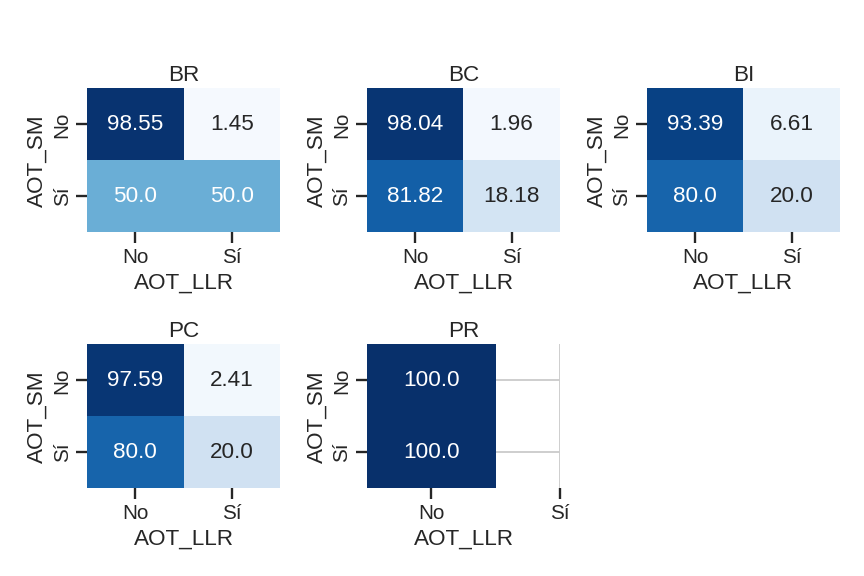

In [110]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PHASE_ORDER = ["BR","BC","BI","PC","PR"]  # orden estético

def _hm_por_fase(df, flag_row, flag_col, title_prefix, fname):
    base = df.dropna(subset=["phase_group"]).copy()
    base = base[base["phase_group"].isin(PHASE_ORDER)]
    g = sns.FacetGrid(base, col="phase_group", col_order=PHASE_ORDER,
                      col_wrap=3, height=3.2, aspect=1.0, sharex=False, sharey=False)
    def __draw(data, **kws):
        # tabla % por filas
        tab = (pd.crosstab(data[flag_row].astype(bool).round(2),
                           data[flag_col].astype(bool).round(2))
                 .astype(float))
        tab_pct = (tab.div(tab.sum(axis=1), axis=0).fillna(0.0)*100).round(2)

        annot = tab_pct.round(1).astype(int).astype(str) + "\n(n=" + tab.sum(axis=1).astype(int).astype(str) + ")"
        sns.heatmap(tab_pct, vmin=0, vmax=100, cmap="Blues",
                    cbar=False, annot=True, fmt="", 
                    xticklabels=["No","Sí"], yticklabels=["No","Sí"])
        plt.xlabel(flag_col); plt.ylabel(flag_row)
    g.map_dataframe(__draw)
    g.set_titles(col_template="{col_name}")
    plt.suptitle(f"{title_prefix} — % por fila", y=1.05, fontsize=13)
    plt.tight_layout()
    plt.savefig("boxplots_fases.png", dpi=200, bbox_inches="tight")
    plt.show()

# SM vs LLR por fase
_hm_por_fase(df_phase, "AOT_SM", "AOT_LLR",
             "Solapamiento SM vs LLR (por fase)",
             "hm_SM_vs_LLR_por_fase.png")




<IPython.core.display.Javascript object>


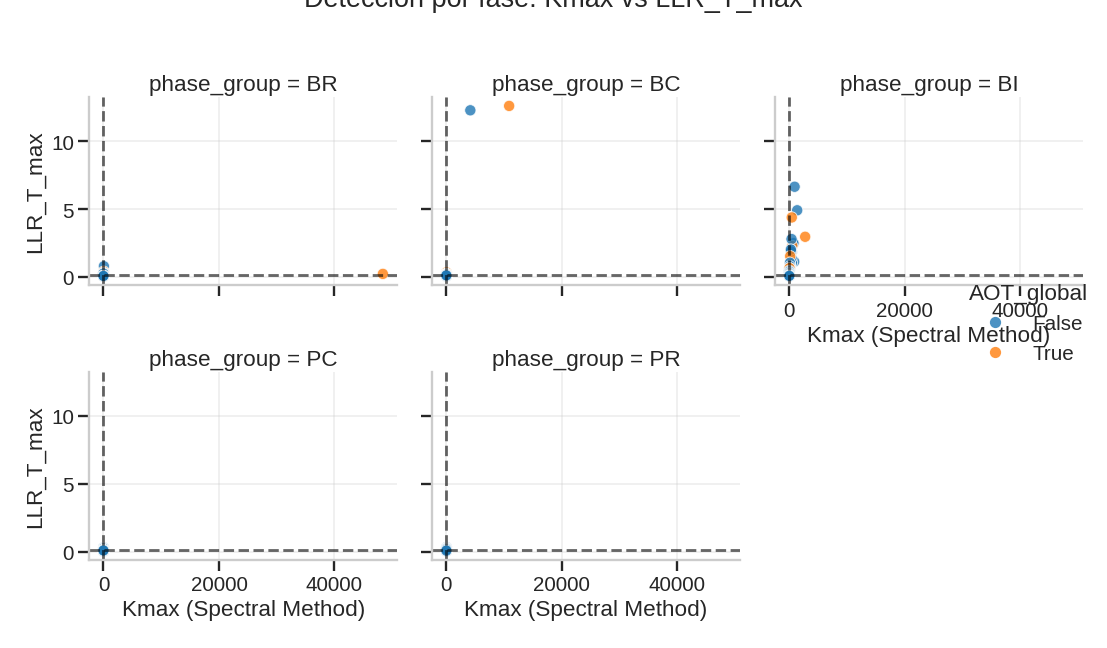

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt


base = df_phase.dropna(subset=["phase_group"]).copy()
base = base[base["phase_group"].isin(PHASE_ORDER)]

# Scatter por fase con valores reales
fg = sns.relplot(
    data=base, col="phase_group", col_order=PHASE_ORDER,col_wrap = 3,
    x="Kmax", y="LLR_T_max",
    hue="AOT_global",  
    kind="scatter", alpha=0.8, height=3.6, aspect=1.0
)

for ax in fg.axes.flat:
    ax.axvline(UMBRAL_KMAX, ls="--", c="k", alpha=0.6)
    ax.axhline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
    ax.set_xlabel("Kmax (Spectral Method)")
    ax.set_ylabel("LLR_T_max")
    ax.grid(True, alpha=0.3)

fg.fig.suptitle("Detección por fase: Kmax vs LLR_T_max", y=1.02)
plt.tight_layout()
plt.savefig("scatter_Kmax_LLR_fases.png", dpi=200, bbox_inches="tight")
plt.show()


<IPython.core.display.Javascript object>


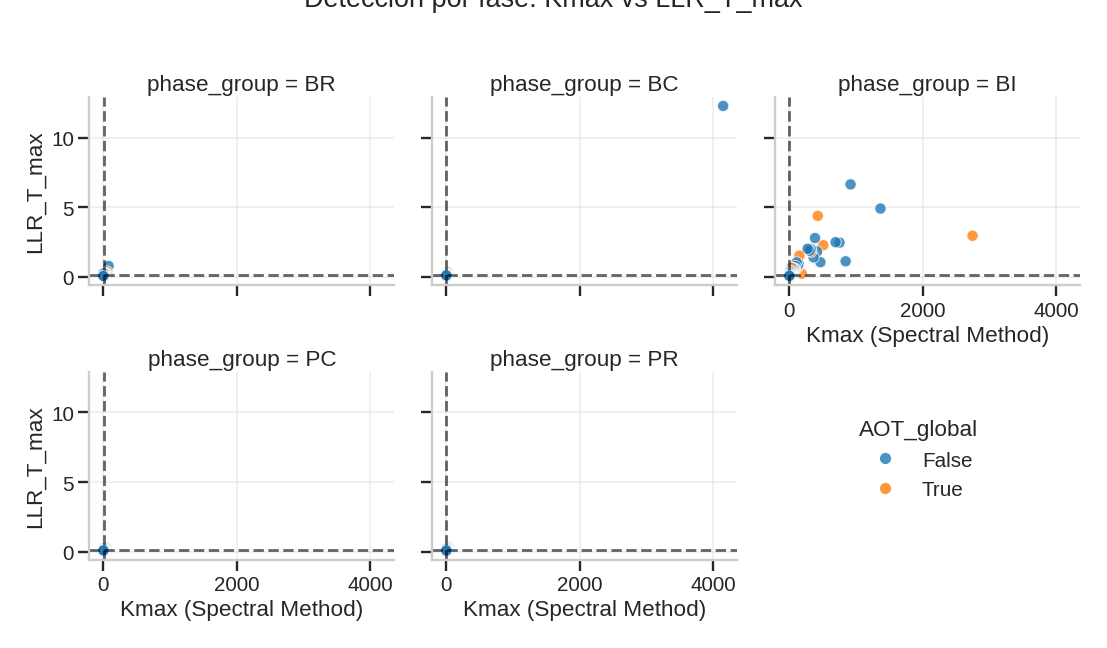

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt


base = df_phase.dropna(subset=["phase_group"]).copy()
base = base[base["phase_group"].isin(PHASE_ORDER)]


base_plot = base[base["Kmax"] < 10000].copy()   

fg = sns.relplot(
    data=base_plot, col="phase_group", col_order=PHASE_ORDER, col_wrap = 3 ,
    x="Kmax", y="LLR_T_max",
    hue="AOT_global",
    kind="scatter", alpha=0.8, height=3.6, aspect=1.0
)

for phase, ax in zip(PHASE_ORDER, fg.axes.flat):
    ax.axvline(UMBRAL_KMAX, ls="--", c="k", alpha=0.6)
    ax.axhline(UMBRAL_LLR_T_MAX, ls="--", c="k", alpha=0.6)
    ax.set_xlabel("Kmax (Spectral Method)")
    ax.set_ylabel("LLR_T_max")
    ax.grid(True, alpha=0.3)

leg = fg._legend
leg.set_bbox_to_anchor((0.9, 0.2))
leg.set_loc("lower right")
    
    
fg.fig.suptitle("Detección por fase: Kmax vs LLR_T_max", y=1.02)
plt.tight_layout()
plt.savefig("scatter_Kmax_LLR_fases_sin_outliers.png", dpi=300, bbox_inches="tight")
plt.show()


<IPython.core.display.Javascript object>


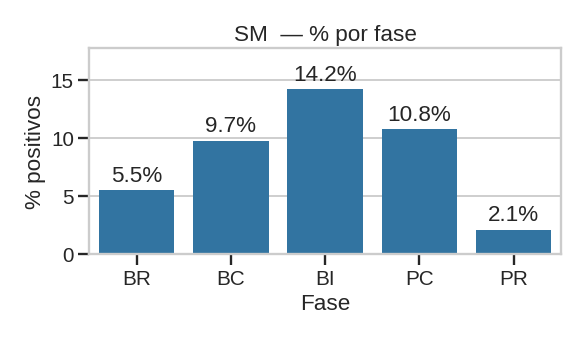

<IPython.core.display.Javascript object>


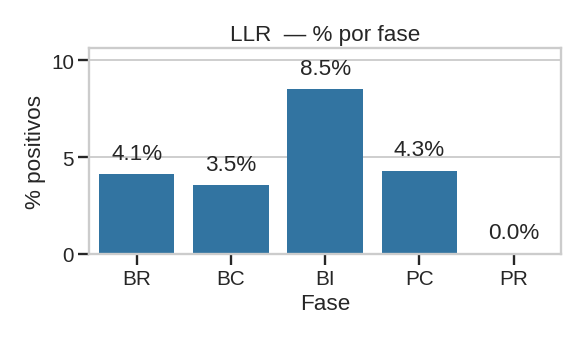

<IPython.core.display.Javascript object>


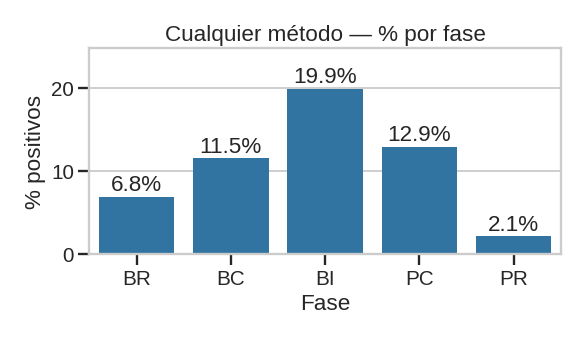

In [106]:
def barra_pct_por_fase(df, flag, titulo, fname):

    t = (df.dropna(subset=["phase_group"])
           .groupby("phase_group")[flag].mean()
           .reindex(PHASE_ORDER).mul(100).rename("%"))
    plt.figure(figsize=(6.5,3.8))
    ax = sns.barplot(x=t.index, y=t.values)
    for i,v in enumerate(t.values):
        ax.text(i, v+0.8, f"{v:.1f}%", ha="center")
    plt.ylim(0, max(5, np.nanmax(t.values)*1.25))
    plt.title(titulo); plt.ylabel("% positivos"); plt.xlabel("Fase")
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()

barra_pct_por_fase(df_phase, "AOT_SM",   "SM  — % por fase", "pct_SM_por_fase.png")
barra_pct_por_fase(df_phase, "AOT_LLR", "LLR  — % por fase","pct_LLR_por_fase.png")
barra_pct_por_fase(df_phase, "AOT_global",    "Cualquier método — % por fase",       "pct_TOTAL_por_fase.png")


In [107]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def barra_pct_por_fase_pacientes(df, flag, titulo, fname):


    pac_phase = (
        df.dropna(subset=["phase_group"])
          .groupby(["paciente", "phase_group"])[flag]
          .any()                      
          .reset_index()
    )

    t = (pac_phase
         .groupby("phase_group")[flag]
         .mean()                  
         .reindex(PHASE_ORDER)
         .mul(100)
         .rename("%"))


    plt.figure(figsize=(6.5, 3.8))
    ax = sns.barplot(x=t.index, y=t.values)

    for i, v in enumerate(t.values):
        ax.text(i, v + 0.8, f"{v:.1f}%", ha="center")

    plt.ylim(0, max(5, np.nanmax(t.values) * 1.25))
    plt.title(titulo)
    plt.ylabel("% pacientes positivos")
    plt.xlabel("Fase")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()


<IPython.core.display.Javascript object>


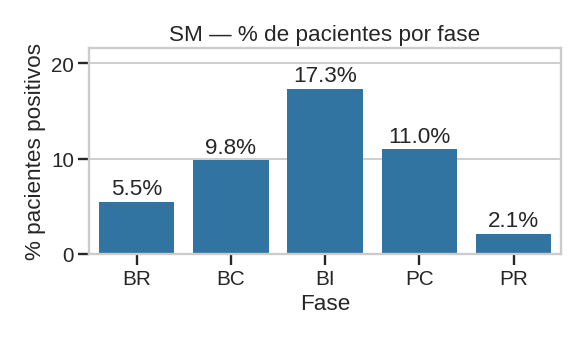

<IPython.core.display.Javascript object>


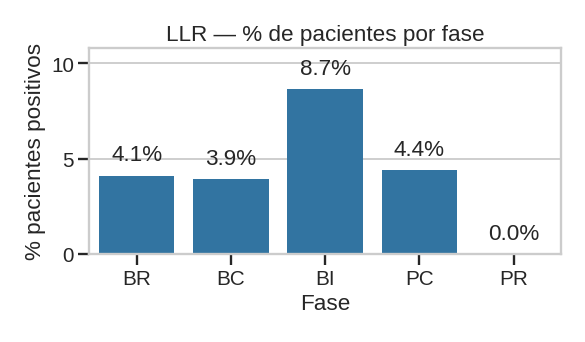

<IPython.core.display.Javascript object>


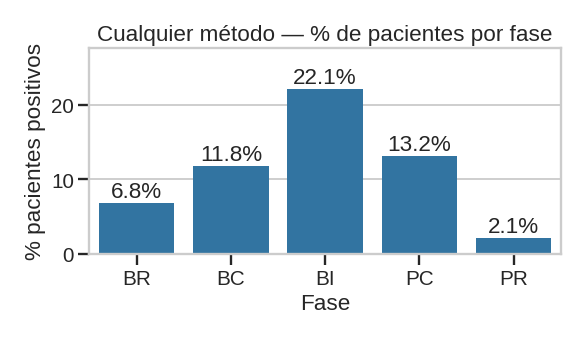

In [108]:
barra_pct_por_fase_pacientes(df_phase, "AOT_SM",
    "SM — % de pacientes por fase", "pct_SM_pacientes_por_fase.png")

barra_pct_por_fase_pacientes(df_phase, "AOT_LLR",
    "LLR — % de pacientes por fase", "pct_LLR_pacientes_por_fase.png")

barra_pct_por_fase_pacientes(df_phase, "AOT_global",
    "Cualquier método — % de pacientes por fase", "pct_TOTAL_pacientes_por_fase.png")


In [99]:
import pandas as pd
import re

# columnas de fases en el Excel
COLS = ["BR","BC1","BC2","BI1","BI2","BI3","BI4","BI5","PC1","PC2","PR1","PR2"]

def _norm_record(token):
    """
    token tipo '1a','12b','104c' -> '001a','012b','104c'
    """
    token = str(token).strip()
    m = re.match(r"^(\d{1,3})([a-zA-Z])$", token)
    if not m:
        return None
    pid = int(m.group(1))
    letter = m.group(2).lower()
    return f"{pid:03d}{letter}"

def build_phase_map(xlsx_path=ANNOT_XLSX):
    ann = pd.read_excel(xlsx_path)
    out = []
    for col in COLS:
        if col not in ann.columns:
            continue
        group = ("BR" if col=="BR" else
                 "BC" if col.startswith("BC") else
                 "BI" if col.startswith("BI") else
                 "PC" if col.startswith("PC") else
                 "PR" if col.startswith("PR") else None)
        if group is None:
            continue
        for tok in ann[col].dropna().astype(str):
            rec = _norm_record(tok)
            if rec:
                out.append({"record": rec,
                            "phase_group": group,
                            "phase_letter": rec[-1]})
    map_df = (pd.DataFrame(out)
                .drop_duplicates(subset=["record"])
                .reset_index(drop=True))
    return map_df

phase_map = build_phase_map(ANNOT_XLSX)
print(phase_map.head())
print("Registros mapeados:", len(phase_map))


  record phase_group phase_letter
0   001a          BR            a
1   002a          BR            a
2   003a          BR            a
3   007a          BR            a
4   008a          BR            a
Registros mapeados: 520


In [126]:
# Borra cualquier columna antigua de fase
cols_to_drop = [c for c in df_ok_lab.columns 
                if c.startswith("phase_group") or c.startswith("phase_letter")]

df_ok_lab = df_ok_lab.drop(columns=cols_to_drop, errors="ignore")


df_ok_lab = df_ok_lab.merge(
    phase_map[["record", "phase_group", "phase_letter"]],
    on="record",
    how="left"
)

df_ok_lab["phase_group"] = df_ok_lab["phase_group"].fillna("UNK")
df_ok_lab["phase_letter"] = df_ok_lab["phase_letter"].fillna("x")


In [127]:
import pandas as pd
from IPython.display import display, Markdown

# Orden estándar de fases
PHASE_ORDER = ["BR", "BC", "BI", "PC", "PR"]

def _check_cols(df, cols):
    faltan = [c for c in cols if c not in df.columns]
    if faltan:
        raise KeyError(f"Faltan columnas en df_ok_lab: {faltan}")

def pct_pos_por_fase_registro(df, col_bool, phase_col="phase_group"):
    """
    % de registros positivos por fase (col_bool es booleana).
    Devuelve DF con columnas: phase_group, %
    """
    _check_cols(df, [phase_col, col_bool])
    # media de True por fase -> %; reindex a orden canónico y rellena ausentes con 0
    out = (df.groupby(phase_col, as_index=False)[col_bool]
             .mean()  # booleans -> proporción
             .rename(columns={col_bool: "%"}) )
    out["%"] = (out["%"] * 100).round(1)
    out = (out.set_index(phase_col)
              .reindex(PHASE_ORDER)
              .fillna({"%": 0.0})
              .rename_axis("phase_group")
              .reset_index())
    return out

def pct_pos_por_fase_paciente(df, col_bool, pid_col="paciente", phase_col="phase_group"):
    """
    % de pacientes con al menos un registro positivo en esa fase.
    """
    _check_cols(df, [pid_col, phase_col, col_bool])
    per_pac_fase = (df.groupby([pid_col, phase_col])[col_bool]
                      .any()
                      .reset_index(name="has_pos"))
    out = (per_pac_fase.groupby(phase_col, as_index=False)["has_pos"]
             .mean()
             .rename(columns={"has_pos": "%"}) )
    out["%"] = (out["%"] * 100).round(1)
    out = (out.set_index(phase_col)
              .reindex(PHASE_ORDER)
              .fillna({"%": 0.0})
              .rename_axis("phase_group")
              .reset_index())
    return out



for needed in ["phase_group", "AOT_SM", "AOT_LLR"]:
    if needed not in df_ok_lab.columns:
        raise KeyError(f"Falta la columna '{needed}' en df_ok_lab. Revísala antes de continuar.")

#  % POR FASE (REGISTRO) 

sm_reg  = pct_pos_por_fase_registro(df_ok_lab, "AOT_SM")
llr_reg = pct_pos_por_fase_registro(df_ok_lab, "AOT_LLR")
global_reg = pct_pos_por_fase_registro(df_ok_lab, "AOT_global")

# % POR FASE (PACIENTE) 

sm_pac  = pct_pos_por_fase_paciente(df_ok_lab, "AOT_SM")
llr_pac = pct_pos_por_fase_paciente(df_ok_lab, "AOT_LLR")
global_pac = pct_pos_por_fase_paciente(df_ok_lab, "AOT_global")

#display(sm_reg, llr_reg, sm_pac, twa_pac, llr_pac)


display(Markdown("### 🔹 Alternancia por **REGISTRO**"))
display(Markdown("**Método Espectral (SM)**"))
display(sm_reg)
display(Markdown("**Método LLR**"))
display(llr_reg)
display(Markdown("**AOT Global**"))
display(global_reg)


display(Markdown("---"))
display(Markdown("### 🔹 Alternancia por **PACIENTE**"))
display(Markdown("**Método Espectral (SM)**"))
display(sm_pac)
display(Markdown("**Método LLR**"))
display(llr_pac)
display(Markdown("**AOT Global**"))
display(global_pac)




### 🔹 Alternancia por **REGISTRO**

**Método Espectral (SM)**

phase_group     %
0          BR   5.5
1          BC   9.7
2          BI  14.2
3          PC  10.8
4          PR   2.1

**Método LLR**

phase_group    %
0          BR  4.1
1          BC  3.5
2          BI  8.5
3          PC  4.3
4          PR  0.0

**AOT Global**

phase_group     %
0          BR   6.8
1          BC  11.5
2          BI  19.9
3          PC  12.9
4          PR   2.1

---

### 🔹 Alternancia por **PACIENTE**

**Método Espectral (SM)**

phase_group     %
0          BR   5.5
1          BC   9.8
2          BI  17.3
3          PC  11.0
4          PR   2.1

**Método LLR**

phase_group    %
0          BR  4.1
1          BC  3.9
2          BI  8.7
3          PC  4.4
4          PR  0.0

**AOT Global**

phase_group     %
0          BR   6.8
1          BC  11.8
2          BI  22.1
3          PC  13.2
4          PR   2.1

# Alternancia según la arteria ocluída

In [128]:
import re
import pandas as pd

def _norm_record(token):
    """
    '1a','12b','104c' -> '001a','012b','104c'
    """
    token = str(token).strip()
    m = re.match(r"^(\d{1,3})([a-zA-Z])$", token)
    if not m:
        return None
    pid = int(m.group(1))
    letter = m.group(2).lower()
    return f"{pid:03d}{letter}"

def clean_artery(txt):
    if pd.isna(txt):
        return None
    t = str(txt).lower()
    if "left main" in t:
        return "LM"
    if "lad diag" in t or "diag" in t:
        return "LAD"
    if "lad" in t:
        return "LAD"
    if "rca" in t:
        return "RCA"
    if "circ" in t or "cx" in t:
        return "CIRC"
    return "OTROS"

ann = pd.read_excel(ANNOT_XLSX)


rows = []
for i in range(1, 5+1):   # BI1..BI5
    col_rec = f"BI{i}"
    col_art = f"BI{i}:Occluded artery"
    if col_rec not in ann.columns or col_art not in ann.columns:
        continue

    sub = ann[["Patient", col_rec, col_art]].dropna(how="all")
    for _, r in sub.iterrows():
        rec = _norm_record(r[col_rec])
        art = clean_artery(r[col_art])
        if rec and art:
            rows.append({
                "record": rec,
                "paciente_excel": f"{int(r['Patient']):03d}",
                "BI_index": i,
                "arteria": art,
            })

oclus_map_raw = pd.DataFrame(rows)

print(">>> oclus_map_raw (primeras filas)")
print(oclus_map_raw.head())
print("Total filas (episodios BI anotados):", len(oclus_map_raw))
print("\nDistribución de arterias en oclus_map_raw:")
print(oclus_map_raw["arteria"].value_counts())


>>> oclus_map_raw (primeras filas)
  record paciente_excel  BI_index arteria
0   001c            001         1     RCA
1   002d            002         1     LAD
2   003c            003         1    CIRC
3   004c            004         1     LAD
4   005c            005         1     RCA
Total filas (episodios BI anotados): 152

Distribución de arterias en oclus_map_raw:
arteria
RCA     58
LAD     58
CIRC    33
LM       3
Name: count, dtype: int64


In [135]:
import re
import numpy as np
import pandas as pd


def _to_vessel(s: pd.Series) -> pd.Series:
    def map_one(x):
        if pd.isna(x): 
            return np.nan
        t = str(x).lower()
        if "left main" in t or re.search(r"\blm\b", t):
            return "LM"
        if "lad diag" in t or "diag" in t:
            return "LAD"         
        if "lad" in t:
            return "LAD"
        if "rca" in t:
            return "RCA"
        if "circ" in t or "cx" in t:
            return "CIRC"
        return "OTROS"
    return s.apply(map_one)


VESSEL_ORDER = ["LAD", "RCA", "CIRC", "LM", "DIAG", "OTROS"]


In [137]:
tmp = (
    oclus_map_raw
        .groupby("record")["arteria"]
        .agg(
            n_vess="nunique",
            vessels=lambda s: ",".join(sorted(s.dropna().unique()))
        )
        .reset_index()
)

# Solo un único vaso
g_clean = tmp[tmp["n_vess"] == 1].copy()

g_clean["art"] = g_clean["vessels"].str.split(",").str[0]

oclus_map = g_clean[["record", "art"]].rename(columns={"art": "arteria"})

print("Registros BI con vaso asignado de forma inequívoca:", len(oclus_map))
print(oclus_map["arteria"].value_counts())


Registros BI con vaso asignado de forma inequívoca: 141
arteria
RCA     55
LAD     53
CIRC    31
LM       2
Name: count, dtype: int64


In [138]:
df_merge = df_ok_lab.merge(oclus_map, on="record", how="left")

bi = df_merge[df_merge["phase_group"] == "BI"].copy()

bi["vessel"] = _to_vessel(bi["arteria"])
bi = bi[~bi["vessel"].isna()].copy()

print("Registros BI con vaso asignado:", bi["record"].nunique())
print("Pacientes BI con vaso asignado:", bi["paciente"].nunique())

Registros BI con vaso asignado: 140
Pacientes BI con vaso asignado: 103


In [139]:
def pct_por_registro(df, flag_col, vessel_col="vessel"):
    out = (df.dropna(subset=[vessel_col])
             .groupby(vessel_col, as_index=False)[flag_col]
             .mean())
    out[flag_col] = (out[flag_col]*100).round(1)
    out = out.set_index(vessel_col).reindex(VESSEL_ORDER).reset_index().dropna()
    out = out.rename(columns={flag_col: "%"})
    return out

sm_reg_v  = pct_por_registro(bi, "AOT_SM")
llr_reg_v = pct_por_registro(bi, "AOT_LLR")
tot_reg_v = pct_por_registro(bi, "AOT_global")

#display(sm_reg_v, llr_reg_v, tot_reg_v)


display(Markdown("### 🔹 Alternancia por **REGISTRO**"))
display(Markdown("**Método Espectral (SM)**"))
display(sm_reg_v)
display(Markdown("**Método LLR**"))
display(llr_reg_v)
display(Markdown("**Total**"))
display(tot_reg_v)



### 🔹 Alternancia por **REGISTRO**

**Método Espectral (SM)**

vessel     %
0    LAD  22.6
1    RCA  11.1
2   CIRC   6.5
3     LM   0.0

**Método LLR**

vessel     %
0    LAD   7.5
1    RCA   3.7
2   CIRC  16.1
3     LM  50.0

**Total**

vessel     %
0    LAD  26.4
1    RCA  14.8
2   CIRC  16.1
3     LM  50.0

In [142]:
tabla = (bi.groupby("vessel")
    .agg(
        n_reg=("record","nunique"),
        pos_SM=("AOT_SM","sum"),
        pos_LLR=("AOT_LLR","sum"),
        pos_global=("AOT_global","sum"),
    )
    .reset_index()
)

tabla["pct_SM"] = (tabla["pos_SM"] / tabla["n_reg"] * 100).round(1)
tabla["pct_LLR"] = (tabla["pos_LLR"] / tabla["n_reg"] * 100).round(1)
tabla["pct_global"] = (tabla["pos_global"] / tabla["n_reg"] * 100).round(1)

tabla


vessel  n_reg  pos_SM  pos_LLR  pos_global  pct_SM  pct_LLR  pct_global
0   CIRC     31       2        5           5     6.5     16.1        16.1
1    LAD     53      12        4          14    22.6      7.5        26.4
2     LM      2       0        1           1     0.0     50.0        50.0
3    RCA     54       6        2           8    11.1      3.7        14.8

<IPython.core.display.Javascript object>


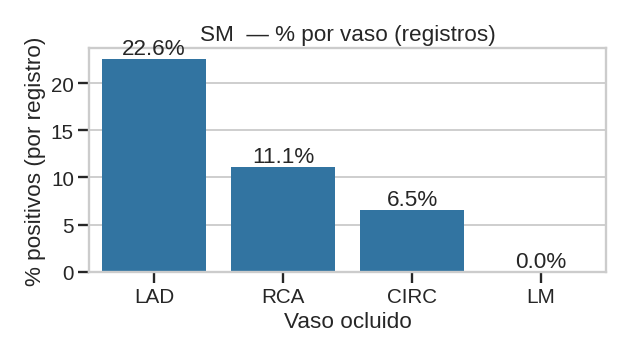

<IPython.core.display.Javascript object>


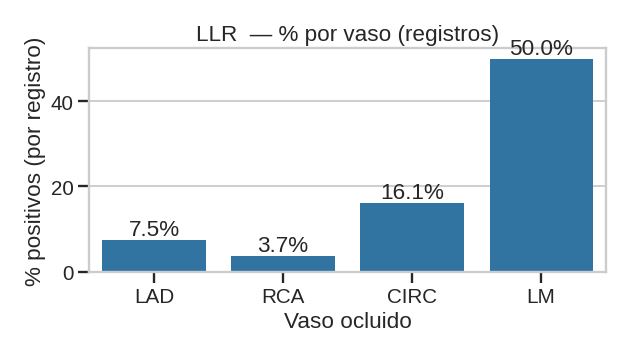

<IPython.core.display.Javascript object>


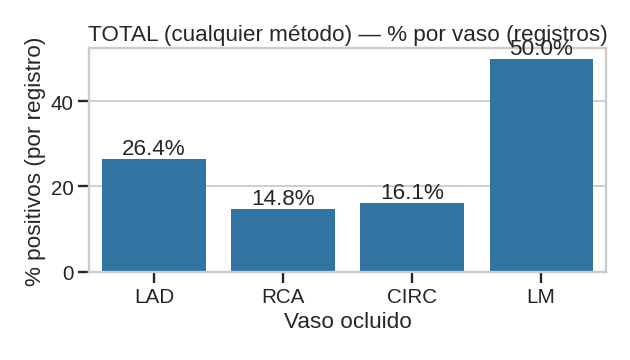

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

def bar_pct(df, title, fname=None):
    plt.figure(figsize=(7,4))
    ax = sns.barplot(data=df, x="vessel", y="%", order=[v for v in VESSEL_ORDER if v in df["vessel"].unique()])
    ax.bar_label(ax.containers[0], fmt="%.1f%%")
    plt.title(title)
    plt.xlabel("Vaso ocluido")
    plt.ylabel("% positivos (por registro)")
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=200)
    plt.show()

bar_pct(sm_reg_v,  "SM  — % por vaso (registros)", "BI_reg_SM.png")
bar_pct(llr_reg_v, "LLR  — % por vaso (registros)", "BI_reg_LLR.png")
bar_pct(tot_reg_v, "TOTAL (cualquier método) — % por vaso (registros)", "BI_reg_TOTAL.png")


### 🔹 Alternancia por **PACIENTE**

**Método Espectral (SM)**

vessel     %
0    LAD  30.6
1    RCA  10.2
2   CIRC   8.7
3     LM   0.0

**Método LLR**

vessel     %
0    LAD   8.3
1    RCA   4.1
2   CIRC  17.4
3     LM  50.0

**Método LLR**

vessel     %
0    LAD  33.3
1    RCA  14.3
2   CIRC  17.4
3     LM  50.0

<IPython.core.display.Javascript object>


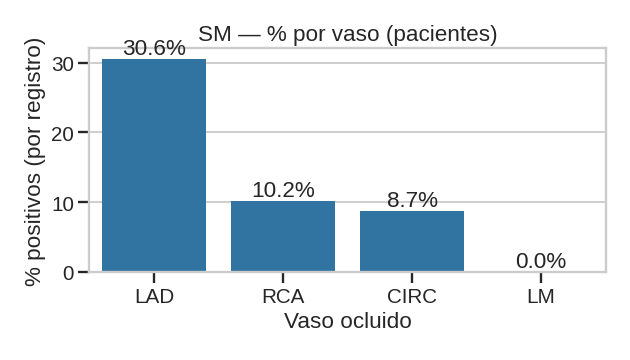

<IPython.core.display.Javascript object>


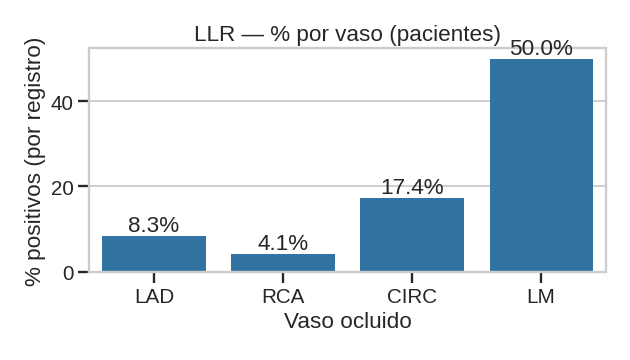

<IPython.core.display.Javascript object>


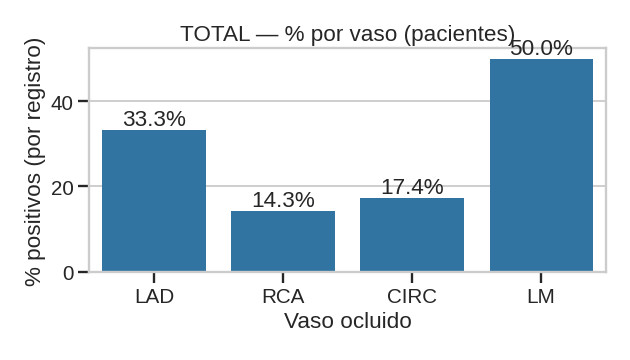

In [144]:
def pct_por_paciente(df, flag_col, pid_col="paciente", vessel_col="vessel"):
    per_pac_vessel = (df.dropna(subset=[vessel_col])
                        .groupby([pid_col, vessel_col])[flag_col]
                        .any()
                        .reset_index(name="has_pos"))
    out = (per_pac_vessel.groupby(vessel_col, as_index=False)["has_pos"]
             .mean())
    out["%"] = (out["has_pos"]*100).round(1)
    out = out.drop(columns=["has_pos"]).set_index(vessel_col).reindex(VESSEL_ORDER).reset_index().dropna()
    return out

sm_pac_v  = pct_por_paciente(bi, "AOT_SM")
llr_pac_v = pct_por_paciente(bi, "AOT_LLR")
tot_pac_v = pct_por_paciente(bi, "AOT_global")

#display(sm_pac_v, twa_pac_v, llr_pac_v, tot_pac_v)

display(Markdown("### 🔹 Alternancia por **PACIENTE**"))
display(Markdown("**Método Espectral (SM)**"))
display(sm_pac_v)
display(Markdown("**Método LLR**"))
display(llr_pac_v)
display(Markdown("**Método LLR**"))
display(tot_pac_v)


bar_pct(sm_pac_v,  "SM — % por vaso (pacientes)",   "BI_pac_SM.png")
bar_pct(llr_pac_v, "LLR — % por vaso (pacientes)",  "BI_pac_LLR.png")
bar_pct(tot_pac_v, "TOTAL — % por vaso (pacientes)","BI_pac_TOTAL.png")


In [197]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _crosstab_2x2(sub: pd.DataFrame, flag_row: str, flag_col: str):
    r = sub[flag_row].astype(bool)
    c = sub[flag_col].astype(bool)

    ct = pd.crosstab(r, c, dropna=False)
    ct = ct.reindex(index=[False, True], columns=[False, True], fill_value=0).astype(int)

    row_sums = ct.sum(axis=1).replace(0, np.nan)
    pct = (ct.div(row_sums, axis=0) * 100).fillna(0).round(1)

    return ct, pct

def overlap_heatmap_por_vaso(df, flag_row, flag_col, title_prefix, fname_prefix, vessel_col="vessel", order=None):
    if order is None:
        order = ["LAD", "RCA", "CIRC", "LM", "DIAG", "OTROS"]

    presentes = df[vessel_col].dropna().unique().tolist()
    vasos = [v for v in order if v in presentes]
    if not vasos:
        print("No hay vasos válidos para representar.")
        return

    ncols = min(len(vasos), 3)
    nrows = int(np.ceil(len(vasos) / ncols)) or 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)

    for ax, v in zip(axes.ravel(), vasos):
        sub = df[df[vessel_col] == v].dropna(subset=[flag_row, flag_col])
        if sub.empty:
            ax.axis("off")
            continue

        ct, pct = _crosstab_2x2(sub, flag_row, flag_col)

        sns.heatmap(pct, annot=False, fmt=".1f", cmap="Blues",
                    cbar=False, vmin=0, vmax=100, ax=ax)

        ax.set_title(f"{title_prefix} — {v}")
        ax.set_xlabel(flag_col); ax.set_ylabel(flag_row)

        ax.set_xticks([0.5, 1.5]); ax.set_xticklabels(["No", "Sí"])
        ax.set_yticks([0.5, 1.5]); ax.set_yticklabels(["No", "Sí"], rotation=0)

        for i in range(2):
            for j in range(2):
                ax.text(j+0.5, i+0.5, f"{pct.iat[i, j]:.1f}%\n(n={ct.iat[i, j]})",
                        ha="center", va="center", fontsize=10, color="black")

    for ax in axes.ravel()[len(vasos):]:
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(f"{fname_prefix}.png", dpi=200)
    plt.show()


<IPython.core.display.Javascript object>


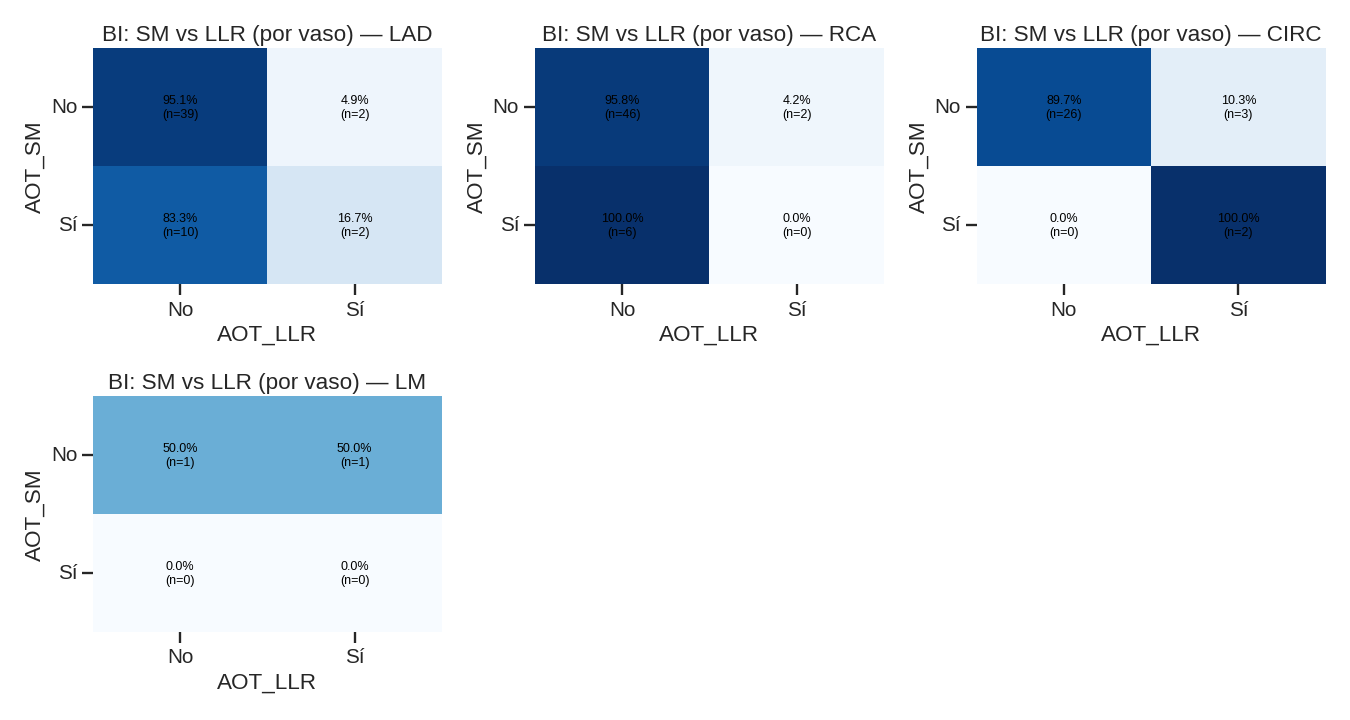

In [198]:
overlap_heatmap_por_vaso(bi, "AOT_SM", "AOT_LLR",
                         "BI: SM vs LLR (por vaso)",
                         "BI_heatmap_SM_vs_LLR_por_vaso")


In [199]:
def bar_pct_with_n(tabla, pct_col, pos_col, n_col, title,
                   ylabel="% positivos", fname=None):
    """
    tabla   : DataFrame con columnas ['vessel', pct_col, pos_col, n_col]
    pct_col : nombre de la columna con el porcentaje (p.ej. 'pct_global')
    pos_col : nombre de la columna con nº de positivos (p.ej. 'pos_global')
    n_col   : nombre de la columna con el denominador (p.ej. 'n_reg' o 'n_pac')
    """

    plot_df = tabla.dropna(subset=[pct_col]).copy()
    
    order = [v for v in VESSEL_ORDER if v in plot_df["vessel"].unique()]
    plot_df = plot_df.set_index("vessel").loc[order].reset_index()

    plt.figure(figsize=(6, 5))
    ax = sns.barplot(data=plot_df, x="vessel", y=pct_col, order=order)

    max_val = plot_df[pct_col].max()
    ax.set_ylim(0, max_val * 1.2)   


    for i, row in plot_df.iterrows():
        bar = ax.patches[i]
        height = bar.get_height()
        ax.annotate(f"{height:.1f}%\n(n={row[pos_col]}/{row[n_col]})",
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points", color = 'black',
                    ha="center", va="bottom", fontsize=12)

    ax.set_xlabel("Vaso ocluido")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200)
    plt.show()


In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

for col in ["AOT_SM", "AOT_LLR", "AOT_global"]:
    bi[col] = bi[col].astype(bool)

# Orden de vasos para mostrar
VESSEL_ORDER = ["LAD", "RCA", "CIRC", "LM"]

# TABLA POR REGISTRO 
tabla_reg = (
    bi.groupby("vessel")
      .agg(
          n_reg      = ("record", "nunique"),                         # nº de registros BI
          pos_SM     = ("AOT_SM",     lambda x: x.sum()),             # positivos SM
          pos_LLR    = ("AOT_LLR",    lambda x: x.sum()),             # positivos LLR
          pos_global = ("AOT_global", lambda x: x.sum()),             # positivos global
      )
      .reindex(VESSEL_ORDER)
      .dropna(subset=["n_reg"])
      .reset_index()
)

# porcentajes por registro
tabla_reg["pct_SM"]      = (tabla_reg["pos_SM"]     / tabla_reg["n_reg"] * 100).round(1)
tabla_reg["pct_LLR"]     = (tabla_reg["pos_LLR"]    / tabla_reg["n_reg"] * 100).round(1)
tabla_reg["pct_global"]  = (tabla_reg["pos_global"] / tabla_reg["n_reg"] * 100).round(1)

print("TABLA POR REGISTRO")
print(tabla_reg.to_string(index=False))


TABLA POR REGISTRO
vessel  n_reg  pos_SM  pos_LLR  pos_global  pct_SM  pct_LLR  pct_global
   LAD     53      12        4          14    22.6      7.5        26.4
   RCA     54       6        2           8    11.1      3.7        14.8
  CIRC     31       2        5           5     6.5     16.1        16.1
    LM      2       0        1           1     0.0     50.0        50.0


<IPython.core.display.Javascript object>


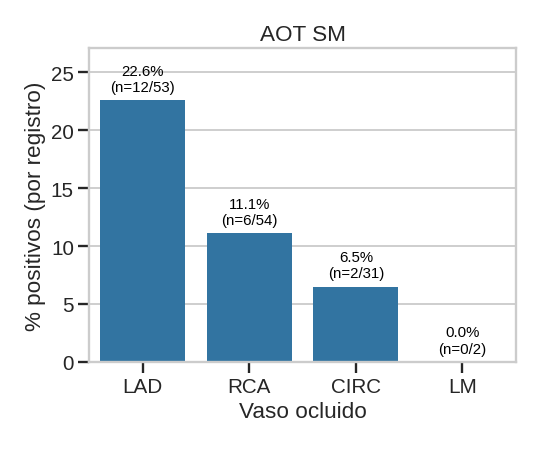

In [201]:
bar_pct_with_n(
    tabla=tabla_reg,
    pct_col="pct_SM",
    pos_col="pos_SM",
    n_col="n_reg",
    title="AOT SM",
    ylabel="% positivos (por registro)",
    fname="BI_reg_SM.png"   
)

<IPython.core.display.Javascript object>


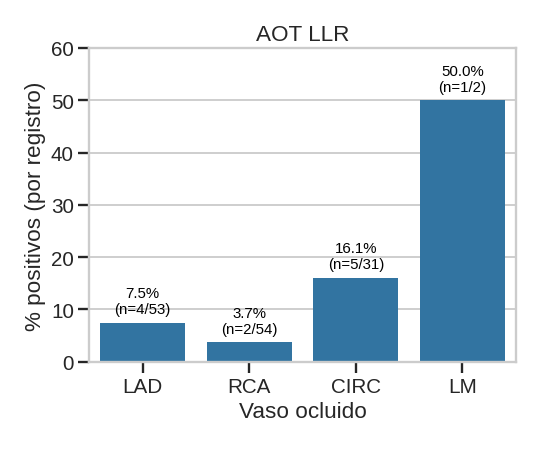

In [202]:
bar_pct_with_n(
    tabla=tabla_reg,
    pct_col="pct_LLR",
    pos_col="pos_LLR",
    n_col="n_reg",
    title="AOT LLR",
    ylabel="% positivos (por registro)",
    fname="BI_reg_LLR.png"  
)

<IPython.core.display.Javascript object>


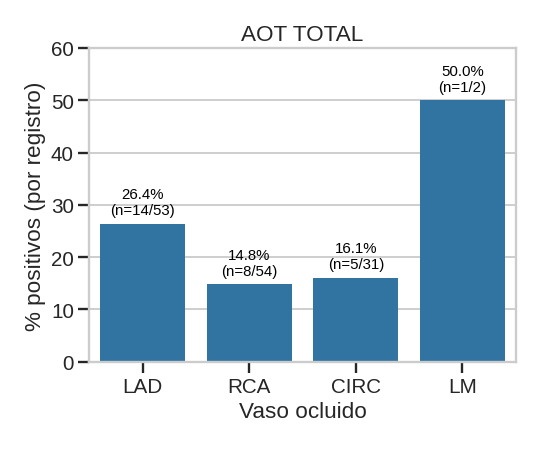

In [152]:
bar_pct_with_n(
    tabla=tabla_reg,
    pct_col="pct_global",
    pos_col="pos_global",
    n_col="n_reg",
    title="AOT TOTAL",
    ylabel="% positivos (por registro)",
    fname="BI_reg_TOTAL.png"  ) 



# ANÁLISIS DE AOT SEGÚN EL GÉNERO

In [176]:
import pandas as pd, re
import numpy as np

ANNOT_XLSX = "/home/alumnos/lauramll/Escritorio/TFG/staff_III/STAFF-III-Database-Annotations.xlsx"  # cambia ruta si procede

COLS = ["Patient","Age","Sex",
        "BR","BC1","BC2",
        "BI1","BI1:Occluded artery","BI1:D0;D1;D2"," BI1:Injection time(s)",
        "BI2","BI2:Occluded artery","BI2:D0;D1;D2","BI2:Injection time(s)",
        "BI3","BI3:Occluded artery","BI3:D0;D1;D2","BI3:Injection time(s)",
        "BI4","BI4:Occluded artery","BI4:D0;D1;D2",
        "BI5","BI5:Occluded artery","BI5:D0;D1;D2",
        "PC1","PC2","PR1","PR2","Prior MI"]

raw = pd.read_excel(ANNOT_XLSX, header=0)
raw = raw[[c for c in COLS if c in raw.columns]].copy()

# -------- utils --------
def _first_code(x):
    if pd.isna(x): return None
    s = str(x).strip().lower()
    if not s: return None
    m = re.findall(r"\d+\s*[a-z]", s)
    return m[0].replace(" ","") if m else None

def _patient_num(v):
    try: return int(str(v).strip().replace("#",""))
    except: return None

def _norm_sex(x):
    # Devuelve 'M', 'F' o None
    if pd.isna(x): return None
    s = str(x).strip().upper()
    if not s: return None
    if s.startswith("M"): return "M"
    if s.startswith("F"): return "F"
    return None

def _prior_mi_group(x):
    """
    Prior MI:
      - 'no'         -> 'No MI previo'
      - 'inferior', 'inferior+anterior', 'anterior', etc. -> 'MI previo'
    """
    if pd.isna(x): return None
    s = str(x).strip().lower()
    if not s: return None
    if s.startswith("no"):
        return "No MI previo"
    return "MI previo"

# definición de grupos e índices
PHASE_MAP = {
    "BR":  ["BR"],
    "BC":  ["BC1","BC2"],
    "BI":  ["BI1","BI2","BI3","BI4","BI5"],
    "PC":  ["PC1","PC2"],
    "PR":  ["PR1","PR2"],
}

rows = []
for _, r in raw.iterrows():
    pnum = _patient_num(r.get("Patient"))
    if pnum is None:
        continue

    sex_val   = _norm_sex(r.get("Sex"))
    prior_grp = _prior_mi_group(r.get("Prior MI"))

    for phase, cols in PHASE_MAP.items():
        for i, col in enumerate(cols, start=1):
            if col not in r:
                continue
            code = _first_code(r[col])
            if not code:
                continue

            m = re.match(r"(\d+)([a-z])", code)
            if not m:
                continue
            letter = m.group(2)
            record = f"{pnum:03d}{letter}"

            rows.append({
                "patient": f"{pnum:03d}",
                "record": record,
                "phase_group": phase,      # BR/BC/BI/PC/PR
                "phase_idx": i,            # 1..N dentro del grupo
                "phase_letter": letter,    # a,b,c,d,...
                "sex": sex_val,            # 'M' o 'F'
                "prior_mi_group": prior_grp,  # 'No MI previo' / 'MI previo'
            })

ann_long = (pd.DataFrame(rows)
              .drop_duplicates(subset=["record"])
              .reset_index(drop=True))

print("Registros mapeados desde Excel:", len(ann_long))
display(ann_long.head(15))


Registros mapeados desde Excel: 520


patient record phase_group  phase_idx phase_letter sex prior_mi_group
0      001   001a          BR          1            a   F   No MI previo
1      001   001b          BC          1            b   F   No MI previo
2      001   001c          BI          1            c   F   No MI previo
3      001   001d          PR          1            d   F   No MI previo
4      002   002a          BR          1            a   M      MI previo
5      002   002b          BC          1            b   M      MI previo
6      002   002c          BC          2            c   M      MI previo
7      002   002d          BI          1            d   M      MI previo
8      002   002e          BI          2            e   M      MI previo
9      002   002f          PR          1            f   M      MI previo
10     003   003a          BR          1            a   F   No MI previo
11     003   003b          BC          1            b   F   No MI previo
12     003   003c          BI          1            c   F   No MI previo
13     003   003d          PC          1            d   F   No MI previo
14     003   003e          PR          1            e   F   No MI previo

In [171]:
ann_pat = raw.copy()
ann_pat["patient"] = ann_pat["Patient"].apply(_patient_num)

ann_pat["sex"] = ann_pat["Sex"].apply(_norm_sex)

ann_pat = ann_pat.dropna(subset=["patient","sex"]).copy()

ann_pat["patient_str"] = ann_pat["patient"].apply(lambda x: f"{int(x):03d}")

print("Pacientes con sexo conocido por Excel:", ann_pat["patient"].nunique())
print(ann_pat[["patient_str","sex"]].drop_duplicates().head())

Pacientes con sexo conocido por Excel: 104
  patient_str sex
0         001   F
1         002   M
2         003   F
3         004   F
4         005   M


In [179]:
if "paciente" not in df_ok_lab.columns:
    df_ok_lab["paciente"] = (
        df_ok_lab["record"]
          .astype(str)
          .str.extract(r"(\d{3})")
          .iloc[:,0]
    )

df_sex = df_ok_lab.merge(
    ann_pat[["patient_str","sex"]],
    left_on="paciente",
    right_on="patient_str",
    how="left"
)

print("Registros totales en df_ok_lab:", len(df_ok_lab))
print("Registros con sexo asignado:", df_sex["sex"].notna().sum())
print(df_sex[["record","paciente","sex"]].head())


Registros totales en df_ok_lab: 516
Registros con sexo asignado: 516
  record paciente sex
0   030a      030   F
1   033b      033   M
2   030b      030   F
3   088b      088   M
4   048c      048   M


In [180]:
registros_por_sexo = (
    df_sex.drop_duplicates(subset=["record"])
          .groupby("sex")["record"]
          .nunique()
          .rename("n_registros")
)
print("Registros por sexo:")
print(registros_por_sexo)



pacientes_por_sexo = (
    ann_pat.drop_duplicates(subset=["patient"])
           .groupby("sex")["patient"]
           .nunique()
           .rename("n_pacientes")
)
print("Pacientes por sexo:")
print(pacientes_por_sexo)



Registros por sexo:
sex
F    189
M    327
Name: n_registros, dtype: int64
Pacientes por sexo:
sex
F    39
M    65
Name: n_pacientes, dtype: int64


In [181]:
def detectar_criterios(df):
    crit_cols = []
    for c in df.columns:
        if isinstance(c, str) and c.startswith("AOT_"):
            if pd.api.types.is_bool_dtype(df[c]) \
               or pd.api.types.is_integer_dtype(df[c]) \
               or pd.api.types.is_float_dtype(df[c]):
                crit_cols.append(c)
    return crit_cols

CRIT_COLS = detectar_criterios(df_sex)



In [183]:
tab_general = df_sex.groupby("sex")[["AOT_SM","AOT_LLR","AOT_global"]].mean() * 100
print("=== TABLA GENERAL POR SEXO - REGISTRO (%) ===")
print(tab_general.round(2))


=== TABLA GENERAL POR SEXO - REGISTRO (%) ===
     AOT_SM  AOT_LLR  AOT_global
sex                             
F      7.41     2.12        7.94
M     10.09     5.81       13.76


In [189]:
df_sex_merged = df_sex.merge(
    ann_long[["record", "patient", "sex"]],
    on="record",
    how="left",
    suffixes=("", "_ann")
)

df_pat = (
    df_sex_merged
        .dropna(subset=["patient", "sex"])
        .groupby(["patient","sex"])[["AOT_SM","AOT_LLR","AOT_global"]]
        .max()
        .reset_index()
)

print("=== TABLA GENERAL POR SEXO - PACIENTE (%) ===")
tab_pat = df_pat.groupby("sex")[["AOT_SM","AOT_LLR","AOT_global"]].mean() * 100
print(tab_pat.round(2))


=== TABLA GENERAL POR SEXO - PACIENTE (%) ===
     AOT_SM  AOT_LLR  AOT_global
sex                             
F     25.64    10.26       28.21
M     32.31    18.46       38.46


In [193]:
print(df.columns)


Index(['index', 'record', 'fs', 'r_ref_count', 'ref_lead_used', 'n_segments',
       'K_max', 'K_p95', 'Valt_SM_med', 'Valt_SM_max', 'DR3', 'Vm_med_uV',
       'LLR_T_med', 'LLR_T_max', 'QRS_leak_score_%', 'bw_applied',
       'pipe_version'],
      dtype='object')


# DETECCIÓN SEGÚN ANTECEDENTES DE INFARTO DE MIOCARDIO


In [194]:

def _prior_mi_group(x):
    """
    Clasifica en:
      - 'No MI previo'  → si empieza por 'no'
      - 'MI previo'      → cualquier otra cosa (inferior, anterior, etc.)
    """
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    if not s:
        return None
    if s.startswith("no"):
        return "No MI previo"
    return "MI previo"

ann_mi = raw.copy()
ann_mi["patient"] = ann_mi["Patient"].apply(_patient_num)
ann_mi["prior_mi_group"] = ann_mi["Prior MI"].apply(_prior_mi_group)
ann_mi["patient_str"] = ann_mi["patient"].apply(lambda x: f"{int(x):03d}")


if "paciente" not in df_ok_lab.columns:
    df_ok_lab["paciente"] = df_ok_lab["record"].str.extract(r"(\d{3})").iloc[:,0]

df_mi = df_ok_lab.merge(
    ann_mi[["patient_str","prior_mi_group"]],
    left_on="paciente",
    right_on="patient_str",
    how="left"
)

print("Registros con MI previo asignado:",
      df_mi["prior_mi_group"].notna().sum(), "/", len(df_mi))


Registros con MI previo asignado: 516 / 516


In [195]:
df_reg_mi = df_mi.dropna(subset=["prior_mi_group"]).copy()

metrics = ["AOT_SM", "AOT_LLR", "AOT_global"]

tabla_registros = df_reg_mi.groupby("prior_mi_group")[metrics].mean() * 100

print("=== AOT POR REGISTRO (% según MI previo) ===")
print(tabla_registros.round(2))


=== AOT POR REGISTRO (% según MI previo) ===
                AOT_SM  AOT_LLR  AOT_global
prior_mi_group                             
MI previo        10.00     3.89       12.22
No MI previo      8.63     4.76       11.31


In [196]:
df_reg_mi = df_mi.dropna(subset=["prior_mi_group"]).copy()

# Reducimos a un registro por paciente
df_pac_mi = df_reg_mi.groupby(["paciente","prior_mi_group"])[["AOT_SM","AOT_LLR","AOT_global"]].max().reset_index()

tabla_pacientes = df_pac_mi.groupby("prior_mi_group")[["AOT_SM","AOT_LLR","AOT_global"]].mean() * 100

print("=== AOT POR PACIENTE (% según MI previo) ===")
print(tabla_pacientes.round(2))


=== AOT POR PACIENTE (% según MI previo) ===
                AOT_SM  AOT_LLR  AOT_global
prior_mi_group                             
MI previo        37.14    14.29       40.00
No MI previo     26.09    15.94       31.88
